In [1]:
# package(s) related to time, space and id
import datetime, time
import os
import io
import functools
import logging
import pickle
import random
import math

# package(s) related to the simulation
import enum
import simpy
import scipy as sc
import math
import networkx as nx  
import numpy as np
import pandas as pd
import re
import yaml as yaml
import time
import bisect
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import xarray as xr

from osgeo import gdal
from scipy import interpolate
from scipy.signal import correlate
from shapely.ops import transform,split,snap
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# OpenTNSim
from opentnsim import core
from opentnsim import plot
from opentnsim import model
from opentnsim import import_hydrodynamic_dataset
from opentnsim import vessel_traffic_service
from opentnsim import port
from opentnsim import lock
from opentnsim import vessel
from opentnsim import waterway
from opentnsim import output
from opentnsim import tidal_window_constructor
from opentnsim import rule_constructor
from opentnsim import regulations

# spatial libraries 
import shapely.geometry
from shapely.geometry import Point
import shapely.wkt
import pyproj
import folium
import datetime
import time as timepy

# package(s) for data handling
import requests

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

# define the coorinate systemb
geod = pyproj.Geod(ellps="WGS84")

location_vessel_database = "Vessels/richtlijnen-vaarwegen-2017.csv"

AttributeError: module 'opentnsim.lock' has no attribute 'HasLock'

In [2]:
wgs = pyproj.CRS('EPSG:4326')
utm = pyproj.CRS('EPSG:28992')
wgs_to_utm = pyproj.Transformer.from_crs(wgs,utm,always_xy=True).transform
utm_to_wgs = pyproj.Transformer.from_crs(utm,wgs,always_xy=True).transform

In [3]:
starting_hour = 1000/(60*60*4)
next_hours = np.arange(0.25,12.25,0.25)
hours = np.append(np.array([starting_hour]),next_hours)

In [4]:
Node = type('Site', (core.Identifiable, core.Log, core.Locatable, core.HasResource), {})
nodes = []
path = []
coords = []

for hour in reversed(hours):
    coords.append(transform(utm_to_wgs,Point(155000-hour*60*60*4,463000)))
for hour in hours:
    coords.append(transform(utm_to_wgs,Point(155000+hour*60*60*4,463000)))

for index,coord in enumerate(coords):
    data_node = {"env": [],
                 "name": "Node_" + str(index+1),
                 "geometry": coord}
    node = Node(**data_node)
    nodes.append(node)
    
for i in range(len(nodes)-1):
    path.append([nodes[i],nodes[i+1]]) 
    path.append([nodes[i+1],nodes[i]])

FG = nx.MultiDiGraph()

positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

for edge in path:
    geometry = shapely.geometry.LineString([FG.nodes[edge[0].name]['geometry'],FG.nodes[edge[1].name]['geometry']])
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {},geometry=geometry)
    
for node in FG.nodes:
    FG.nodes[node]['Info'] = {}

In [5]:
for node in FG.nodes:
    FG.nodes[node]['geometry'] = transform(wgs_to_utm,FG.nodes[node]['geometry'])
    
for edge in FG.edges:
    geometry = transform(wgs_to_utm,FG.edges[edge]['geometry'])
    length = int(geometry.length)
    FG.edges[edge]['geometry'] = geometry
    FG.edges[edge]['Info']['geometry'] = geometry
    FG.edges[edge]['Info']['length'] = length

In [6]:
import pytz
simulation_start = datetime.datetime(2019,1,1,0,0,0)
duration = datetime.timedelta(seconds=14*24*60*60) #seconds

In [7]:
water_level = []
salinity = []

for nodes in enumerate(FG.nodes):
    water_level.append([[],[]])
    salinity.append([[],[]])

MBL = [11]*len(FG.nodes)
depth = MBL
times = np.arange(simulation_start,simulation_start+duration,datetime.timedelta(seconds=10*60))
stations = list(FG.nodes)

sea = True
for index,node in enumerate(list(FG.nodes)):
    if sea:
        water_level[index]=[1.0*np.sin(2*np.pi*((t-np.datetime64(0,'s'))/np.timedelta64(1, 's')-simulation_start.timestamp())/45000) for t in times]
        salinity[index]=[25.0 for t in times]
        if node == 'Node_49':
            sea = False
    else:
        water_level[index]=[0.0 for t in times]
        salinity[index]=[0.0 for t in times]

In [8]:
import xarray as xr
station_data = xr.DataArray(data=stations,
                         dims=["STATIONS"])

time_data = xr.DataArray(data=times,
                         dims=["TIME"])

MBL_data = xr.DataArray(data=MBL,
                        dims=["STATIONS"])

depth_data = xr.DataArray(data=depth,
                          dims=["STATIONS"])

water_level_data = xr.DataArray(data=[wlev for wlev in water_level],
                                dims=["STATIONS","TIME"])

salinity_data = xr.DataArray(data=[sal for sal in salinity],
                             dims=["STATIONS","TIME"])

hydrodynamic_data = xr.Dataset({'TIME':times,
                                'Stations':station_data,
                                'MBL':MBL_data,
                                'Depth':depth_data,
                                'Water level': water_level_data,
                                'Salinity':salinity_data})

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_23048\3095883058.py:5: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_23048\3095883058.py:20: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by con

In [9]:
sim = model.Simulation(graph=FG,simulation_start=simulation_start,simulation_duration=duration,hydrodynamic_data=hydrodynamic_data)
env = sim.environment

In [10]:
sim.environment.vessel_traffic_service

In [11]:
lock_1 = lock.IsLock(env = sim.environment, 
                     name = 'Lock',
                     distance_doors1_from_first_waiting_area=750,   
                     distance_doors2_from_second_waiting_area=FG.edges['Node_49','Node_50',0]['Info']['length']-1250,
                     node_doors1 = 'Node_49', node_doors2 = 'Node_50',time_step=60,
                     lock_length = 500, lock_width = 40, lock_depth = 10.5, 
                     doors_open = 600, doors_close = 600, disch_coeff = 0.8,
                     opening_area = 4.0, opening_depth = 5.0,node_open='Node_50',
                     detector_nodes=['Node_45','Node_54'], priority_rules = regulations.ConditionalRule('start_node','==','Node_50'))

lineup_area_1 = lock.IsLockLineUpArea(env = sim.environment, name = 'Lock', distance_to_lock_doors = 100,
                                      start_node = 'Node_49',end_node = 'Node_50', lineup_length = 500)

lineup_area_2 = lock.IsLockLineUpArea(env = sim.environment, name = "Lock", distance_to_lock_doors = 100,
                                      start_node = 'Node_50',end_node = 'Node_49', lineup_length = 500)

waiting_area_1 = lock.IsLockWaitingArea(env = sim.environment, name = 'Lock', distance_from_node=0,
                                        node = 'Node_49')
    
waiting_area_2 = lock.IsLockWaitingArea(env = sim.environment, name = "Lock", distance_from_node=0,
                                        node = 'Node_50')

c:\users\floorbakker\opentnsim\opentnsim\lock.py:349: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



In [12]:
lock_1.detector_nodes[0]

'Node_45'

In [13]:
Vessel = type('Vessel', 
              (core.SimpyObject, core.Identifiable, lock.HasWaitingArea, lock.HasLock, lock.HasLineUpArea, core.Movable, vessel.VesselProperties, output.HasOutput, vessel.ExtraMetadata), {})

In [14]:
def create_vessel(name,FG,origin,destination,length,beam,draught,height,v,arrival_time):
    vessel_input = { "name":name,
                     "geometry":FG.nodes[origin]['geometry'],
                     "origin":origin,
                     "destination":destination,
                     #"next_destination":next_destination,
                     "route":nx.dijkstra_path(FG,origin,destination),
                     "env":env,
                     "type":'Tanker',
                     "B":beam,
                     "L":length,
                     "T": draught,
                     "H":height,
                     #"t_berthing":berthing_time.total_seconds(),
                     #"t_(un)loading":[time.total_seconds() for time in unloading_time],
                     #"t_turning":[time.total_seconds() for time in turning_time],
                     #"ukc":ukc,
                     "v":v,
                     #"terminal_of_call": terminal_of_call,
                     #"berth_of_call": berth_of_call,
                     #"(un)loading": delta_draught,
                     #"max_waiting_time":datetime.timedelta(days=10).total_seconds(),
                     #"max_cross_current":max_cross_current,
                     "arrival_time":arrival_time,
                     #"arrival_delay":arrival_time,
                     #"priority": 0,
                     #"additional_waiting_time": additional_waiting_time/np.timedelta64(1, 's'),
                     #"bound":bound,
                     #"priority":False
                   }
    return vessel_input

In [15]:
random.seed(0)
month_reached = False
arrival_time = sim.environment.simulation_start
vessel_index = 0
while not month_reached:
    arrival_time += pd.Timedelta(random.uniform(0,4),'h')
    created_vessel = Vessel(**create_vessel(name = f'inbound_vessel_{vessel_index}',
                                            FG = FG,
                                            origin='Node_1',
                                            destination='Node_98',
                                            length=200,
                                            beam=35,
                                            draught=10,
                                            height=5,
                                            v=4,
                                            arrival_time=arrival_time))
    sim.add_vessels(vessel=created_vessel)
    vessel_index += 1
    if arrival_time > sim.environment.simulation_start + datetime.timedelta(days=14):
        month_reached = True

month_reached = False
arrival_time = sim.environment.simulation_start
vessel_index = 0
while not month_reached:
    arrival_time += pd.Timedelta(random.uniform(0,4),'h')
    created_vessel = Vessel(**create_vessel(name = f'outbound_vessel_{vessel_index}',
                                            FG = FG,
                                            origin='Node_98',
                                            destination='Node_1',
                                            length=200,
                                            beam=35,
                                            draught=10,
                                            height=5,
                                            v=4,
                                            arrival_time=arrival_time))
    sim.add_vessels(vessel=created_vessel)
    vessel_index += 1
    if arrival_time > sim.environment.simulation_start + datetime.timedelta(days=14):
        month_reached = True
    

In [16]:
waiting_area_1.resource.users

[]

In [17]:
t1 = timepy.time()
sim.run()
t2 = timepy.time()
print(t2-t1)

hey ho outbound_vessel_0 []
hi outbound_vessel_0 2019-01-01 12:01:33.438305 0
outbound_vessel_0 start waiting time 2019-01-01 13:00:14.271638
claim the lock doors outbound_vessel_0 2019-01-01 13:00:14.271638
lock is empty and not converting outbound_vessel_0 2019-01-01 13:00:14.271638 0 []
lock doors claimed outbound_vessel_0 2019-01-01 13:00:14.271638
waiting done outbound_vessel_0 2019-01-01 13:00:14.271638
outbound_vessel_0 sail to assigned lock position
print doors outbound_vessel_0 ['outbound_vessel_0'] ['outbound_vessel_0']
left doors1 outbound_vessel_0 2019-01-01 13:11:20.938305 0 [] ['outbound_vessel_0']
outbound_vessel_0 in lock ['outbound_vessel_0']
outbound_vessel_0 converting hap 2019-01-01 13:11:20.938305
hi 2019-01-01 13:11:20.938305
2019-01-01 13:11:20.938305 Node_50 Node_49 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:513: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_0 hap is geconvert 2019-01-01 14:05:20.938305
hey ho outbound_vessel_1 ['outbound_vessel_0']
left doors2 outbound_vessel_0 2019-01-01 14:09:42.049416 0 [] []
hey ho inbound_vessel_0 []
hi inbound_vessel_0 2019-01-01 14:22:39.674661 0
outbound_vessel_1 start waiting time 2019-01-01 15:05:14.735247
outbound_vessel_1 lock position given 2019-01-01 15:05:14.735247
outbound_vessel_1 requested place in next lockage 2019-01-01 15:05:14.735247
claim the lock doors outbound_vessel_1 2019-01-01 15:05:14.735247
requesting approach: else outbound_vessel_1 2019-01-01 15:05:14.735247 0 ['inbound_vessel_0'] []
inbound_vessel_0 start waiting time 2019-01-01 15:21:20.507994
claim the lock doors inbound_vessel_0 2019-01-01 15:21:20.507994
lock is empty and not converting inbound_vessel_0 2019-01-01 15:21:20.507994 0 []
lock doors claimed inbound_vessel_0 2019-01-01 15:21:20.507994
waiting done inbound_vessel_0 2019-01-01 15:21:20.507994
inbound_vessel_0 sail to assigned lock position
pri

c:\users\floorbakker\opentnsim\opentnsim\lock.py:513: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_0 hap is geconvert 2019-01-01 16:28:27.174661
left doors2 inbound_vessel_0 2019-01-01 16:32:48.285772 1 [] []
doors requested outbound_vessel_1
claiming lock: priority doors2 not -1 outbound_vessel_1 2019-01-01 16:32:48.285772
waiting done outbound_vessel_1 2019-01-01 16:32:48.285772
outbound_vessel_1 sail to assigned lock position
hey ho outbound_vessel_2 ['outbound_vessel_1']
yo outbound_vessel_2 2019-01-01 16:41:21.047553 ['outbound_vessel_1']
print doors outbound_vessel_1 ['outbound_vessel_1'] ['outbound_vessel_1']
left doors1 outbound_vessel_1 2019-01-01 16:43:54.952439 0 [] ['outbound_vessel_1']
outbound_vessel_1 in lock ['outbound_vessel_1', 'outbound_vessel_2']
waiting for others outbound_vessel_1
outbound_vessel_2 start waiting time 2019-01-01 17:40:01.880886
claim the lock doors outbound_vessel_2 2019-01-01 17:40:01.880886
lock not empty outbound_vessel_2 ['outbound_vessel_1']
lock is ready to be entered 2019-01-01 17:40:01.880886
lock doors claimed outbound_ve

c:\users\floorbakker\opentnsim\opentnsim\lock.py:513: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_2 hap is geconvert 2019-01-01 18:18:47.436442
left doors2 outbound_vessel_2 2019-01-01 18:26:50.769775 0 [] []
inbound_vessel_1 start waiting time 2019-01-01 18:55:00.020454
claim the lock doors inbound_vessel_1 2019-01-01 18:55:00.020454
lock is empty and not converting inbound_vessel_1 2019-01-01 18:55:00.020454 0 []
lock doors claimed inbound_vessel_1 2019-01-01 18:55:00.020454
waiting done inbound_vessel_1 2019-01-01 18:55:00.020454
inbound_vessel_1 sail to assigned lock position
hey ho inbound_vessel_2 ['inbound_vessel_1']
yo inbound_vessel_2 2019-01-01 18:58:27.588325 ['inbound_vessel_1']
print doors inbound_vessel_1 ['inbound_vessel_1'] ['inbound_vessel_1']
left doors1 inbound_vessel_1 2019-01-01 19:06:06.687121 [] 1 ['inbound_vessel_1']
inbound_vessel_1 in lock ['inbound_vessel_1', 'inbound_vessel_2']
waiting for others inbound_vessel_1
inbound_vessel_2 start waiting time 2019-01-01 19:57:08.421658
claim the lock doors inbound_vessel_2 2019-01-01 19:57:08.421658

c:\users\floorbakker\opentnsim\opentnsim\lock.py:513: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_2 hap is geconvert 2019-01-01 21:05:53.977214
outbound_vessel_3 start waiting time 2019-01-01 21:09:16.720120
claim the lock doors outbound_vessel_3 2019-01-01 21:09:16.720120
lock not empty outbound_vessel_3 ['inbound_vessel_2']
lock is already converting outbound_vessel_3 2019-01-01 21:09:16.720120 ['inbound_vessel_2']
left doors2 inbound_vessel_2 2019-01-01 21:13:57.310547 1 [] []
lock doors claimed outbound_vessel_3 2019-01-01 21:13:57.310547
first in line to claim lock outbound_vessel_3 2019-01-01 21:13:57.310547
waiting done outbound_vessel_3 2019-01-01 21:13:57.310547
outbound_vessel_3 sail to assigned lock position
print doors outbound_vessel_3 ['outbound_vessel_3'] ['outbound_vessel_3']
left doors1 outbound_vessel_3 2019-01-01 21:25:03.977214 0 [] ['outbound_vessel_3']
outbound_vessel_3 in lock ['outbound_vessel_3']
outbound_vessel_3 converting hap 2019-01-01 21:25:03.977214
hi 2019-01-01 21:25:03.977214
2019-01-01 21:25:03.977214 Node_50 Node_49 Lock doors clos

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_3 start waiting time 2019-01-01 21:53:45.780488
inbound_vessel_3 lock position given 2019-01-01 21:53:45.780488
inbound_vessel_3 requested place in next lockage 2019-01-01 21:53:45.780488
claim the lock doors inbound_vessel_3 2019-01-01 21:53:45.780488
lock not empty inbound_vessel_3 ['outbound_vessel_3']
lock is already converting inbound_vessel_3 2019-01-01 21:53:45.780488 ['outbound_vessel_3']
outbound_vessel_3 hap is geconvert 2019-01-01 22:22:03.977214
left doors2 outbound_vessel_3 2019-01-01 22:26:25.088325 0 [] []
lock doors claimed inbound_vessel_3 2019-01-01 22:26:25.088325
first in line to claim lock inbound_vessel_3 2019-01-01 22:26:25.088325
waiting done inbound_vessel_3 2019-01-01 22:26:25.088325
inbound_vessel_3 sail to assigned lock position
print doors inbound_vessel_3 ['inbound_vessel_3'] ['inbound_vessel_3']
left doors1 inbound_vessel_3 2019-01-01 22:37:31.754992 [] 1 ['inbound_vessel_3']
inbound_vessel_3 in lock ['inbound_vessel_3']
inbound_vessel_3 co

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_3 hap is geconvert 2019-01-01 23:23:31.754992
left doors2 inbound_vessel_3 2019-01-01 23:27:52.866103 1 [] []
hey ho outbound_vessel_4 []
hi outbound_vessel_4 2019-01-01 23:34:53.739164 0
hey ho outbound_vessel_5 ['outbound_vessel_4']
yo outbound_vessel_5 2019-01-01 23:44:39.290304 ['outbound_vessel_4']
hey ho inbound_vessel_4 []
hi inbound_vessel_4 2019-01-02 00:03:11.646837 0
outbound_vessel_4 start waiting time 2019-01-02 00:33:34.572497
claim the lock doors outbound_vessel_4 2019-01-02 00:33:34.572497
lock is empty and not converting outbound_vessel_4 2019-01-02 00:33:34.572497 0 []
lock doors claimed outbound_vessel_4 2019-01-02 00:33:34.572497
waiting done outbound_vessel_4 2019-01-02 00:33:34.572497
outbound_vessel_4 sail to assigned lock position
outbound_vessel_5 start waiting time 2019-01-02 00:43:20.123637
claim the lock doors outbound_vessel_5 2019-01-02 00:43:20.123637
lock not empty outbound_vessel_5 ['outbound_vessel_4']
lock is already converting outbound

c:\users\floorbakker\opentnsim\opentnsim\lock.py:513: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_5 hap is geconvert 2019-01-02 01:40:26.794720
outbound_vessel_6 start waiting time 2019-01-02 01:45:39.362745
wait for lockage True ['outbound_vessel_5'] True
outbound_vessel_6 lock position given 2019-01-02 01:46:00.128053
outbound_vessel_6 requested place in next lockage 2019-01-02 01:46:00.128053
claim the lock doors outbound_vessel_6 2019-01-02 01:46:00.128053
requesting approach: else outbound_vessel_6 2019-01-02 01:46:00.128053 0 [] ['outbound_vessel_5']
doors requested outbound_vessel_6
claiming lock: priority doors2 is -1 outbound_vessel_6 2019-01-02 01:46:00.128053
outbound_vessel_6 wth
hi 2019-01-02 01:46:00.128053
2019-01-02 01:46:00.128053 Node_49 Node_50 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



waiting done outbound_vessel_6 2019-01-02 02:41:00.128053
outbound_vessel_6 sail to assigned lock position
print doors outbound_vessel_6 ['outbound_vessel_6'] ['outbound_vessel_6']
left doors1 outbound_vessel_6 2019-01-02 02:52:06.794720 0 [] ['outbound_vessel_6']
outbound_vessel_6 in lock ['outbound_vessel_6']
outbound_vessel_6 converting hap 2019-01-02 02:52:06.794720
hi 2019-01-02 02:52:06.794720
2019-01-02 02:52:06.794720 Node_50 Node_49 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_6 hap is geconvert 2019-01-02 03:51:06.794720
left doors2 outbound_vessel_6 2019-01-02 03:55:27.905831 0 [] []
doors requested inbound_vessel_4
claiming lock: priority doors2 not -1 inbound_vessel_4 2019-01-02 03:55:27.905831
waiting done inbound_vessel_4 2019-01-02 03:55:27.905831
hey ho inbound_vessel_5 ['inbound_vessel_4']
yo inbound_vessel_5 2019-01-02 03:55:27.966763 ['inbound_vessel_4']
inbound_vessel_4 sail to assigned lock position
print doors inbound_vessel_4 ['inbound_vessel_4'] ['inbound_vessel_4']
left doors1 inbound_vessel_4 2019-01-02 04:06:34.572498 [] 1 ['inbound_vessel_4']
inbound_vessel_4 in lock ['inbound_vessel_4', 'inbound_vessel_5']
waiting for others inbound_vessel_4
hey ho outbound_vessel_7 []
hi outbound_vessel_7 2019-01-02 04:34:08.166192 0
inbound_vessel_5 start waiting time 2019-01-02 04:54:08.800096
claim the lock doors inbound_vessel_5 2019-01-02 04:54:08.800096
lock not empty inbound_vessel_5 ['inbound_vessel_4']
lock is ready to be entere

c:\users\floorbakker\opentnsim\opentnsim\lock.py:513: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_7 start waiting time 2019-01-02 05:32:48.999525
claim the lock doors outbound_vessel_7 2019-01-02 05:32:48.999525
lock not empty outbound_vessel_7 ['inbound_vessel_4', 'inbound_vessel_5']
lock is already converting outbound_vessel_7 2019-01-02 05:32:48.999525 ['inbound_vessel_4', 'inbound_vessel_5']
inbound_vessel_5 hap is geconvert 2019-01-02 05:50:54.355652
left doors2 inbound_vessel_5 2019-01-02 05:58:57.688985 1 [] []
lock doors claimed outbound_vessel_7 2019-01-02 05:58:57.688985
first in line to claim lock outbound_vessel_7 2019-01-02 05:58:57.688985
waiting done outbound_vessel_7 2019-01-02 05:58:57.688985
outbound_vessel_7 sail to assigned lock position
print doors outbound_vessel_7 ['outbound_vessel_7'] ['outbound_vessel_7']
left doors1 outbound_vessel_7 2019-01-02 06:10:04.355652 0 [] ['outbound_vessel_7']
outbound_vessel_7 in lock ['outbound_vessel_7']
outbound_vessel_7 converting hap 2019-01-02 06:10:04.355652
hi 2019-01-02 06:10:04.355652
2019-01-02 06:10:0

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_7 hap is geconvert 2019-01-02 06:31:04.355652
left doors2 outbound_vessel_7 2019-01-02 06:35:25.466763 0 [] []
hey ho outbound_vessel_8 []
hi outbound_vessel_8 2019-01-02 06:50:19.702413 0
hey ho outbound_vessel_9 ['outbound_vessel_8']
yo outbound_vessel_9 2019-01-02 07:00:24.567673 ['outbound_vessel_8']
hey ho inbound_vessel_7 ['inbound_vessel_6']
yo inbound_vessel_7 2019-01-02 07:07:54.243398 ['inbound_vessel_6']
inbound_vessel_6 start waiting time 2019-01-02 07:14:09.501464
claim the lock doors inbound_vessel_6 2019-01-02 07:14:09.501464
lock is empty and not converting inbound_vessel_6 2019-01-02 07:14:09.501464 0 []
lock doors claimed inbound_vessel_6 2019-01-02 07:14:09.501464
waiting done inbound_vessel_6 2019-01-02 07:14:09.501464
inbound_vessel_6 sail to assigned lock position
print doors inbound_vessel_6 ['inbound_vessel_6'] ['inbound_vessel_6']
left doors1 inbound_vessel_6 2019-01-02 07:25:16.168131 [] 1 ['inbound_vessel_6']
inbound_vessel_6 in lock ['inbound

c:\users\floorbakker\opentnsim\opentnsim\lock.py:513: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_8 start waiting time 2019-01-02 09:14:13.541690
wait for lockage True ['inbound_vessel_7'] True
inbound_vessel_7 hap is geconvert 2019-01-02 09:14:20.632287
inbound_vessel_8 lock position given 2019-01-02 09:19:53.965620
inbound_vessel_8 requested place in next lockage 2019-01-02 09:19:53.965620
claim the lock doors inbound_vessel_8 2019-01-02 09:19:53.965620
requesting approach: else inbound_vessel_8 2019-01-02 09:19:53.965620 0 [] ['inbound_vessel_7']
doors requested inbound_vessel_8
claiming lock: priority doors2 is -1 inbound_vessel_8 2019-01-02 09:19:53.965620
inbound_vessel_8 wth
hi 2019-01-02 09:19:53.965620
2019-01-02 09:19:53.965620 Node_50 Node_49 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_9 start waiting time 2019-01-02 09:35:52.438018
inbound_vessel_9 lock position given 2019-01-02 09:35:52.438018
inbound_vessel_9 requested place in next lockage 2019-01-02 09:35:52.438018
claim the lock doors inbound_vessel_9 2019-01-02 09:35:52.438018
lock is empty and not converting inbound_vessel_9 2019-01-02 09:35:52.438018 0 []
waiting done inbound_vessel_8 2019-01-02 10:18:53.965620
inbound_vessel_8 sail to assigned lock position
print doors inbound_vessel_8 ['inbound_vessel_8'] ['inbound_vessel_8']
left doors1 inbound_vessel_8 2019-01-02 10:30:00.632287 ['inbound_vessel_9'] 1 ['inbound_vessel_8']
inbound_vessel_8 in lock ['inbound_vessel_8', 'inbound_vessel_9']
waiting for others inbound_vessel_8
lock doors claimed inbound_vessel_9 2019-01-02 10:30:00.632287
waiting done inbound_vessel_9 2019-01-02 10:30:00.632287
inbound_vessel_9 sail to assigned lock position
inbound_vessel_10 start waiting time 2019-01-02 10:37:06.395999
wait for lockage True ['inbound_vessel_8

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



left doors2 inbound_vessel_8 2019-01-02 11:37:28.410065 1 [] []
inbound_vessel_9 hap is geconvert 2019-01-02 11:37:28.410065
inbound_vessel_10 lock position given 2019-01-02 11:43:01.743398
inbound_vessel_10 requested place in next lockage 2019-01-02 11:43:01.743398
claim the lock doors inbound_vessel_10 2019-01-02 11:43:01.743398
requesting approach: else inbound_vessel_10 2019-01-02 11:43:01.743398 0 [] ['inbound_vessel_9']
doors requested inbound_vessel_10
claiming lock: priority doors2 is -1 inbound_vessel_10 2019-01-02 11:43:01.743398
inbound_vessel_10 wth
hi 2019-01-02 11:43:01.743398
2019-01-02 11:43:01.743398 Node_50 Node_49 Lock doors closing start
hey ho inbound_vessel_11 ['inbound_vessel_10']
yo inbound_vessel_11 2019-01-02 11:46:14.478996 ['inbound_vessel_10']


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



waiting done inbound_vessel_10 2019-01-02 12:21:01.743398
inbound_vessel_10 sail to assigned lock position
print doors inbound_vessel_10 ['inbound_vessel_10'] ['inbound_vessel_10']
left doors1 inbound_vessel_10 2019-01-02 12:32:08.410065 [] 1 ['inbound_vessel_10']
inbound_vessel_10 in lock ['inbound_vessel_10', 'inbound_vessel_11']
waiting for others inbound_vessel_10
inbound_vessel_11 start waiting time 2019-01-02 12:44:55.312329
claim the lock doors inbound_vessel_11 2019-01-02 12:44:55.312329
lock not empty inbound_vessel_11 ['inbound_vessel_10']
lock is ready to be entered 2019-01-02 12:44:55.312329
lock doors claimed inbound_vessel_11 2019-01-02 12:44:55.312329
waiting done inbound_vessel_11 2019-01-02 12:44:55.312329
inbound_vessel_11 sail to assigned lock position
print doors inbound_vessel_11 ['inbound_vessel_11'] ['inbound_vessel_11']
left doors1 inbound_vessel_11 2019-01-02 12:52:19.756774 [] 1 ['inbound_vessel_11']
inbound_vessel_11 in lock ['inbound_vessel_10', 'inbound_ves

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_11 hap is geconvert 2019-01-02 13:30:40.867885
left doors2 inbound_vessel_11 2019-01-02 13:38:44.201218 1 [] []
doors requested outbound_vessel_8
claiming lock: priority doors2 not -1 outbound_vessel_8 2019-01-02 13:38:44.201218
waiting done outbound_vessel_8 2019-01-02 13:38:44.201218
outbound_vessel_8 sail to assigned lock position
print doors outbound_vessel_8 ['outbound_vessel_8'] ['outbound_vessel_8']
left doors1 outbound_vessel_8 2019-01-02 13:49:50.867885 0 ['outbound_vessel_9'] ['outbound_vessel_8']
outbound_vessel_8 in lock ['outbound_vessel_8', 'outbound_vessel_9']
waiting for others outbound_vessel_8
doors requested outbound_vessel_9
claiming lock: priority doors2 is -1 outbound_vessel_9 2019-01-02 13:49:50.867885
waiting done outbound_vessel_9 2019-01-02 13:49:50.867885
outbound_vessel_9 sail to assigned lock position
outbound_vessel_10 start waiting time 2019-01-02 14:00:01.978996
wait for lockage True ['outbound_vessel_8', 'outbound_vessel_9'] False
print d

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_11 start waiting time 2019-01-02 14:25:57.267092
wait for lockage True ['outbound_vessel_8', 'outbound_vessel_9'] True
outbound_vessel_9 hap is geconvert 2019-01-02 14:57:18.645663
hey ho inbound_vessel_12 []
hi inbound_vessel_12 2019-01-02 15:00:41.607194 0
outbound_vessel_10 lock position given 2019-01-02 15:02:51.978996
outbound_vessel_10 requested place in next lockage 2019-01-02 15:02:51.978996
claim the lock doors outbound_vessel_10 2019-01-02 15:02:51.978996
requesting approach: else outbound_vessel_10 2019-01-02 15:02:51.978996 0 [] ['outbound_vessel_9']
outbound_vessel_11 lock position given 2019-01-02 15:02:51.978996
outbound_vessel_11 requested place in next lockage 2019-01-02 15:02:51.978996
claim the lock doors outbound_vessel_11 2019-01-02 15:02:51.978996
requesting approach: else outbound_vessel_11 2019-01-02 15:02:51.978996 0 ['outbound_vessel_10'] ['outbound_vessel_9']
doors requested outbound_vessel_10
claiming lock: priority doors2 is -1 outbound_vess

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho inbound_vessel_13 ['inbound_vessel_12']
yo inbound_vessel_13 2019-01-02 15:35:57.851364 ['inbound_vessel_12']
inbound_vessel_12 start waiting time 2019-01-02 15:59:22.440527
claim the lock doors inbound_vessel_12 2019-01-02 15:59:22.440527
wait in lock first 2019-01-02 15:59:22.440527
waiting done outbound_vessel_10 2019-01-02 16:00:51.978996
outbound_vessel_10 sail to assigned lock position
print doors outbound_vessel_10 ['outbound_vessel_10'] ['outbound_vessel_10']
left doors1 outbound_vessel_10 2019-01-02 16:06:25.312330 0 ['outbound_vessel_11'] ['outbound_vessel_10']
outbound_vessel_10 in lock ['outbound_vessel_10', 'outbound_vessel_11']
waiting for others outbound_vessel_10
doors requested outbound_vessel_11
claiming lock: priority doors2 is -1 outbound_vessel_11 2019-01-02 16:06:25.312330
waiting done outbound_vessel_11 2019-01-02 16:06:25.312330
outbound_vessel_11 sail to assigned lock position
print doors outbound_vessel_11 ['outbound_vessel_11'] ['outbound_vessel_11']
l

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_13 start waiting time 2019-01-02 16:33:32.018031
claim the lock doors inbound_vessel_13 2019-01-02 16:33:32.018031
lock not empty inbound_vessel_13 ['outbound_vessel_10', 'outbound_vessel_11']
lock is already converting inbound_vessel_13 2019-01-02 16:33:32.018031 ['outbound_vessel_10', 'outbound_vessel_11']
outbound_vessel_12 start waiting time 2019-01-02 17:01:39.599495
wait for lockage True ['outbound_vessel_10', 'outbound_vessel_11'] True
outbound_vessel_11 hap is geconvert 2019-01-02 17:24:26.423441
outbound_vessel_12 lock position given 2019-01-02 17:29:59.756774
outbound_vessel_12 requested place in next lockage 2019-01-02 17:29:59.756774
claim the lock doors outbound_vessel_12 2019-01-02 17:29:59.756774
requesting approach: else outbound_vessel_12 2019-01-02 17:29:59.756774 0 [] ['outbound_vessel_11']
doors requested outbound_vessel_12
claiming lock: priority doors2 is -1 outbound_vessel_12 2019-01-02 17:29:59.756774
outbound_vessel_12 wth
hi 2019-01-02 17:29:59.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



waiting done outbound_vessel_12 2019-01-02 18:14:59.756774
outbound_vessel_12 sail to assigned lock position
print doors outbound_vessel_12 ['outbound_vessel_12'] ['outbound_vessel_12']
left doors1 outbound_vessel_12 2019-01-02 18:26:06.423441 0 [] ['outbound_vessel_12']
outbound_vessel_12 in lock ['outbound_vessel_12']
outbound_vessel_12 converting hap 2019-01-02 18:26:06.423441
hi 2019-01-02 18:26:06.423441
2019-01-02 18:26:06.423441 Node_50 Node_49 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho outbound_vessel_13 ['outbound_vessel_12']
outbound_vessel_12 hap is geconvert 2019-01-02 18:47:06.423441
left doors2 outbound_vessel_12 2019-01-02 18:51:27.534552 0 [] []
doors requested inbound_vessel_12
claiming lock: priority doors2 not -1 inbound_vessel_12 2019-01-02 18:51:27.534552
waiting done inbound_vessel_12 2019-01-02 18:51:27.534552
inbound_vessel_12 sail to assigned lock position
print doors inbound_vessel_12 ['inbound_vessel_12'] ['inbound_vessel_12']
left doors1 inbound_vessel_12 2019-01-02 19:02:34.201219 ['inbound_vessel_13'] 1 ['inbound_vessel_12']
inbound_vessel_12 in lock ['inbound_vessel_12', 'inbound_vessel_13']
waiting for others inbound_vessel_12
lock doors claimed inbound_vessel_13 2019-01-02 19:02:34.201219
second in line to claim lock inbound_vessel_13 2019-01-02 19:02:34.201219
waiting done inbound_vessel_13 2019-01-02 19:02:34.201219
inbound_vessel_13 sail to assigned lock position
print doors inbound_vessel_13 ['inbound_vessel_13'] ['inbound_vessel_1

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_14 start waiting time 2019-01-02 19:29:48.261871
wait for lockage True ['inbound_vessel_12', 'inbound_vessel_13'] True
outbound_vessel_13 start waiting time 2019-01-02 19:35:17.632772
outbound_vessel_13 lock position given 2019-01-02 19:35:17.632772
outbound_vessel_13 requested place in next lockage 2019-01-02 19:35:17.632772
claim the lock doors outbound_vessel_13 2019-01-02 19:35:17.632772
lock not empty outbound_vessel_13 ['inbound_vessel_12', 'inbound_vessel_13']
lock is already converting outbound_vessel_13 2019-01-02 19:35:17.632772 ['inbound_vessel_12', 'inbound_vessel_13']
inbound_vessel_13 hap is geconvert 2019-01-02 19:54:01.978997
inbound_vessel_14 lock position given 2019-01-02 19:59:35.312330
inbound_vessel_14 requested place in next lockage 2019-01-02 19:59:35.312330
claim the lock doors inbound_vessel_14 2019-01-02 19:59:35.312330
requesting approach: else inbound_vessel_14 2019-01-02 19:59:35.312330 0 [] ['inbound_vessel_13']
doors requested inbound_vesse

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



waiting done inbound_vessel_14 2019-01-02 20:48:35.312330
inbound_vessel_14 sail to assigned lock position
print doors inbound_vessel_14 ['inbound_vessel_14'] ['inbound_vessel_14']
left doors1 inbound_vessel_14 2019-01-02 20:59:41.978997 [] 1 ['inbound_vessel_14']
inbound_vessel_14 in lock ['inbound_vessel_14']
inbound_vessel_14 converting hap 2019-01-02 20:59:41.978997
hi 2019-01-02 20:59:41.978997
2019-01-02 20:59:41.978997 Node_49 Node_50 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho inbound_vessel_15 ['inbound_vessel_14']
inbound_vessel_14 hap is geconvert 2019-01-02 21:56:41.978997
left doors2 inbound_vessel_14 2019-01-02 22:01:03.090108 1 [] []
lock doors claimed outbound_vessel_13 2019-01-02 22:01:03.090108
first in line to claim lock outbound_vessel_13 2019-01-02 22:01:03.090108
waiting done outbound_vessel_13 2019-01-02 22:01:03.090108
outbound_vessel_13 sail to assigned lock position
hey ho outbound_vessel_14 ['outbound_vessel_13']
yo outbound_vessel_14 2019-01-02 22:05:45.113972 ['outbound_vessel_13']
print doors outbound_vessel_13 ['outbound_vessel_13'] ['outbound_vessel_13']
left doors1 outbound_vessel_13 2019-01-02 22:12:09.756775 0 [] ['outbound_vessel_13']
outbound_vessel_13 in lock ['outbound_vessel_13', 'outbound_vessel_14']
waiting for others outbound_vessel_13
inbound_vessel_15 start waiting time 2019-01-02 22:53:55.084969
inbound_vessel_15 lock position given 2019-01-02 22:53:55.084969
inbound_vessel_15 requested place in next lockage 2019-

c:\users\floorbakker\opentnsim\opentnsim\lock.py:513: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

hey ho inbound_vessel_16 ['inbound_vessel_15']
yo inbound_vessel_16 2019-01-02 23:48:33.106738 ['inbound_vessel_15']
outbound_vessel_15 start waiting time 2019-01-02 23:54:18.902398
wait for lockage True ['outbound_vessel_13', 'outbound_vessel_14'] True
outbound_vessel_14 hap is geconvert 2019-01-03 00:08:11.502861
outbound_vessel_15 lock position given 2019-01-03 00:13:44.836194
outbound_vessel_15 requested place in next lockage 2019-01-03 00:13:44.836194
claim the lock doors outbound_vessel_15 2019-01-03 00:13:44.836194
requesting approach: else outbound_vessel_15 2019-01-03 00:13:44.836194 0 [] ['outbound_vessel_14']
doors requested outbound_vessel_15
claiming lock: priority doors2 is -1 outbound_vessel_15 2019-01-03 00:13:44.836194
outbound_vessel_15 wth
hi 2019-01-03 00:13:44.836194
2019-01-03 00:13:44.836194 Node_49 Node_50 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_16 start waiting time 2019-01-03 00:46:07.273405
claim the lock doors inbound_vessel_16 2019-01-03 00:46:07.273405
wait in lock first 2019-01-03 00:46:07.273405
waiting done outbound_vessel_15 2019-01-03 00:51:44.836194
outbound_vessel_15 sail to assigned lock position
print doors outbound_vessel_15 ['outbound_vessel_15'] ['outbound_vessel_15']
left doors1 outbound_vessel_15 2019-01-03 01:02:51.502861 0 ['inbound_vessel_16'] ['outbound_vessel_15']
outbound_vessel_15 in lock ['outbound_vessel_15']
requesting approach: else inbound_vessel_16 2019-01-03 01:02:51.502861 1 ['outbound_vessel_15'] []
outbound_vessel_15 converting hap 2019-01-03 01:02:51.502861
hi 2019-01-03 01:02:51.502861
2019-01-03 01:02:51.502861 Node_50 Node_49 Lock doors closing start
outbound_vessel_16 start waiting time 2019-01-03 01:04:09.813429
wait for lockage False ['outbound_vessel_15'] True


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_15 hap is geconvert 2019-01-03 01:26:51.502861
outbound_vessel_16 lock position given 2019-01-03 01:28:42.613972
outbound_vessel_16 requested place in next lockage 2019-01-03 01:28:42.613972
claim the lock doors outbound_vessel_16 2019-01-03 01:28:42.613972
requesting approach: else outbound_vessel_16 2019-01-03 01:28:42.613972 0 [] ['outbound_vessel_15']
doors requested outbound_vessel_16
claiming lock: priority doors2 is -1 outbound_vessel_16 2019-01-03 01:28:42.613972
outbound_vessel_16 wth
hi 2019-01-03 01:28:42.613972
2019-01-03 01:28:42.613972 Node_49 Node_50 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_17 start waiting time 2019-01-03 01:39:17.880466
outbound_vessel_17 lock position given 2019-01-03 01:39:17.880466
outbound_vessel_17 requested place in next lockage 2019-01-03 01:39:17.880466
claim the lock doors outbound_vessel_17 2019-01-03 01:39:17.880466
lock is empty and not converting outbound_vessel_17 2019-01-03 01:39:17.880466 0 []
waiting done outbound_vessel_16 2019-01-03 02:06:42.613972
outbound_vessel_16 sail to assigned lock position
print doors outbound_vessel_16 ['outbound_vessel_16'] ['outbound_vessel_16']
left doors1 outbound_vessel_16 2019-01-03 02:17:49.280639 0 ['outbound_vessel_17'] ['outbound_vessel_16']
outbound_vessel_16 in lock ['outbound_vessel_16', 'outbound_vessel_17']
waiting for others outbound_vessel_16
lock doors claimed outbound_vessel_17 2019-01-03 02:17:49.280639
waiting done outbound_vessel_17 2019-01-03 02:17:49.280639
outbound_vessel_17 sail to assigned lock position
print doors outbound_vessel_17 ['outbound_vessel_16'] ['outbound

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_18 start waiting time 2019-01-03 03:01:24.706518
wait for lockage True ['outbound_vessel_16', 'outbound_vessel_17'] True
left doors2 outbound_vessel_16 2019-01-03 03:25:17.058417 0 [] []
outbound_vessel_17 hap is geconvert 2019-01-03 03:25:17.058417
outbound_vessel_18 lock position given 2019-01-03 03:30:50.391750
outbound_vessel_18 requested place in next lockage 2019-01-03 03:30:50.391750
claim the lock doors outbound_vessel_18 2019-01-03 03:30:50.391750
requesting approach: else outbound_vessel_18 2019-01-03 03:30:50.391750 0 [] ['outbound_vessel_17']
doors requested outbound_vessel_18
claiming lock: priority doors2 is -1 outbound_vessel_18 2019-01-03 03:30:50.391750
outbound_vessel_18 wth
hi 2019-01-03 03:30:50.391750
2019-01-03 03:30:50.391750 Node_49 Node_50 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



waiting done outbound_vessel_18 2019-01-03 04:28:50.391750
outbound_vessel_18 sail to assigned lock position
print doors outbound_vessel_18 ['outbound_vessel_18'] ['outbound_vessel_18']
left doors1 outbound_vessel_18 2019-01-03 04:39:57.058417 0 [] ['outbound_vessel_18']
outbound_vessel_18 in lock ['outbound_vessel_18']
outbound_vessel_18 converting hap 2019-01-03 04:39:57.058417
hi 2019-01-03 04:39:57.058417
2019-01-03 04:39:57.058417 Node_50 Node_49 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho outbound_vessel_19 ['outbound_vessel_18']
outbound_vessel_18 hap is geconvert 2019-01-03 05:36:57.058417
left doors2 outbound_vessel_18 2019-01-03 05:41:18.169528 0 [] []
doors requested inbound_vessel_15
claiming lock: priority doors2 not -1 inbound_vessel_15 2019-01-03 05:41:18.169528
waiting done inbound_vessel_15 2019-01-03 05:41:18.169528
inbound_vessel_15 sail to assigned lock position
print doors inbound_vessel_15 ['inbound_vessel_15'] ['inbound_vessel_15']
left doors1 inbound_vessel_15 2019-01-03 05:52:24.836195 ['inbound_vessel_16'] 1 ['inbound_vessel_15']
inbound_vessel_15 in lock ['inbound_vessel_15', 'inbound_vessel_16']
waiting for others inbound_vessel_15
doors requested inbound_vessel_16
claiming lock: priority doors2 is -1 inbound_vessel_16 2019-01-03 05:52:24.836195
waiting done inbound_vessel_16 2019-01-03 05:52:24.836195
outbound_vessel_19 start waiting time 2019-01-03 05:53:51.098205
outbound_vessel_19 lock position given 2019-01-03 05:53:51.098205
outbound_v

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_16 hap is geconvert 2019-01-03 06:52:52.613973
inbound_vessel_17 lock position given 2019-01-03 06:58:25.947306
inbound_vessel_17 requested place in next lockage 2019-01-03 06:58:25.947306
claim the lock doors inbound_vessel_17 2019-01-03 06:58:25.947306
requesting approach: else inbound_vessel_17 2019-01-03 06:58:25.947306 0 [] ['inbound_vessel_16']
inbound_vessel_18 lock position given 2019-01-03 06:58:25.947306
inbound_vessel_18 requested place in next lockage 2019-01-03 06:58:25.947306
claim the lock doors inbound_vessel_18 2019-01-03 06:58:25.947306
requesting approach: else inbound_vessel_18 2019-01-03 06:58:25.947306 0 ['inbound_vessel_17'] ['inbound_vessel_16']
doors requested inbound_vessel_17
claiming lock: priority doors2 is -1 inbound_vessel_17 2019-01-03 06:58:25.947306
inbound_vessel_17 wth
hi 2019-01-03 06:58:25.947306
2019-01-03 06:58:25.947306 Node_50 Node_49 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



waiting done inbound_vessel_17 2019-01-03 07:19:25.947306
inbound_vessel_17 sail to assigned lock position
print doors inbound_vessel_17 ['inbound_vessel_17'] ['inbound_vessel_17']
left doors1 inbound_vessel_17 2019-01-03 07:24:59.280639 ['inbound_vessel_18'] 1 ['inbound_vessel_17']
inbound_vessel_17 in lock ['inbound_vessel_17', 'inbound_vessel_18']
waiting for others inbound_vessel_17
doors requested inbound_vessel_18
claiming lock: priority doors2 is -1 inbound_vessel_18 2019-01-03 07:24:59.280639
waiting done inbound_vessel_18 2019-01-03 07:24:59.280639
inbound_vessel_18 sail to assigned lock position
inbound_vessel_19 start waiting time 2019-01-03 07:35:10.391751
wait for lockage True ['inbound_vessel_17', 'inbound_vessel_18'] False
print doors inbound_vessel_18 ['inbound_vessel_18'] ['inbound_vessel_18']
left doors1 inbound_vessel_18 2019-01-03 07:36:05.947306 [] 1 ['inbound_vessel_18']
inbound_vessel_18 in lock ['inbound_vessel_17', 'inbound_vessel_18']
inbound_vessel_18 convert

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho outbound_vessel_20 ['outbound_vessel_19']
yo outbound_vessel_20 2019-01-03 08:02:13.868461 ['outbound_vessel_19']
inbound_vessel_18 hap is geconvert 2019-01-03 08:22:00.391751
inbound_vessel_19 lock position given 2019-01-03 08:27:33.725084
inbound_vessel_19 requested place in next lockage 2019-01-03 08:27:33.725084
claim the lock doors inbound_vessel_19 2019-01-03 08:27:33.725084
requesting approach: else inbound_vessel_19 2019-01-03 08:27:33.725084 0 [] ['inbound_vessel_18']
inbound_vessel_20 lock position given 2019-01-03 08:27:33.725084
inbound_vessel_20 requested place in next lockage 2019-01-03 08:27:33.725084
claim the lock doors inbound_vessel_20 2019-01-03 08:27:33.725084
requesting approach: else inbound_vessel_20 2019-01-03 08:27:33.725084 0 ['inbound_vessel_19'] ['inbound_vessel_18']
doors requested inbound_vessel_19
claiming lock: priority doors2 is -1 inbound_vessel_19 2019-01-03 08:27:33.725084
inbound_vessel_19 wth
hi 2019-01-03 08:27:33.725084
2019-01-03 08:27:3

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_20 start waiting time 2019-01-03 08:59:48.035128
claim the lock doors outbound_vessel_20 2019-01-03 08:59:48.035128
wait in lock first 2019-01-03 08:59:48.035128
waiting done inbound_vessel_19 2019-01-03 09:16:33.725084
inbound_vessel_19 sail to assigned lock position
print doors inbound_vessel_19 ['inbound_vessel_19'] ['inbound_vessel_19']
left doors1 inbound_vessel_19 2019-01-03 09:22:07.058417 ['inbound_vessel_20'] 1 ['inbound_vessel_19']
inbound_vessel_19 in lock ['inbound_vessel_19', 'inbound_vessel_20']
waiting for others inbound_vessel_19
doors requested inbound_vessel_20
claiming lock: priority doors2 is -1 inbound_vessel_20 2019-01-03 09:22:07.058417
waiting done inbound_vessel_20 2019-01-03 09:22:07.058417
inbound_vessel_21 start waiting time 2019-01-03 09:27:26.220339
wait for lockage True ['inbound_vessel_19', 'inbound_vessel_20'] False
inbound_vessel_20 sail to assigned lock position
print doors inbound_vessel_20 ['inbound_vessel_20'] ['inbound_vessel_20']


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_20 hap is geconvert 2019-01-03 10:40:08.169528
inbound_vessel_21 lock position given 2019-01-03 10:45:41.502862
inbound_vessel_21 requested place in next lockage 2019-01-03 10:45:41.502862
claim the lock doors inbound_vessel_21 2019-01-03 10:45:41.502862
requesting approach: else inbound_vessel_21 2019-01-03 10:45:41.502862 0 [] ['inbound_vessel_20']
doors requested inbound_vessel_21
claiming lock: priority doors2 is -1 inbound_vessel_21 2019-01-03 10:45:41.502862
inbound_vessel_21 wth
hi 2019-01-03 10:45:41.502862
2019-01-03 10:45:41.502862 Node_50 Node_49 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho inbound_vessel_22 ['inbound_vessel_21']
yo inbound_vessel_22 2019-01-03 11:41:57.787714 ['inbound_vessel_21']
waiting done inbound_vessel_21 2019-01-03 11:43:41.502862
inbound_vessel_21 sail to assigned lock position
print doors inbound_vessel_21 ['inbound_vessel_21'] ['inbound_vessel_21']
left doors1 inbound_vessel_21 2019-01-03 11:54:48.169528 [] 1 ['inbound_vessel_21']
inbound_vessel_21 in lock ['inbound_vessel_21', 'inbound_vessel_22']
waiting for others inbound_vessel_21
inbound_vessel_22 start waiting time 2019-01-03 12:40:38.621047
claim the lock doors inbound_vessel_22 2019-01-03 12:40:38.621047
lock not empty inbound_vessel_22 ['inbound_vessel_21']
lock is ready to be entered 2019-01-03 12:40:38.621047
lock doors claimed inbound_vessel_22 2019-01-03 12:40:38.621047
waiting done inbound_vessel_22 2019-01-03 12:40:38.621047
inbound_vessel_22 sail to assigned lock position
print doors inbound_vessel_22 ['inbound_vessel_22'] ['inbound_vessel_22']
left doors1 inbound_vessel_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:513: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_22 hap is geconvert 2019-01-03 13:26:24.176603
left doors2 inbound_vessel_22 2019-01-03 13:34:27.509936 1 [] []
doors requested outbound_vessel_19
claiming lock: priority doors2 not -1 outbound_vessel_19 2019-01-03 13:34:27.509936
waiting done outbound_vessel_19 2019-01-03 13:34:27.509936
outbound_vessel_19 sail to assigned lock position
print doors outbound_vessel_19 ['outbound_vessel_19'] ['outbound_vessel_19']
left doors1 outbound_vessel_19 2019-01-03 13:45:34.176603 0 ['outbound_vessel_20'] ['outbound_vessel_19']
outbound_vessel_19 in lock ['outbound_vessel_19', 'outbound_vessel_20']
waiting for others outbound_vessel_19
doors requested outbound_vessel_20
claiming lock: priority doors2 is -1 outbound_vessel_20 2019-01-03 13:45:34.176603
waiting done outbound_vessel_20 2019-01-03 13:45:34.176603
outbound_vessel_20 sail to assigned lock position
outbound_vessel_21 start waiting time 2019-01-03 13:55:45.287714
wait for lockage True ['outbound_vessel_19', 'outbound_vesse

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_20 hap is geconvert 2019-01-03 14:39:01.954381
outbound_vessel_21 lock position given 2019-01-03 14:44:35.287714
outbound_vessel_21 requested place in next lockage 2019-01-03 14:44:35.287714
claim the lock doors outbound_vessel_21 2019-01-03 14:44:35.287714
else: claiming lock: priority doors2 = -1 outbound_vessel_21 2019-01-03 14:44:35.287714 -1
outbound_vessel_22 lock position given 2019-01-03 14:44:35.287714
outbound_vessel_22 requested place in next lockage 2019-01-03 14:44:35.287714
claim the lock doors outbound_vessel_22 2019-01-03 14:44:35.287714
else: claiming lock: priority doors2 = -1 outbound_vessel_22 2019-01-03 14:44:35.287714 -1
lock doors claimed outbound_vessel_21 2019-01-03 14:44:35.287714
outbound_vessel_21 wth
hi 2019-01-03 14:44:35.287714
2019-01-03 14:44:35.287714 Node_49 Node_50 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho inbound_vessel_23 []
hi inbound_vessel_23 2019-01-03 15:21:48.108231 0
waiting done outbound_vessel_21 2019-01-03 15:32:35.287714
outbound_vessel_21 sail to assigned lock position
print doors outbound_vessel_21 ['outbound_vessel_21'] ['outbound_vessel_21']
left doors1 outbound_vessel_21 2019-01-03 15:38:08.621048 0 ['outbound_vessel_22'] ['outbound_vessel_21']
outbound_vessel_21 in lock ['outbound_vessel_21', 'outbound_vessel_22']
waiting for others outbound_vessel_21
lock doors claimed outbound_vessel_22 2019-01-03 15:38:08.621048
waiting done outbound_vessel_22 2019-01-03 15:38:08.621048
outbound_vessel_22 sail to assigned lock position
outbound_vessel_23 start waiting time 2019-01-03 15:48:19.732159
wait for lockage True ['outbound_vessel_21', 'outbound_vessel_22'] False
print doors outbound_vessel_22 ['outbound_vessel_22'] ['outbound_vessel_22']
left doors1 outbound_vessel_22 2019-01-03 15:49:15.287714 0 [] ['outbound_vessel_22']
outbound_vessel_22 in lock ['outbound_vessel_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_23 start waiting time 2019-01-03 16:20:28.941564
claim the lock doors inbound_vessel_23 2019-01-03 16:20:28.941564
lock not empty inbound_vessel_23 ['outbound_vessel_21', 'outbound_vessel_22']
lock is already converting inbound_vessel_23 2019-01-03 16:20:28.941564 ['outbound_vessel_21', 'outbound_vessel_22']
outbound_vessel_22 hap is geconvert 2019-01-03 16:57:09.732159
outbound_vessel_23 lock position given 2019-01-03 17:02:43.065492
outbound_vessel_23 requested place in next lockage 2019-01-03 17:02:43.065492
claim the lock doors outbound_vessel_23 2019-01-03 17:02:43.065492
requesting approach: else outbound_vessel_23 2019-01-03 17:02:43.065492 0 [] ['outbound_vessel_22']
outbound_vessel_24 lock position given 2019-01-03 17:02:43.065492
outbound_vessel_24 requested place in next lockage 2019-01-03 17:02:43.065492
claim the lock doors outbound_vessel_24 2019-01-03 17:02:43.065492
requesting approach: else outbound_vessel_24 2019-01-03 17:02:43.065492 0 ['outbound_vesse

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



waiting done outbound_vessel_23 2019-01-03 18:00:43.065492
outbound_vessel_23 sail to assigned lock position
print doors outbound_vessel_23 ['outbound_vessel_23'] ['outbound_vessel_23']
left doors1 outbound_vessel_23 2019-01-03 18:06:16.398826 0 ['outbound_vessel_24'] ['outbound_vessel_23']
outbound_vessel_23 in lock ['outbound_vessel_23', 'outbound_vessel_24']
waiting for others outbound_vessel_23
doors requested outbound_vessel_24
claiming lock: priority doors2 is -1 outbound_vessel_24 2019-01-03 18:06:16.398826
waiting done outbound_vessel_24 2019-01-03 18:06:16.398826
outbound_vessel_24 sail to assigned lock position
hey ho inbound_vessel_24 ['inbound_vessel_23']
yo inbound_vessel_24 2019-01-03 18:14:31.855715 ['inbound_vessel_23']
outbound_vessel_25 start waiting time 2019-01-03 18:16:27.509937
wait for lockage True ['outbound_vessel_23', 'outbound_vessel_24'] False
print doors outbound_vessel_24 ['outbound_vessel_24'] ['outbound_vessel_24']
left doors1 outbound_vessel_24 2019-01-

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_26 start waiting time 2019-01-03 18:58:12.730178
wait for lockage True ['outbound_vessel_23', 'outbound_vessel_24'] True
inbound_vessel_24 start waiting time 2019-01-03 19:12:06.022382
claim the lock doors inbound_vessel_24 2019-01-03 19:12:06.022382
lock not empty inbound_vessel_24 ['outbound_vessel_24']
lock is already converting inbound_vessel_24 2019-01-03 19:12:06.022382 ['outbound_vessel_24']
outbound_vessel_24 hap is geconvert 2019-01-03 19:14:17.509937
outbound_vessel_25 lock position given 2019-01-03 19:19:50.843270
outbound_vessel_25 requested place in next lockage 2019-01-03 19:19:50.843270
claim the lock doors outbound_vessel_25 2019-01-03 19:19:50.843270
requesting approach: else outbound_vessel_25 2019-01-03 19:19:50.843270 0 [] ['outbound_vessel_24']
outbound_vessel_26 lock position given 2019-01-03 19:19:50.843270
outbound_vessel_26 requested place in next lockage 2019-01-03 19:19:50.843270
claim the lock doors outbound_vessel_26 2019-01-03 19:19:50.8432

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



waiting done outbound_vessel_25 2019-01-03 19:46:50.843270
outbound_vessel_25 sail to assigned lock position
print doors outbound_vessel_25 ['outbound_vessel_25'] ['outbound_vessel_25']
left doors1 outbound_vessel_25 2019-01-03 19:52:24.176604 0 ['outbound_vessel_26'] ['outbound_vessel_25']
outbound_vessel_25 in lock ['outbound_vessel_25', 'outbound_vessel_26']
waiting for others outbound_vessel_25
doors requested outbound_vessel_26
claiming lock: priority doors2 is -1 outbound_vessel_26 2019-01-03 19:52:24.176604
waiting done outbound_vessel_26 2019-01-03 19:52:24.176604
outbound_vessel_26 sail to assigned lock position
outbound_vessel_27 start waiting time 2019-01-03 20:02:35.287715
wait for lockage True ['outbound_vessel_25', 'outbound_vessel_26'] False
print doors outbound_vessel_26 ['outbound_vessel_26'] ['outbound_vessel_26']
left doors1 outbound_vessel_26 2019-01-03 20:03:30.843270 0 [] ['outbound_vessel_26']
outbound_vessel_26 in lock ['outbound_vessel_25', 'outbound_vessel_26'

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_26 hap is geconvert 2019-01-03 20:45:25.287715
outbound_vessel_27 lock position given 2019-01-03 20:50:58.621048
outbound_vessel_27 requested place in next lockage 2019-01-03 20:50:58.621048
claim the lock doors outbound_vessel_27 2019-01-03 20:50:58.621048
requesting approach: else outbound_vessel_27 2019-01-03 20:50:58.621048 0 [] ['outbound_vessel_26']
doors requested outbound_vessel_27
claiming lock: priority doors2 is -1 outbound_vessel_27 2019-01-03 20:50:58.621048
outbound_vessel_27 wth
hi 2019-01-03 20:50:58.621048
2019-01-03 20:50:58.621048 Node_49 Node_50 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho outbound_vessel_28 ['outbound_vessel_27']
yo outbound_vessel_28 2019-01-03 21:37:54.781872 ['outbound_vessel_27']
waiting done outbound_vessel_27 2019-01-03 21:37:58.621048
outbound_vessel_27 sail to assigned lock position
print doors outbound_vessel_27 ['outbound_vessel_27'] ['outbound_vessel_27']
left doors1 outbound_vessel_27 2019-01-03 21:49:05.287715 0 [] ['outbound_vessel_27']
outbound_vessel_27 in lock ['outbound_vessel_27', 'outbound_vessel_28']
waiting for others outbound_vessel_27
outbound_vessel_28 start waiting time 2019-01-03 22:36:35.615205
claim the lock doors outbound_vessel_28 2019-01-03 22:36:35.615205
lock not empty outbound_vessel_28 ['outbound_vessel_27']
lock is ready to be entered 2019-01-03 22:36:35.615205
lock doors claimed outbound_vessel_28 2019-01-03 22:36:35.615205
waiting done outbound_vessel_28 2019-01-03 22:36:35.615205
outbound_vessel_28 sail to assigned lock position
print doors outbound_vessel_28 ['outbound_vessel_28'] ['outbound_vessel_28']
le

c:\users\floorbakker\opentnsim\opentnsim\lock.py:513: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_28 hap is geconvert 2019-01-03 23:47:21.170761
outbound_vessel_29 lock position given 2019-01-03 23:52:54.504094
outbound_vessel_29 requested place in next lockage 2019-01-03 23:52:54.504094
claim the lock doors outbound_vessel_29 2019-01-03 23:52:54.504094
requesting approach: else outbound_vessel_29 2019-01-03 23:52:54.504094 0 [] ['outbound_vessel_28']
doors requested outbound_vessel_29
claiming lock: priority doors2 is -1 outbound_vessel_29 2019-01-03 23:52:54.504094
outbound_vessel_29 wth
hi 2019-01-03 23:52:54.504094
2019-01-03 23:52:54.504094 Node_49 Node_50 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



waiting done outbound_vessel_29 2019-01-04 00:47:54.504094
outbound_vessel_29 sail to assigned lock position
print doors outbound_vessel_29 ['outbound_vessel_29'] ['outbound_vessel_29']
left doors1 outbound_vessel_29 2019-01-04 00:59:01.170761 0 [] ['outbound_vessel_29']
outbound_vessel_29 in lock ['outbound_vessel_29']
outbound_vessel_29 converting hap 2019-01-04 00:59:01.170761
hi 2019-01-04 00:59:01.170761
2019-01-04 00:59:01.170761 Node_50 Node_49 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho outbound_vessel_30 ['outbound_vessel_29']
outbound_vessel_29 hap is geconvert 2019-01-04 01:40:01.170761
left doors2 outbound_vessel_29 2019-01-04 01:44:22.281872 0 [] []
lock doors claimed inbound_vessel_23 2019-01-04 01:44:22.281872
first in line to claim lock inbound_vessel_23 2019-01-04 01:44:22.281872
waiting done inbound_vessel_23 2019-01-04 01:44:22.281872
inbound_vessel_23 sail to assigned lock position
print doors inbound_vessel_23 ['inbound_vessel_23'] ['inbound_vessel_23']
left doors1 inbound_vessel_23 2019-01-04 01:55:28.948539 ['inbound_vessel_24'] 1 ['inbound_vessel_23']
inbound_vessel_23 in lock ['inbound_vessel_23', 'inbound_vessel_24']
waiting for others inbound_vessel_23
lock doors claimed inbound_vessel_24 2019-01-04 01:55:28.948539
second in line to claim lock inbound_vessel_24 2019-01-04 01:55:28.948539
waiting done inbound_vessel_24 2019-01-04 01:55:28.948539
inbound_vessel_24 sail to assigned lock position
inbound_vessel_25 start waiting time 2019-01-04 02

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_24 hap is geconvert 2019-01-04 02:40:56.726317
inbound_vessel_25 lock position given 2019-01-04 02:46:30.059650
inbound_vessel_25 requested place in next lockage 2019-01-04 02:46:30.059650
claim the lock doors inbound_vessel_25 2019-01-04 02:46:30.059650
requesting approach: else inbound_vessel_25 2019-01-04 02:46:30.059650 0 [] ['inbound_vessel_24']
inbound_vessel_26 lock position given 2019-01-04 02:46:30.059650
inbound_vessel_26 requested place in next lockage 2019-01-04 02:46:30.059650
claim the lock doors inbound_vessel_26 2019-01-04 02:46:30.059650
requesting approach: else inbound_vessel_26 2019-01-04 02:46:30.059650 0 ['inbound_vessel_25'] ['inbound_vessel_24']
doors requested inbound_vessel_25
claiming lock: priority doors2 is -1 inbound_vessel_25 2019-01-04 02:46:30.059650
inbound_vessel_25 wth
hi 2019-01-04 02:46:30.059650
2019-01-04 02:46:30.059650 Node_50 Node_49 Lock doors closing start
hey ho outbound_vessel_31 ['outbound_vessel_30']
yo outbound_vessel_31 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



waiting done inbound_vessel_25 2019-01-04 03:30:30.059650
inbound_vessel_25 sail to assigned lock position
print doors inbound_vessel_25 ['inbound_vessel_25'] ['inbound_vessel_25']
left doors1 inbound_vessel_25 2019-01-04 03:36:03.392984 ['inbound_vessel_26'] 1 ['inbound_vessel_25']
inbound_vessel_25 in lock ['inbound_vessel_25', 'inbound_vessel_26']
waiting for others inbound_vessel_25
doors requested inbound_vessel_26
claiming lock: priority doors2 is -1 inbound_vessel_26 2019-01-04 03:36:03.392984
waiting done inbound_vessel_26 2019-01-04 03:36:03.392984
inbound_vessel_26 sail to assigned lock position
inbound_vessel_27 start waiting time 2019-01-04 03:46:14.504095
wait for lockage True ['inbound_vessel_25', 'inbound_vessel_26'] False
print doors inbound_vessel_26 ['inbound_vessel_26'] ['inbound_vessel_26']
left doors1 inbound_vessel_26 2019-01-04 03:47:10.059650 [] 1 ['inbound_vessel_26']
inbound_vessel_26 in lock ['inbound_vessel_25', 'inbound_vessel_26']
inbound_vessel_26 convert

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_26 hap is geconvert 2019-01-04 04:52:04.504095
inbound_vessel_27 lock position given 2019-01-04 04:57:37.837428
inbound_vessel_27 requested place in next lockage 2019-01-04 04:57:37.837428
claim the lock doors inbound_vessel_27 2019-01-04 04:57:37.837428
requesting approach: else inbound_vessel_27 2019-01-04 04:57:37.837428 0 [] ['inbound_vessel_26']
doors requested inbound_vessel_27
claiming lock: priority doors2 is -1 inbound_vessel_27 2019-01-04 04:57:37.837428
inbound_vessel_27 wth
hi 2019-01-04 04:57:37.837428
2019-01-04 04:57:37.837428 Node_50 Node_49 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho inbound_vessel_28 ['inbound_vessel_27']
yo inbound_vessel_28 2019-01-04 05:40:25.709100 ['inbound_vessel_27']
waiting done inbound_vessel_27 2019-01-04 05:56:37.837428
inbound_vessel_27 sail to assigned lock position
print doors inbound_vessel_27 ['inbound_vessel_27'] ['inbound_vessel_27']
left doors1 inbound_vessel_27 2019-01-04 06:07:44.504095 [] 1 ['inbound_vessel_27']
inbound_vessel_27 in lock ['inbound_vessel_27', 'inbound_vessel_28']
waiting for others inbound_vessel_27
inbound_vessel_28 start waiting time 2019-01-04 06:39:06.542433
claim the lock doors inbound_vessel_28 2019-01-04 06:39:06.542433
lock not empty inbound_vessel_28 ['inbound_vessel_27']
lock is ready to be entered 2019-01-04 06:39:06.542433
lock doors claimed inbound_vessel_28 2019-01-04 06:39:06.542433
waiting done inbound_vessel_28 2019-01-04 06:39:06.542433
inbound_vessel_28 sail to assigned lock position
print doors inbound_vessel_28 ['inbound_vessel_28'] ['inbound_vessel_28']
left doors1 inbound_vessel_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_28 hap is geconvert 2019-01-04 07:37:52.097989
left doors2 inbound_vessel_28 2019-01-04 07:45:55.431322 1 [] []
doors requested outbound_vessel_30
claiming lock: priority doors2 not -1 outbound_vessel_30 2019-01-04 07:45:55.431322
waiting done outbound_vessel_30 2019-01-04 07:45:55.431322
outbound_vessel_30 sail to assigned lock position
print doors outbound_vessel_30 ['outbound_vessel_30'] ['outbound_vessel_30']
left doors1 outbound_vessel_30 2019-01-04 07:57:02.097989 0 ['outbound_vessel_31'] ['outbound_vessel_30']
outbound_vessel_30 in lock ['outbound_vessel_30', 'outbound_vessel_31']
waiting for others outbound_vessel_30
doors requested outbound_vessel_31
claiming lock: priority doors2 is -1 outbound_vessel_31 2019-01-04 07:57:02.097989
waiting done outbound_vessel_31 2019-01-04 07:57:02.097989
outbound_vessel_31 sail to assigned lock position
outbound_vessel_32 start waiting time 2019-01-04 08:07:13.209100
wait for lockage True ['outbound_vessel_30', 'outbound_vesse

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_31 hap is geconvert 2019-01-04 08:33:29.875767
hey ho inbound_vessel_29 []
hi inbound_vessel_29 2019-01-04 08:35:41.720599 0
outbound_vessel_32 lock position given 2019-01-04 08:39:03.209100
outbound_vessel_32 requested place in next lockage 2019-01-04 08:39:03.209100
claim the lock doors outbound_vessel_32 2019-01-04 08:39:03.209100
requesting approach: else outbound_vessel_32 2019-01-04 08:39:03.209100 0 [] ['outbound_vessel_31']
outbound_vessel_33 lock position given 2019-01-04 08:39:03.209100
outbound_vessel_33 requested place in next lockage 2019-01-04 08:39:03.209100
claim the lock doors outbound_vessel_33 2019-01-04 08:39:03.209100
requesting approach: else outbound_vessel_33 2019-01-04 08:39:03.209100 0 ['outbound_vessel_32'] ['outbound_vessel_31']
doors requested outbound_vessel_32
claiming lock: priority doors2 is -1 outbound_vessel_32 2019-01-04 08:39:03.209100
outbound_vessel_32 wth
hi 2019-01-04 08:39:03.209100
2019-01-04 08:39:03.209100 Node_49 Node_50 Loc

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



waiting done outbound_vessel_32 2019-01-04 09:15:03.209100
outbound_vessel_32 sail to assigned lock position
print doors outbound_vessel_32 ['outbound_vessel_32'] ['outbound_vessel_32']
left doors1 outbound_vessel_32 2019-01-04 09:20:36.542434 0 ['outbound_vessel_33'] ['outbound_vessel_32']
outbound_vessel_32 in lock ['outbound_vessel_32', 'outbound_vessel_33']
waiting for others outbound_vessel_32
doors requested outbound_vessel_33
claiming lock: priority doors2 is -1 outbound_vessel_33 2019-01-04 09:20:36.542434
waiting done outbound_vessel_33 2019-01-04 09:20:36.542434
outbound_vessel_33 sail to assigned lock position
print doors outbound_vessel_33 ['outbound_vessel_33'] ['outbound_vessel_33']
left doors1 outbound_vessel_33 2019-01-04 09:31:43.209100 0 [] ['outbound_vessel_33']
outbound_vessel_33 in lock ['outbound_vessel_32', 'outbound_vessel_33']
outbound_vessel_33 converting hap 2019-01-04 09:31:43.209100
hi 2019-01-04 09:31:43.209100
2019-01-04 09:31:43.209100 Node_50 Node_49 Lo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_33 hap is geconvert 2019-01-04 10:30:37.653545
left doors2 outbound_vessel_33 2019-01-04 10:38:40.986878 0 [] []
doors requested inbound_vessel_29
claiming lock: priority doors2 not -1 inbound_vessel_29 2019-01-04 10:38:40.986878
waiting done inbound_vessel_29 2019-01-04 10:38:40.986878
inbound_vessel_29 sail to assigned lock position
print doors inbound_vessel_29 ['inbound_vessel_29'] ['inbound_vessel_29']
left doors1 inbound_vessel_29 2019-01-04 10:49:47.653545 [] 1 ['inbound_vessel_29']
inbound_vessel_29 in lock ['inbound_vessel_29']
inbound_vessel_29 converting hap 2019-01-04 10:49:47.653545
hi 2019-01-04 10:49:47.653545
2019-01-04 10:49:47.653545 Node_49 Node_50 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_34 start waiting time 2019-01-04 11:13:31.101712
outbound_vessel_34 lock position given 2019-01-04 11:13:31.101712
outbound_vessel_34 requested place in next lockage 2019-01-04 11:13:31.101712
claim the lock doors outbound_vessel_34 2019-01-04 11:13:31.101712
lock not empty outbound_vessel_34 ['inbound_vessel_29']
lock is already converting outbound_vessel_34 2019-01-04 11:13:31.101712 ['inbound_vessel_29']
hey ho outbound_vessel_35 ['outbound_vessel_34']
yo outbound_vessel_35 2019-01-04 11:37:18.851327 ['outbound_vessel_34']
inbound_vessel_29 hap is geconvert 2019-01-04 11:48:47.653545
left doors2 inbound_vessel_29 2019-01-04 11:53:08.764656 1 [] []
lock doors claimed outbound_vessel_34 2019-01-04 11:53:08.764656
first in line to claim lock outbound_vessel_34 2019-01-04 11:53:08.764656
waiting done outbound_vessel_34 2019-01-04 11:53:08.764656
outbound_vessel_34 sail to assigned lock position
print doors outbound_vessel_34 ['outbound_vessel_34'] ['outbound_vessel_34']


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_30 start waiting time 2019-01-04 13:03:17.339674
claim the lock doors inbound_vessel_30 2019-01-04 13:03:17.339674
lock not empty inbound_vessel_30 ['outbound_vessel_34', 'outbound_vessel_35']
lock is already converting inbound_vessel_30 2019-01-04 13:03:17.339674 ['outbound_vessel_34', 'outbound_vessel_35']
outbound_vessel_36 start waiting time 2019-01-04 13:03:50.200772
wait for lockage True ['outbound_vessel_34', 'outbound_vessel_35'] True
outbound_vessel_35 hap is geconvert 2019-01-04 13:39:45.240216
outbound_vessel_36 lock position given 2019-01-04 13:45:18.573549
outbound_vessel_36 requested place in next lockage 2019-01-04 13:45:18.573549
claim the lock doors outbound_vessel_36 2019-01-04 13:45:18.573549
requesting approach: else outbound_vessel_36 2019-01-04 13:45:18.573549 0 [] ['outbound_vessel_35']
doors requested outbound_vessel_36
claiming lock: priority doors2 is -1 outbound_vessel_36 2019-01-04 13:45:18.573549
outbound_vessel_36 wth
hi 2019-01-04 13:45:18.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



waiting done outbound_vessel_36 2019-01-04 14:19:18.573549
outbound_vessel_36 sail to assigned lock position
print doors outbound_vessel_36 ['outbound_vessel_36'] ['outbound_vessel_36']
left doors1 outbound_vessel_36 2019-01-04 14:30:25.240216 0 [] ['outbound_vessel_36']
outbound_vessel_36 in lock ['outbound_vessel_36', 'outbound_vessel_37']
waiting for others outbound_vessel_36
outbound_vessel_37 start waiting time 2019-01-04 14:46:12.309431
claim the lock doors outbound_vessel_37 2019-01-04 14:46:12.309431
lock not empty outbound_vessel_37 ['outbound_vessel_36']
lock is ready to be entered 2019-01-04 14:46:12.309431
lock doors claimed outbound_vessel_37 2019-01-04 14:46:12.309431
waiting done outbound_vessel_37 2019-01-04 14:46:12.309431
outbound_vessel_37 sail to assigned lock position
print doors outbound_vessel_37 ['outbound_vessel_37'] ['outbound_vessel_37']
left doors1 outbound_vessel_37 2019-01-04 14:53:36.753876 0 [] ['outbound_vessel_37']
outbound_vessel_37 in lock ['outbound

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_37 hap is geconvert 2019-01-04 15:31:57.864987
left doors2 outbound_vessel_37 2019-01-04 15:40:01.198320 0 [] []
lock doors claimed inbound_vessel_30 2019-01-04 15:40:01.198320
first in line to claim lock inbound_vessel_30 2019-01-04 15:40:01.198320
waiting done inbound_vessel_30 2019-01-04 15:40:01.198320
inbound_vessel_30 sail to assigned lock position
hey ho inbound_vessel_31 ['inbound_vessel_30']
yo inbound_vessel_31 2019-01-04 15:44:41.579496 ['inbound_vessel_30']
print doors inbound_vessel_30 ['inbound_vessel_30'] ['inbound_vessel_30']
left doors1 inbound_vessel_30 2019-01-04 15:51:07.864987 [] 1 ['inbound_vessel_30']
inbound_vessel_30 in lock ['inbound_vessel_30', 'inbound_vessel_31']
waiting for others inbound_vessel_30
outbound_vessel_38 start waiting time 2019-01-04 16:06:37.488943
outbound_vessel_38 lock position given 2019-01-04 16:06:37.488943
outbound_vessel_38 requested place in next lockage 2019-01-04 16:06:37.488943
claim the lock doors outbound_vessel_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:513: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_32 start waiting time 2019-01-04 17:40:38.482201
wait for lockage True ['inbound_vessel_30', 'inbound_vessel_31'] True
inbound_vessel_31 hap is geconvert 2019-01-04 17:53:07.968385
inbound_vessel_32 lock position given 2019-01-04 17:58:41.301718
inbound_vessel_32 requested place in next lockage 2019-01-04 17:58:41.301718
claim the lock doors inbound_vessel_32 2019-01-04 17:58:41.301718
requesting approach: else inbound_vessel_32 2019-01-04 17:58:41.301718 0 [] ['inbound_vessel_31']
doors requested inbound_vessel_32
claiming lock: priority doors2 is -1 inbound_vessel_32 2019-01-04 17:58:41.301718
inbound_vessel_32 wth
hi 2019-01-04 17:58:41.301718
2019-01-04 17:58:41.301718 Node_50 Node_49 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_33 start waiting time 2019-01-04 18:13:43.734807
inbound_vessel_33 lock position given 2019-01-04 18:13:43.734807
inbound_vessel_33 requested place in next lockage 2019-01-04 18:13:43.734807
claim the lock doors inbound_vessel_33 2019-01-04 18:13:43.734807
lock is empty and not converting inbound_vessel_33 2019-01-04 18:13:43.734807 0 []
hey ho outbound_vessel_39 ['outbound_vessel_38']
yo outbound_vessel_39 2019-01-04 18:42:36.012416 ['outbound_vessel_38']
waiting done inbound_vessel_32 2019-01-04 18:56:41.301718
inbound_vessel_32 sail to assigned lock position
print doors inbound_vessel_32 ['inbound_vessel_32'] ['inbound_vessel_32']
left doors1 inbound_vessel_32 2019-01-04 19:07:47.968385 ['inbound_vessel_33'] 1 ['inbound_vessel_32']
inbound_vessel_32 in lock ['inbound_vessel_32', 'inbound_vessel_33']
waiting for others inbound_vessel_32
lock doors claimed inbound_vessel_33 2019-01-04 19:07:47.968385
waiting done inbound_vessel_33 2019-01-04 19:07:47.968385
inbound_vess

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_39 start waiting time 2019-01-04 19:40:10.179083
claim the lock doors outbound_vessel_39 2019-01-04 19:40:10.179083
lock not empty outbound_vessel_39 ['inbound_vessel_32', 'inbound_vessel_33']
lock is already converting outbound_vessel_39 2019-01-04 19:40:10.179083 ['inbound_vessel_32', 'inbound_vessel_33']
inbound_vessel_34 start waiting time 2019-01-04 20:02:21.163301
wait for lockage True ['inbound_vessel_32', 'inbound_vessel_33'] True
left doors2 inbound_vessel_32 2019-01-04 20:10:15.746163 1 [] []
inbound_vessel_33 hap is geconvert 2019-01-04 20:10:15.746163
inbound_vessel_34 lock position given 2019-01-04 20:15:49.079496
inbound_vessel_34 requested place in next lockage 2019-01-04 20:15:49.079496
claim the lock doors inbound_vessel_34 2019-01-04 20:15:49.079496
requesting approach: else inbound_vessel_34 2019-01-04 20:15:49.079496 0 [] ['inbound_vessel_33']
doors requested inbound_vessel_34
claiming lock: priority doors2 is -1 inbound_vessel_34 2019-01-04 20:15:49

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



waiting done inbound_vessel_34 2019-01-04 20:42:49.079496
inbound_vessel_34 sail to assigned lock position
print doors inbound_vessel_34 ['inbound_vessel_34'] ['inbound_vessel_34']
left doors1 inbound_vessel_34 2019-01-04 20:53:55.746163 [] 1 ['inbound_vessel_34']
inbound_vessel_34 in lock ['inbound_vessel_34']
inbound_vessel_34 converting hap 2019-01-04 20:53:55.746163
hi 2019-01-04 20:53:55.746163
2019-01-04 20:53:55.746163 Node_49 Node_50 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_34 hap is geconvert 2019-01-04 21:20:55.746163
left doors2 inbound_vessel_34 2019-01-04 21:25:16.857274 1 [] []
doors requested outbound_vessel_38
claiming lock: priority doors2 not -1 outbound_vessel_38 2019-01-04 21:25:16.857274
waiting done outbound_vessel_38 2019-01-04 21:25:16.857274
outbound_vessel_38 sail to assigned lock position
print doors outbound_vessel_38 ['outbound_vessel_38'] ['outbound_vessel_38']
left doors1 outbound_vessel_38 2019-01-04 21:36:23.523941 0 ['outbound_vessel_39'] ['outbound_vessel_38']
outbound_vessel_38 in lock ['outbound_vessel_38', 'outbound_vessel_39']
waiting for others outbound_vessel_38
lock doors claimed outbound_vessel_39 2019-01-04 21:36:23.523941
second in line to claim lock outbound_vessel_39 2019-01-04 21:36:23.523941
waiting done outbound_vessel_39 2019-01-04 21:36:23.523941
outbound_vessel_39 sail to assigned lock position
outbound_vessel_40 start waiting time 2019-01-04 21:46:34.635052
wait for lockage True ['outbound_vesse

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_39 hap is geconvert 2019-01-04 22:38:51.301719
outbound_vessel_40 lock position given 2019-01-04 22:44:24.635052
outbound_vessel_40 requested place in next lockage 2019-01-04 22:44:24.635052
claim the lock doors outbound_vessel_40 2019-01-04 22:44:24.635052
else: claiming lock: priority doors2 = -1 outbound_vessel_40 2019-01-04 22:44:24.635052 -1
outbound_vessel_41 lock position given 2019-01-04 22:44:24.635052
outbound_vessel_41 requested place in next lockage 2019-01-04 22:44:24.635052
claim the lock doors outbound_vessel_41 2019-01-04 22:44:24.635052
else: claiming lock: priority doors2 = -1 outbound_vessel_41 2019-01-04 22:44:24.635052 -1
lock doors claimed outbound_vessel_40 2019-01-04 22:44:24.635052
outbound_vessel_40 wth
hi 2019-01-04 22:44:24.635052
2019-01-04 22:44:24.635052 Node_49 Node_50 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho inbound_vessel_35 []
hi inbound_vessel_35 2019-01-04 23:02:02.720339 0
waiting done outbound_vessel_40 2019-01-04 23:40:24.635052
outbound_vessel_40 sail to assigned lock position
print doors outbound_vessel_40 ['outbound_vessel_40'] ['outbound_vessel_40']
left doors1 outbound_vessel_40 2019-01-04 23:45:57.968385 0 ['outbound_vessel_41'] ['outbound_vessel_40']
outbound_vessel_40 in lock ['outbound_vessel_40', 'outbound_vessel_41']
waiting for others outbound_vessel_40
lock doors claimed outbound_vessel_41 2019-01-04 23:45:57.968385
waiting done outbound_vessel_41 2019-01-04 23:45:57.968385
outbound_vessel_41 sail to assigned lock position
print doors outbound_vessel_41 ['outbound_vessel_41'] ['outbound_vessel_41']
left doors1 outbound_vessel_41 2019-01-04 23:57:04.635052 0 [] ['outbound_vessel_41']
outbound_vessel_41 in lock ['outbound_vessel_40', 'outbound_vessel_41']
outbound_vessel_41 converting hap 2019-01-04 23:57:04.635052
hi 2019-01-04 23:57:04.635052
2019-01-04 23:57:04.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho inbound_vessel_36 ['inbound_vessel_35']
yo inbound_vessel_36 2019-01-05 01:03:57.065591 ['inbound_vessel_35']
outbound_vessel_41 hap is geconvert 2019-01-05 01:05:59.079497
left doors2 outbound_vessel_41 2019-01-05 01:14:02.412830 0 [] []
doors requested inbound_vessel_35
claiming lock: priority doors2 not -1 inbound_vessel_35 2019-01-05 01:14:02.412830
waiting done inbound_vessel_35 2019-01-05 01:14:02.412830
inbound_vessel_35 sail to assigned lock position
print doors inbound_vessel_35 ['inbound_vessel_35'] ['inbound_vessel_35']
left doors1 inbound_vessel_35 2019-01-05 01:25:09.079497 [] 1 ['inbound_vessel_35']
inbound_vessel_35 in lock ['inbound_vessel_35', 'inbound_vessel_36']
waiting for others inbound_vessel_35
outbound_vessel_42 start waiting time 2019-01-05 01:49:21.078468
outbound_vessel_42 lock position given 2019-01-05 01:49:21.078468
outbound_vessel_42 requested place in next lockage 2019-01-05 01:49:21.078468
claim the lock doors outbound_vessel_42 2019-01-05 01:49:

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_36 hap is geconvert 2019-01-05 02:52:23.454480
left doors2 inbound_vessel_36 2019-01-05 03:00:26.787813 1 [] []
doors requested outbound_vessel_42
claiming lock: priority doors2 not -1 outbound_vessel_42 2019-01-05 03:00:26.787813
waiting done outbound_vessel_42 2019-01-05 03:00:26.787813
hey ho inbound_vessel_37 []
hi inbound_vessel_37 2019-01-05 03:01:22.795239 0
outbound_vessel_42 sail to assigned lock position
print doors outbound_vessel_42 ['outbound_vessel_42'] ['outbound_vessel_42']
left doors1 outbound_vessel_42 2019-01-05 03:11:33.454480 0 ['outbound_vessel_43'] ['outbound_vessel_42']
outbound_vessel_42 in lock ['outbound_vessel_42', 'outbound_vessel_43']
waiting for others outbound_vessel_42
doors requested outbound_vessel_43
claiming lock: priority doors2 is -1 outbound_vessel_43 2019-01-05 03:11:33.454480
waiting done outbound_vessel_43 2019-01-05 03:11:33.454480
outbound_vessel_43 sail to assigned lock position
outbound_vessel_44 start waiting time 2019-01-0

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_37 start waiting time 2019-01-05 04:00:03.628572
claim the lock doors inbound_vessel_37 2019-01-05 04:00:03.628572
lock not empty inbound_vessel_37 ['outbound_vessel_43']
lock is already converting inbound_vessel_37 2019-01-05 04:00:03.628572 ['outbound_vessel_43']
outbound_vessel_43 hap is geconvert 2019-01-05 04:01:01.232258
outbound_vessel_44 lock position given 2019-01-05 04:06:34.565591
outbound_vessel_44 requested place in next lockage 2019-01-05 04:06:34.565591
claim the lock doors outbound_vessel_44 2019-01-05 04:06:34.565591
requesting approach: else outbound_vessel_44 2019-01-05 04:06:34.565591 0 [] ['outbound_vessel_43']
outbound_vessel_45 lock position given 2019-01-05 04:06:34.565591
outbound_vessel_45 requested place in next lockage 2019-01-05 04:06:34.565591
claim the lock doors outbound_vessel_45 2019-01-05 04:06:34.565591
requesting approach: else outbound_vessel_45 2019-01-05 04:06:34.565591 0 ['outbound_vessel_44'] ['outbound_vessel_43']
doors requeste

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



waiting done outbound_vessel_44 2019-01-05 04:54:34.565591
outbound_vessel_44 sail to assigned lock position
print doors outbound_vessel_44 ['outbound_vessel_44'] ['outbound_vessel_44']
left doors1 outbound_vessel_44 2019-01-05 05:00:07.898925 0 ['outbound_vessel_45'] ['outbound_vessel_44']
outbound_vessel_44 in lock ['outbound_vessel_44', 'outbound_vessel_45']
waiting for others outbound_vessel_44
doors requested outbound_vessel_45
claiming lock: priority doors2 is -1 outbound_vessel_45 2019-01-05 05:00:07.898925
waiting done outbound_vessel_45 2019-01-05 05:00:07.898925
outbound_vessel_45 sail to assigned lock position
outbound_vessel_46 start waiting time 2019-01-05 05:10:19.010036
wait for lockage True ['outbound_vessel_44', 'outbound_vessel_45'] False
print doors outbound_vessel_45 ['outbound_vessel_45'] ['outbound_vessel_45']
left doors1 outbound_vessel_45 2019-01-05 05:11:14.565592 0 [] ['outbound_vessel_45']
outbound_vessel_45 in lock ['outbound_vessel_44', 'outbound_vessel_45'

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_47 start waiting time 2019-01-05 05:34:20.815315
wait for lockage True ['outbound_vessel_44', 'outbound_vessel_45'] True
inbound_vessel_38 start waiting time 2019-01-05 06:11:15.210249
claim the lock doors inbound_vessel_38 2019-01-05 06:11:15.210249
lock not empty inbound_vessel_38 ['outbound_vessel_44', 'outbound_vessel_45']
lock is already converting inbound_vessel_38 2019-01-05 06:11:15.210249 ['outbound_vessel_44', 'outbound_vessel_45']
outbound_vessel_45 hap is geconvert 2019-01-05 06:18:09.010036
outbound_vessel_46 lock position given 2019-01-05 06:23:42.343369
outbound_vessel_46 requested place in next lockage 2019-01-05 06:23:42.343369
claim the lock doors outbound_vessel_46 2019-01-05 06:23:42.343369
requesting approach: else outbound_vessel_46 2019-01-05 06:23:42.343369 0 [] ['outbound_vessel_45']
outbound_vessel_47 lock position given 2019-01-05 06:23:42.343369
outbound_vessel_47 requested place in next lockage 2019-01-05 06:23:42.343369
claim the lock doors

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



waiting done outbound_vessel_46 2019-01-05 07:22:42.343369
outbound_vessel_46 sail to assigned lock position
print doors outbound_vessel_46 ['outbound_vessel_46'] ['outbound_vessel_46']
left doors1 outbound_vessel_46 2019-01-05 07:28:15.676703 0 ['outbound_vessel_47'] ['outbound_vessel_46']
outbound_vessel_46 in lock ['outbound_vessel_46', 'outbound_vessel_47']
waiting for others outbound_vessel_46
doors requested outbound_vessel_47
claiming lock: priority doors2 is -1 outbound_vessel_47 2019-01-05 07:28:15.676703
waiting done outbound_vessel_47 2019-01-05 07:28:15.676703
outbound_vessel_47 sail to assigned lock position
print doors outbound_vessel_47 ['outbound_vessel_47'] ['outbound_vessel_47']
left doors1 outbound_vessel_47 2019-01-05 07:39:22.343369 0 [] ['outbound_vessel_47']
outbound_vessel_47 in lock ['outbound_vessel_46', 'outbound_vessel_47']
outbound_vessel_47 converting hap 2019-01-05 07:39:22.343369
hi 2019-01-05 07:39:22.343369
2019-01-05 07:39:22.343369 Node_50 Node_49 Lo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_47 hap is geconvert 2019-01-05 08:38:16.787814
left doors2 outbound_vessel_47 2019-01-05 08:46:20.121147 0 [] []
lock doors claimed inbound_vessel_37 2019-01-05 08:46:20.121147
first in line to claim lock inbound_vessel_37 2019-01-05 08:46:20.121147
waiting done inbound_vessel_37 2019-01-05 08:46:20.121147
inbound_vessel_37 sail to assigned lock position
print doors inbound_vessel_37 ['inbound_vessel_37'] ['inbound_vessel_37']
left doors1 inbound_vessel_37 2019-01-05 08:57:26.787814 ['inbound_vessel_38'] 1 ['inbound_vessel_37']
inbound_vessel_37 in lock ['inbound_vessel_37', 'inbound_vessel_38']
waiting for others inbound_vessel_37
lock doors claimed inbound_vessel_38 2019-01-05 08:57:26.787814
second in line to claim lock inbound_vessel_38 2019-01-05 08:57:26.787814
waiting done inbound_vessel_38 2019-01-05 08:57:26.787814
inbound_vessel_38 sail to assigned lock position
inbound_vessel_39 start waiting time 2019-01-05 09:07:37.898925
wait for lockage True ['inbound_ves

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_38 hap is geconvert 2019-01-05 09:33:54.565592
inbound_vessel_39 lock position given 2019-01-05 09:39:27.898925
inbound_vessel_39 requested place in next lockage 2019-01-05 09:39:27.898925
claim the lock doors inbound_vessel_39 2019-01-05 09:39:27.898925
requesting approach: else inbound_vessel_39 2019-01-05 09:39:27.898925 0 [] ['inbound_vessel_38']
doors requested inbound_vessel_39
claiming lock: priority doors2 is -1 inbound_vessel_39 2019-01-05 09:39:27.898925
inbound_vessel_39 wth
hi 2019-01-05 09:39:27.898925
2019-01-05 09:39:27.898925 Node_50 Node_49 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_40 start waiting time 2019-01-05 09:56:40.807370
inbound_vessel_40 lock position given 2019-01-05 09:56:40.807370
inbound_vessel_40 requested place in next lockage 2019-01-05 09:56:40.807370
claim the lock doors inbound_vessel_40 2019-01-05 09:56:40.807370
lock is empty and not converting inbound_vessel_40 2019-01-05 09:56:40.807370 0 []
waiting done inbound_vessel_39 2019-01-05 10:15:27.898925
inbound_vessel_39 sail to assigned lock position
print doors inbound_vessel_39 ['inbound_vessel_39'] ['inbound_vessel_39']
left doors1 inbound_vessel_39 2019-01-05 10:26:34.565592 ['inbound_vessel_40'] 1 ['inbound_vessel_39']
inbound_vessel_39 in lock ['inbound_vessel_39', 'inbound_vessel_40']
waiting for others inbound_vessel_39
lock doors claimed inbound_vessel_40 2019-01-05 10:26:34.565592
waiting done inbound_vessel_40 2019-01-05 10:26:34.565592
inbound_vessel_40 sail to assigned lock position
print doors inbound_vessel_40 ['inbound_vessel_40'] ['inbound_vessel_39']
left doors

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



left doors2 inbound_vessel_39 2019-01-05 11:33:02.343370 1 [] []
inbound_vessel_40 hap is geconvert 2019-01-05 11:33:02.343370
outbound_vessel_49 start waiting time 2019-01-05 11:35:33.411254
claim the lock doors outbound_vessel_49 2019-01-05 11:35:33.411254
lock not empty outbound_vessel_49 ['inbound_vessel_40']
lock is already converting outbound_vessel_49 2019-01-05 11:35:33.411254 ['inbound_vessel_40']
inbound_vessel_41 lock position given 2019-01-05 11:38:35.676703
inbound_vessel_41 requested place in next lockage 2019-01-05 11:38:35.676703
claim the lock doors inbound_vessel_41 2019-01-05 11:38:35.676703
requesting approach: else inbound_vessel_41 2019-01-05 11:38:35.676703 0 [] ['inbound_vessel_40']
doors requested inbound_vessel_41
claiming lock: priority doors2 is -1 inbound_vessel_41 2019-01-05 11:38:35.676703
inbound_vessel_41 wth
hi 2019-01-05 11:38:35.676703
2019-01-05 11:38:35.676703 Node_50 Node_49 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho inbound_vessel_42 ['inbound_vessel_41']
yo inbound_vessel_42 2019-01-05 12:12:38.620420 ['inbound_vessel_41']
waiting done inbound_vessel_41 2019-01-05 12:36:35.676703
inbound_vessel_41 sail to assigned lock position
print doors inbound_vessel_41 ['inbound_vessel_41'] ['inbound_vessel_41']
left doors1 inbound_vessel_41 2019-01-05 12:47:42.343370 [] 1 ['inbound_vessel_41']
inbound_vessel_41 in lock ['inbound_vessel_41', 'inbound_vessel_42']
waiting for others inbound_vessel_41
inbound_vessel_42 start waiting time 2019-01-05 13:11:19.453753
claim the lock doors inbound_vessel_42 2019-01-05 13:11:19.453753
lock not empty inbound_vessel_42 ['inbound_vessel_41']
lock is ready to be entered 2019-01-05 13:11:19.453753
lock doors claimed inbound_vessel_42 2019-01-05 13:11:19.453753
waiting done inbound_vessel_42 2019-01-05 13:11:19.453753
inbound_vessel_42 sail to assigned lock position
print doors inbound_vessel_42 ['inbound_vessel_42'] ['inbound_vessel_42']
left doors1 inbound_vessel_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_42 hap is geconvert 2019-01-05 14:18:05.009309
inbound_vessel_43 start waiting time 2019-01-05 14:20:21.718357
wait for lockage True ['inbound_vessel_42'] True
inbound_vessel_43 lock position given 2019-01-05 14:23:38.342642
inbound_vessel_43 requested place in next lockage 2019-01-05 14:23:38.342642
claim the lock doors inbound_vessel_43 2019-01-05 14:23:38.342642
requesting approach: else inbound_vessel_43 2019-01-05 14:23:38.342642 0 [] ['inbound_vessel_42']
doors requested inbound_vessel_43
claiming lock: priority doors2 is -1 inbound_vessel_43 2019-01-05 14:23:38.342642
inbound_vessel_43 wth
hi 2019-01-05 14:23:38.342642
2019-01-05 14:23:38.342642 Node_50 Node_49 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



waiting done inbound_vessel_43 2019-01-05 15:07:38.342642
inbound_vessel_43 sail to assigned lock position
print doors inbound_vessel_43 ['inbound_vessel_43'] ['inbound_vessel_43']
left doors1 inbound_vessel_43 2019-01-05 15:18:45.009309 [] 1 ['inbound_vessel_43']
inbound_vessel_43 in lock ['inbound_vessel_43']
inbound_vessel_43 converting hap 2019-01-05 15:18:45.009309
hi 2019-01-05 15:18:45.009309
2019-01-05 15:18:45.009309 Node_49 Node_50 Lock doors closing start
inbound_vessel_43 hap is geconvert 2019-01-05 15:38:45.009309
left doors2 inbound_vessel_43 2019-01-05 15:43:06.120420 1 [] []
doors requested outbound_vessel_48
claiming lock: priority doors2 not -1 outbound_vessel_48 2019-01-05 15:43:06.120420
waiting done outbound_vessel_48 2019-01-05 15:43:06.120420
hey ho inbound_vessel_44 []
hi inbound_vessel_44 2019-01-05 15:44:47.415830 0
outbound_vessel_48 sail to assigned lock position
print doors outbound_vessel_48 ['outbound_vessel_48'] ['outbound_vessel_48']
left doors1 outboun

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_44 start waiting time 2019-01-05 16:43:28.249163
claim the lock doors inbound_vessel_44 2019-01-05 16:43:28.249163
lock not empty inbound_vessel_44 ['outbound_vessel_48', 'outbound_vessel_49']
lock is already converting inbound_vessel_44 2019-01-05 16:43:28.249163 ['outbound_vessel_48', 'outbound_vessel_49']
outbound_vessel_49 hap is geconvert 2019-01-05 16:50:40.564865
outbound_vessel_50 lock position given 2019-01-05 16:56:13.898198
outbound_vessel_50 requested place in next lockage 2019-01-05 16:56:13.898198
claim the lock doors outbound_vessel_50 2019-01-05 16:56:13.898198
requesting approach: else outbound_vessel_50 2019-01-05 16:56:13.898198 0 [] ['outbound_vessel_49']
outbound_vessel_51 lock position given 2019-01-05 16:56:13.898198
outbound_vessel_51 requested place in next lockage 2019-01-05 16:56:13.898198
claim the lock doors outbound_vessel_51 2019-01-05 16:56:13.898198
requesting approach: else outbound_vessel_51 2019-01-05 16:56:13.898198 0 ['outbound_vesse

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



waiting done outbound_vessel_50 2019-01-05 17:48:13.898198
outbound_vessel_50 sail to assigned lock position
print doors outbound_vessel_50 ['outbound_vessel_50'] ['outbound_vessel_50']
left doors1 outbound_vessel_50 2019-01-05 17:53:47.231532 0 ['outbound_vessel_51'] ['outbound_vessel_50']
outbound_vessel_50 in lock ['outbound_vessel_50', 'outbound_vessel_51']
waiting for others outbound_vessel_50
doors requested outbound_vessel_51
claiming lock: priority doors2 is -1 outbound_vessel_51 2019-01-05 17:53:47.231532
waiting done outbound_vessel_51 2019-01-05 17:53:47.231532
outbound_vessel_52 start waiting time 2019-01-05 17:56:59.637470
wait for lockage True ['outbound_vessel_50', 'outbound_vessel_51'] False
inbound_vessel_45 start waiting time 2019-01-05 17:58:27.057104
claim the lock doors inbound_vessel_45 2019-01-05 17:58:27.057104
wait in lock first 2019-01-05 17:58:27.057104
outbound_vessel_51 sail to assigned lock position
print doors outbound_vessel_51 ['outbound_vessel_51'] ['o

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_51 hap is geconvert 2019-01-05 19:12:48.342643
outbound_vessel_52 lock position given 2019-01-05 19:18:21.675976
outbound_vessel_52 requested place in next lockage 2019-01-05 19:18:21.675976
claim the lock doors outbound_vessel_52 2019-01-05 19:18:21.675976
requesting approach: else outbound_vessel_52 2019-01-05 19:18:21.675976 0 [] ['outbound_vessel_51']
doors requested outbound_vessel_52
claiming lock: priority doors2 is -1 outbound_vessel_52 2019-01-05 19:18:21.675976
outbound_vessel_52 wth
hi 2019-01-05 19:18:21.675976
2019-01-05 19:18:21.675976 Node_49 Node_50 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho outbound_vessel_53 ['outbound_vessel_52']
yo outbound_vessel_53 2019-01-05 20:04:49.046361 ['outbound_vessel_52']
waiting done outbound_vessel_52 2019-01-05 20:15:21.675976
outbound_vessel_52 sail to assigned lock position
print doors outbound_vessel_52 ['outbound_vessel_52'] ['outbound_vessel_52']
left doors1 outbound_vessel_52 2019-01-05 20:26:28.342643 0 [] ['outbound_vessel_52']
outbound_vessel_52 in lock ['outbound_vessel_52', 'outbound_vessel_53']
waiting for others outbound_vessel_52
outbound_vessel_53 start waiting time 2019-01-05 21:03:29.879694
claim the lock doors outbound_vessel_53 2019-01-05 21:03:29.879694
lock not empty outbound_vessel_53 ['outbound_vessel_52']
lock is ready to be entered 2019-01-05 21:03:29.879694
lock doors claimed outbound_vessel_53 2019-01-05 21:03:29.879694
waiting done outbound_vessel_53 2019-01-05 21:03:29.879694
outbound_vessel_53 sail to assigned lock position
print doors outbound_vessel_53 ['outbound_vessel_53'] ['outbound_vessel_53']
le

c:\users\floorbakker\opentnsim\opentnsim\lock.py:513: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_53 hap is geconvert 2019-01-05 21:47:15.435250
outbound_vessel_54 start waiting time 2019-01-05 21:49:33.887861
wait for lockage True ['outbound_vessel_53'] True
outbound_vessel_54 lock position given 2019-01-05 21:52:48.768583
outbound_vessel_54 requested place in next lockage 2019-01-05 21:52:48.768583
claim the lock doors outbound_vessel_54 2019-01-05 21:52:48.768583
requesting approach: else outbound_vessel_54 2019-01-05 21:52:48.768583 0 [] ['outbound_vessel_53']
doors requested outbound_vessel_54
claiming lock: priority doors2 is -1 outbound_vessel_54 2019-01-05 21:52:48.768583
outbound_vessel_54 wth
hi 2019-01-05 21:52:48.768583
2019-01-05 21:52:48.768583 Node_49 Node_50 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_55 start waiting time 2019-01-05 22:03:46.775659
outbound_vessel_55 lock position given 2019-01-05 22:03:46.775659
outbound_vessel_55 requested place in next lockage 2019-01-05 22:03:46.775659
claim the lock doors outbound_vessel_55 2019-01-05 22:03:46.775659
lock is empty and not converting outbound_vessel_55 2019-01-05 22:03:46.775659 0 []
waiting done outbound_vessel_54 2019-01-05 22:19:48.768583
outbound_vessel_54 sail to assigned lock position
print doors outbound_vessel_54 ['outbound_vessel_54'] ['outbound_vessel_54']
left doors1 outbound_vessel_54 2019-01-05 22:30:55.435250 0 ['outbound_vessel_55'] ['outbound_vessel_54']
outbound_vessel_54 in lock ['outbound_vessel_54', 'outbound_vessel_55']
waiting for others outbound_vessel_54
lock doors claimed outbound_vessel_55 2019-01-05 22:30:55.435250
waiting done outbound_vessel_55 2019-01-05 22:30:55.435250
outbound_vessel_55 sail to assigned lock position
print doors outbound_vessel_55 ['outbound_vessel_54'] ['outbound

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



left doors2 outbound_vessel_54 2019-01-05 23:31:23.213028 0 [] []
outbound_vessel_55 hap is geconvert 2019-01-05 23:31:23.213028
left doors2 outbound_vessel_55 2019-01-05 23:39:26.546361 0 [] []
lock doors claimed inbound_vessel_44 2019-01-05 23:39:26.546361
first in line to claim lock inbound_vessel_44 2019-01-05 23:39:26.546361
waiting done inbound_vessel_44 2019-01-05 23:39:26.546361
inbound_vessel_44 sail to assigned lock position
print doors inbound_vessel_44 ['inbound_vessel_44'] ['inbound_vessel_44']
left doors1 inbound_vessel_44 2019-01-05 23:50:33.213028 ['inbound_vessel_45'] 1 ['inbound_vessel_44']
inbound_vessel_44 in lock ['inbound_vessel_44', 'inbound_vessel_45']
waiting for others inbound_vessel_44
doors requested inbound_vessel_45
claiming lock: priority doors2 is -1 inbound_vessel_45 2019-01-05 23:50:33.213028
waiting done inbound_vessel_45 2019-01-05 23:50:33.213028
inbound_vessel_45 sail to assigned lock position
inbound_vessel_46 start waiting time 2019-01-06 00:00:4

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho outbound_vessel_56 []
hi outbound_vessel_56 2019-01-06 00:30:53.774130 0
inbound_vessel_45 hap is geconvert 2019-01-06 01:03:00.990806
inbound_vessel_46 lock position given 2019-01-06 01:08:34.324139
inbound_vessel_46 requested place in next lockage 2019-01-06 01:08:34.324139
claim the lock doors inbound_vessel_46 2019-01-06 01:08:34.324139
requesting approach: else inbound_vessel_46 2019-01-06 01:08:34.324139 0 [] ['inbound_vessel_45']
inbound_vessel_47 lock position given 2019-01-06 01:08:34.324139
inbound_vessel_47 requested place in next lockage 2019-01-06 01:08:34.324139
claim the lock doors inbound_vessel_47 2019-01-06 01:08:34.324139
requesting approach: else inbound_vessel_47 2019-01-06 01:08:34.324139 0 ['inbound_vessel_46'] ['inbound_vessel_45']
doors requested inbound_vessel_46
claiming lock: priority doors2 is -1 inbound_vessel_46 2019-01-06 01:08:34.324139
inbound_vessel_46 wth
hi 2019-01-06 01:08:34.324139
2019-01-06 01:08:34.324139 Node_50 Node_49 Lock doors closi

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_56 start waiting time 2019-01-06 01:29:34.607463
claim the lock doors outbound_vessel_56 2019-01-06 01:29:34.607463
wait in lock first 2019-01-06 01:29:34.607463
waiting done inbound_vessel_46 2019-01-06 02:06:34.324139
inbound_vessel_46 sail to assigned lock position
print doors inbound_vessel_46 ['inbound_vessel_46'] ['inbound_vessel_46']
left doors1 inbound_vessel_46 2019-01-06 02:12:07.657473 ['inbound_vessel_47'] 1 ['inbound_vessel_46']
inbound_vessel_46 in lock ['inbound_vessel_46', 'inbound_vessel_47']
waiting for others inbound_vessel_46
doors requested inbound_vessel_47
claiming lock: priority doors2 is -1 inbound_vessel_47 2019-01-06 02:12:07.657473
waiting done inbound_vessel_47 2019-01-06 02:12:07.657473
inbound_vessel_47 sail to assigned lock position
inbound_vessel_48 start waiting time 2019-01-06 02:22:18.768584
wait for lockage True ['inbound_vessel_46', 'inbound_vessel_47'] False
print doors inbound_vessel_47 ['inbound_vessel_47'] ['inbound_vessel_47']


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_47 hap is geconvert 2019-01-06 03:23:08.768584
inbound_vessel_48 lock position given 2019-01-06 03:28:42.101917
inbound_vessel_48 requested place in next lockage 2019-01-06 03:28:42.101917
claim the lock doors inbound_vessel_48 2019-01-06 03:28:42.101917
requesting approach: else inbound_vessel_48 2019-01-06 03:28:42.101917 0 [] ['inbound_vessel_47']
inbound_vessel_49 lock position given 2019-01-06 03:28:42.101917
inbound_vessel_49 requested place in next lockage 2019-01-06 03:28:42.101917
claim the lock doors inbound_vessel_49 2019-01-06 03:28:42.101917
requesting approach: else inbound_vessel_49 2019-01-06 03:28:42.101917 0 ['inbound_vessel_48'] ['inbound_vessel_47']
doors requested inbound_vessel_48
claiming lock: priority doors2 is -1 inbound_vessel_48 2019-01-06 03:28:42.101917
inbound_vessel_48 wth
hi 2019-01-06 03:28:42.101917
2019-01-06 03:28:42.101917 Node_50 Node_49 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



waiting done inbound_vessel_48 2019-01-06 03:58:42.101917
inbound_vessel_48 sail to assigned lock position
print doors inbound_vessel_48 ['inbound_vessel_48'] ['inbound_vessel_48']
left doors1 inbound_vessel_48 2019-01-06 04:04:15.435251 ['inbound_vessel_49'] 1 ['inbound_vessel_48']
inbound_vessel_48 in lock ['inbound_vessel_48', 'inbound_vessel_49']
waiting for others inbound_vessel_48
doors requested inbound_vessel_49
claiming lock: priority doors2 is -1 inbound_vessel_49 2019-01-06 04:04:15.435251
waiting done inbound_vessel_49 2019-01-06 04:04:15.435251
hey ho outbound_vessel_57 ['outbound_vessel_56']
yo outbound_vessel_57 2019-01-06 04:07:37.128318 ['outbound_vessel_56']
inbound_vessel_49 sail to assigned lock position
inbound_vessel_50 start waiting time 2019-01-06 04:14:26.546362
wait for lockage True ['inbound_vessel_48', 'inbound_vessel_49'] False
print doors inbound_vessel_49 ['inbound_vessel_49'] ['inbound_vessel_49']
left doors1 inbound_vessel_49 2019-01-06 04:15:22.101917 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_49 hap is geconvert 2019-01-06 04:59:16.546362
inbound_vessel_50 lock position given 2019-01-06 05:04:49.879695
inbound_vessel_50 requested place in next lockage 2019-01-06 05:04:49.879695
claim the lock doors inbound_vessel_50 2019-01-06 05:04:49.879695
requesting approach: else inbound_vessel_50 2019-01-06 05:04:49.879695 0 [] ['inbound_vessel_49']
inbound_vessel_51 lock position given 2019-01-06 05:04:49.879695
inbound_vessel_51 requested place in next lockage 2019-01-06 05:04:49.879695
claim the lock doors inbound_vessel_51 2019-01-06 05:04:49.879695
requesting approach: else inbound_vessel_51 2019-01-06 05:04:49.879695 0 ['inbound_vessel_50'] ['inbound_vessel_49']
doors requested inbound_vessel_50
claiming lock: priority doors2 is -1 inbound_vessel_50 2019-01-06 05:04:49.879695
inbound_vessel_50 wth
hi 2019-01-06 05:04:49.879695
2019-01-06 05:04:49.879695 Node_50 Node_49 Lock doors closing start
outbound_vessel_57 start waiting time 2019-01-06 05:05:11.294985
claim 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



waiting done inbound_vessel_50 2019-01-06 05:50:49.879695
inbound_vessel_50 sail to assigned lock position
print doors inbound_vessel_50 ['inbound_vessel_50'] ['inbound_vessel_50']
left doors1 inbound_vessel_50 2019-01-06 05:56:23.213028 ['inbound_vessel_51'] 1 ['inbound_vessel_50']
inbound_vessel_50 in lock ['inbound_vessel_50', 'inbound_vessel_51']
waiting for others inbound_vessel_50
doors requested inbound_vessel_51
claiming lock: priority doors2 is -1 inbound_vessel_51 2019-01-06 05:56:23.213028
lock doors claimed outbound_vessel_57 2019-01-06 05:56:23.213028
waiting done outbound_vessel_57 2019-01-06 05:56:23.213028
outbound_vessel_57 sail to assigned lock position
print doors outbound_vessel_57 ['inbound_vessel_51'] ['outbound_vessel_57']
left doors1 outbound_vessel_57 2019-01-06 06:07:29.879695 0 ['inbound_vessel_51'] ['inbound_vessel_51']
outbound_vessel_57 in lock ['outbound_vessel_56', 'outbound_vessel_57']
waiting done inbound_vessel_51 2019-01-06 06:07:29.879695
outbound_v

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



print doors inbound_vessel_51 ['inbound_vessel_51'] ['inbound_vessel_51']
left doors1 inbound_vessel_51 2019-01-06 06:18:36.546362 ['outbound_vessel_57'] 1 ['inbound_vessel_51']
inbound_vessel_51 in lock ['inbound_vessel_51']
inbound_vessel_51 converting hap 2019-01-06 06:18:36.546362
hi 2019-01-06 06:18:36.546362
2019-01-06 06:18:36.546362 Node_49 Node_50 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_52 start waiting time 2019-01-06 06:30:17.729207
wait for lockage True ['inbound_vessel_51'] True
inbound_vessel_53 start waiting time 2019-01-06 06:48:26.638318
wait for lockage True ['inbound_vessel_51'] True
outbound_vessel_57 hap is geconvert 2019-01-06 07:04:29.879695
left doors2 outbound_vessel_57 2019-01-06 07:12:33.213028 0 ['inbound_vessel_51'] []
inbound_vessel_51 hap is geconvert 2019-01-06 07:16:36.546362
inbound_vessel_52 lock position given 2019-01-06 07:22:09.879695
inbound_vessel_52 requested place in next lockage 2019-01-06 07:22:09.879695
claim the lock doors inbound_vessel_52 2019-01-06 07:22:09.879695
requesting approach: else inbound_vessel_52 2019-01-06 07:22:09.879695 0 [] ['inbound_vessel_51']
inbound_vessel_53 lock position given 2019-01-06 07:22:09.879695
inbound_vessel_53 requested place in next lockage 2019-01-06 07:22:09.879695
claim the lock doors inbound_vessel_53 2019-01-06 07:22:09.879695
requesting approach: else inbound_vessel_53 2019-0

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_58 start waiting time 2019-01-06 08:05:46.407963
outbound_vessel_58 lock position given 2019-01-06 08:05:46.407963
outbound_vessel_58 requested place in next lockage 2019-01-06 08:05:46.407963
claim the lock doors outbound_vessel_58 2019-01-06 08:05:46.407963
wait in lock first 2019-01-06 08:05:46.407963
waiting done inbound_vessel_52 2019-01-06 08:21:09.879695
inbound_vessel_52 sail to assigned lock position
print doors inbound_vessel_52 ['inbound_vessel_52'] ['inbound_vessel_52']
left doors1 inbound_vessel_52 2019-01-06 08:26:43.213029 ['inbound_vessel_53'] 1 ['inbound_vessel_52']
inbound_vessel_52 in lock ['inbound_vessel_52', 'inbound_vessel_53']
waiting for others inbound_vessel_52
doors requested inbound_vessel_53
claiming lock: priority doors2 is -1 inbound_vessel_53 2019-01-06 08:26:43.213029
waiting done inbound_vessel_53 2019-01-06 08:26:43.213029
inbound_vessel_53 sail to assigned lock position
print doors inbound_vessel_53 ['inbound_vessel_53'] ['inbound_ves

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_53 hap is geconvert 2019-01-06 09:36:44.324140
left doors2 inbound_vessel_53 2019-01-06 09:44:47.657473 1 [] []
doors requested outbound_vessel_56
claiming lock: priority doors2 not -1 outbound_vessel_56 2019-01-06 09:44:47.657473
waiting done outbound_vessel_56 2019-01-06 09:44:47.657473
outbound_vessel_56 sail to assigned lock position
print doors outbound_vessel_56 ['outbound_vessel_56'] ['outbound_vessel_56']
left doors1 outbound_vessel_56 2019-01-06 09:55:54.324140 0 ['outbound_vessel_58'] ['outbound_vessel_56']
outbound_vessel_56 in lock ['outbound_vessel_56', 'outbound_vessel_58']
waiting for others outbound_vessel_56
doors requested outbound_vessel_58
claiming lock: priority doors2 is -1 outbound_vessel_58 2019-01-06 09:55:54.324140
waiting done outbound_vessel_58 2019-01-06 09:55:54.324140
outbound_vessel_58 sail to assigned lock position
outbound_vessel_59 start waiting time 2019-01-06 10:06:05.435251
outbound_vessel_59 lock position given 2019-01-06 10:06:05.4

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_54 start waiting time 2019-01-06 10:31:05.692117
inbound_vessel_54 lock position given 2019-01-06 10:31:05.692117
inbound_vessel_54 requested place in next lockage 2019-01-06 10:31:05.692117
claim the lock doors inbound_vessel_54 2019-01-06 10:31:05.692117
lock not empty inbound_vessel_54 ['outbound_vessel_56', 'outbound_vessel_58', 'outbound_vessel_59']
lock is already converting inbound_vessel_54 2019-01-06 10:31:05.692117 ['outbound_vessel_56', 'outbound_vessel_58', 'outbound_vessel_59']
waiting for others done outbound_vessel_58
outbound_vessel_59 hap is geconvert 2019-01-06 10:49:28.768584
outbound_vessel_60 lock position given 2019-01-06 10:55:02.101918
outbound_vessel_60 requested place in next lockage 2019-01-06 10:55:02.101918
claim the lock doors outbound_vessel_60 2019-01-06 10:55:02.101918
requesting approach: else outbound_vessel_60 2019-01-06 10:55:02.101918 1 [] ['outbound_vessel_59']
doors requested outbound_vessel_60
claiming lock: priority doors2 is -1 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



waiting done outbound_vessel_60 2019-01-06 11:37:02.101918
outbound_vessel_60 sail to assigned lock position
outbound_vessel_61 start waiting time 2019-01-06 11:47:13.213029
outbound_vessel_61 lock position given 2019-01-06 11:47:13.213029
outbound_vessel_61 requested place in next lockage 2019-01-06 11:47:13.213029
claim the lock doors outbound_vessel_61 2019-01-06 11:47:13.213029
lock not empty outbound_vessel_61 ['outbound_vessel_60']
lock is ready to be entered 2019-01-06 11:47:13.213029
print doors outbound_vessel_60 ['outbound_vessel_60'] ['outbound_vessel_60']
left doors1 outbound_vessel_60 2019-01-06 11:51:50.990807 0 ['outbound_vessel_61'] ['outbound_vessel_60']
outbound_vessel_60 in lock ['outbound_vessel_60', 'outbound_vessel_61']
waiting for others outbound_vessel_60
lock doors claimed outbound_vessel_61 2019-01-06 11:51:50.990807
waiting done outbound_vessel_61 2019-01-06 11:51:50.990807
outbound_vessel_61 sail to assigned lock position
print doors outbound_vessel_61 ['out

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho inbound_vessel_55 ['inbound_vessel_54']
yo inbound_vessel_55 2019-01-06 12:16:27.235534 ['inbound_vessel_54']
outbound_vessel_61 hap is geconvert 2019-01-06 12:57:36.546362
outbound_vessel_62 start waiting time 2019-01-06 12:58:27.988911
wait for lockage True ['outbound_vessel_61'] True
outbound_vessel_62 lock position given 2019-01-06 13:03:09.879696
outbound_vessel_62 requested place in next lockage 2019-01-06 13:03:09.879696
claim the lock doors outbound_vessel_62 2019-01-06 13:03:09.879696
requesting approach: else outbound_vessel_62 2019-01-06 13:03:09.879696 0 [] ['outbound_vessel_61']
doors requested outbound_vessel_62
claiming lock: priority doors2 is -1 outbound_vessel_62 2019-01-06 13:03:09.879696
outbound_vessel_62 wth
hi 2019-01-06 13:03:09.879696
2019-01-06 13:03:09.879696 Node_49 Node_50 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_55 start waiting time 2019-01-06 13:14:01.402201
claim the lock doors inbound_vessel_55 2019-01-06 13:14:01.402201
wait in lock first 2019-01-06 13:14:01.402201
outbound_vessel_63 start waiting time 2019-01-06 13:32:28.826898
outbound_vessel_63 lock position given 2019-01-06 13:32:28.826898
outbound_vessel_63 requested place in next lockage 2019-01-06 13:32:28.826898
claim the lock doors outbound_vessel_63 2019-01-06 13:32:28.826898
lock is empty and not converting outbound_vessel_63 2019-01-06 13:32:28.826898 0 []
waiting done outbound_vessel_62 2019-01-06 14:02:09.879696
outbound_vessel_62 sail to assigned lock position
print doors outbound_vessel_62 ['outbound_vessel_62'] ['outbound_vessel_62']
left doors1 outbound_vessel_62 2019-01-06 14:13:16.546362 0 ['outbound_vessel_63'] ['outbound_vessel_62']
outbound_vessel_62 in lock ['outbound_vessel_62', 'outbound_vessel_63']
waiting for others outbound_vessel_62
lock doors claimed outbound_vessel_63 2019-01-06 14:13:16.5463

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_64 start waiting time 2019-01-06 15:23:36.569420
wait for lockage True ['outbound_vessel_63'] True
left doors2 outbound_vessel_62 2019-01-06 15:23:44.324140 0 [] []
outbound_vessel_63 hap is geconvert 2019-01-06 15:23:44.324140
outbound_vessel_64 lock position given 2019-01-06 15:29:17.657474
outbound_vessel_64 requested place in next lockage 2019-01-06 15:29:17.657474
claim the lock doors outbound_vessel_64 2019-01-06 15:29:17.657474
requesting approach: else outbound_vessel_64 2019-01-06 15:29:17.657474 0 [] ['outbound_vessel_63']
doors requested outbound_vessel_64
claiming lock: priority doors2 is -1 outbound_vessel_64 2019-01-06 15:29:17.657474
outbound_vessel_64 wth
hi 2019-01-06 15:29:17.657474
2019-01-06 15:29:17.657474 Node_49 Node_50 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



waiting done outbound_vessel_64 2019-01-06 16:10:17.657474
outbound_vessel_64 sail to assigned lock position
print doors outbound_vessel_64 ['outbound_vessel_64'] ['outbound_vessel_64']
left doors1 outbound_vessel_64 2019-01-06 16:21:24.324140 0 [] ['outbound_vessel_64']
outbound_vessel_64 in lock ['outbound_vessel_64']
outbound_vessel_64 converting hap 2019-01-06 16:21:24.324140
hi 2019-01-06 16:21:24.324140
2019-01-06 16:21:24.324140 Node_50 Node_49 Lock doors closing start
hey ho outbound_vessel_65 ['outbound_vessel_64']
outbound_vessel_64 hap is geconvert 2019-01-06 16:41:24.324140
left doors2 outbound_vessel_64 2019-01-06 16:45:45.435251 0 [] []
lock doors claimed inbound_vessel_54 2019-01-06 16:45:45.435251
first in line to claim lock inbound_vessel_54 2019-01-06 16:45:45.435251
waiting done inbound_vessel_54 2019-01-06 16:45:45.435251
inbound_vessel_54 sail to assigned lock position
print doors inbound_vessel_54 ['inbound_vessel_54'] ['inbound_vessel_54']
left doors1 inbound_ves

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_65 start waiting time 2019-01-06 17:34:44.603597
outbound_vessel_65 lock position given 2019-01-06 17:34:44.603597
outbound_vessel_65 requested place in next lockage 2019-01-06 17:34:44.603597
claim the lock doors outbound_vessel_65 2019-01-06 17:34:44.603597
lock not empty outbound_vessel_65 ['inbound_vessel_54', 'inbound_vessel_55']
lock is already converting outbound_vessel_65 2019-01-06 17:34:44.603597 ['inbound_vessel_54', 'inbound_vessel_55']
inbound_vessel_55 hap is geconvert 2019-01-06 17:53:19.879696
outbound_vessel_66 start waiting time 2019-01-06 17:58:46.283392
claim the lock doors outbound_vessel_66 2019-01-06 17:58:46.283392
lock not empty outbound_vessel_66 ['inbound_vessel_55']
lock is already converting outbound_vessel_66 2019-01-06 17:58:46.283392 ['inbound_vessel_55']
inbound_vessel_56 lock position given 2019-01-06 17:58:53.213029
inbound_vessel_56 requested place in next lockage 2019-01-06 17:58:53.213029
claim the lock doors inbound_vessel_56 2019-

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



waiting done inbound_vessel_56 2019-01-06 18:50:53.213029
inbound_vessel_56 sail to assigned lock position
print doors inbound_vessel_56 ['inbound_vessel_56'] ['inbound_vessel_56']
left doors1 inbound_vessel_56 2019-01-06 19:01:59.879696 ['inbound_vessel_57'] 1 ['inbound_vessel_56']
inbound_vessel_56 in lock ['inbound_vessel_56', 'inbound_vessel_57']
waiting for others inbound_vessel_56
doors requested inbound_vessel_57
claiming lock: priority doors2 is -1 inbound_vessel_57 2019-01-06 19:01:59.879696
waiting done inbound_vessel_57 2019-01-06 19:01:59.879696
inbound_vessel_57 sail to assigned lock position
print doors inbound_vessel_57 ['inbound_vessel_57'] ['inbound_vessel_57']
left doors1 inbound_vessel_57 2019-01-06 19:13:06.546363 [] 1 ['inbound_vessel_57']
inbound_vessel_57 in lock ['inbound_vessel_56', 'inbound_vessel_57']
inbound_vessel_57 converting hap 2019-01-06 19:13:06.546363
hi 2019-01-06 19:13:06.546363
2019-01-06 19:13:06.546363 Node_49 Node_50 Lock doors closing start
wa

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_57 hap is geconvert 2019-01-06 20:16:27.657474
left doors2 inbound_vessel_57 2019-01-06 20:24:30.990807 1 [] []
lock doors claimed outbound_vessel_65 2019-01-06 20:24:30.990807
first in line to claim lock outbound_vessel_65 2019-01-06 20:24:30.990807
waiting done outbound_vessel_65 2019-01-06 20:24:30.990807
outbound_vessel_65 sail to assigned lock position
print doors outbound_vessel_65 ['outbound_vessel_65'] ['outbound_vessel_65']
left doors1 outbound_vessel_65 2019-01-06 20:31:55.435252 0 ['outbound_vessel_66'] ['outbound_vessel_65']
outbound_vessel_65 in lock ['outbound_vessel_66', 'outbound_vessel_65']
lock doors claimed outbound_vessel_66 2019-01-06 20:31:55.435252
second in line to claim lock outbound_vessel_66 2019-01-06 20:31:55.435252
outbound_vessel_65 converting hap 2019-01-06 20:31:55.435252
hi 2019-01-06 20:31:55.435252
2019-01-06 20:31:55.435252 Node_50 Node_49 Lock doors closing start
waiting done outbound_vessel_66 2019-01-06 20:31:55.435252
hey ho inbou

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



print doors outbound_vessel_66 ['outbound_vessel_66'] ['outbound_vessel_66']
left doors1 outbound_vessel_66 2019-01-06 20:46:44.324141 0 [] ['outbound_vessel_66']
outbound_vessel_66 in lock ['outbound_vessel_66', 'outbound_vessel_65']
waiting for others outbound_vessel_66
outbound_vessel_65 hap is geconvert 2019-01-06 21:27:55.435252
inbound_vessel_58 start waiting time 2019-01-06 21:33:30.525172
claim the lock doors inbound_vessel_58 2019-01-06 21:33:30.525172
lock not empty inbound_vessel_58 ['outbound_vessel_66']
lock is already converting inbound_vessel_58 2019-01-06 21:33:30.525172 ['outbound_vessel_66']
outbound_vessel_67 start waiting time 2019-01-06 21:55:47.994689
outbound_vessel_67 lock position given 2019-01-06 21:55:47.994689
outbound_vessel_67 requested place in next lockage 2019-01-06 21:55:47.994689
claim the lock doors outbound_vessel_67 2019-01-06 21:55:47.994689
requesting approach: else outbound_vessel_67 2019-01-06 21:55:47.994689 1 [] ['outbound_vessel_66']
doors r

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



waiting done outbound_vessel_67 2019-01-06 22:31:47.994689
outbound_vessel_67 sail to assigned lock position
print doors outbound_vessel_67 ['outbound_vessel_67'] ['outbound_vessel_67']
left doors1 outbound_vessel_67 2019-01-06 22:42:54.661356 0 [] ['outbound_vessel_67']
outbound_vessel_67 in lock ['outbound_vessel_66', 'outbound_vessel_67']
outbound_vessel_67 converting hap 2019-01-06 22:42:54.661356
hi 2019-01-06 22:42:54.661356
2019-01-06 22:42:54.661356 Node_50 Node_49 Lock doors closing start
waiting for others done outbound_vessel_66


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_67 hap is geconvert 2019-01-06 23:08:15.772467
hey ho outbound_vessel_68 []
hi outbound_vessel_68 2019-01-06 23:12:27.380642 0
left doors2 outbound_vessel_67 2019-01-06 23:12:36.883578 0 [] []
lock doors claimed inbound_vessel_58 2019-01-06 23:12:36.883578
first in line to claim lock inbound_vessel_58 2019-01-06 23:12:36.883578
waiting done inbound_vessel_58 2019-01-06 23:12:36.883578
inbound_vessel_58 sail to assigned lock position
hey ho inbound_vessel_59 ['inbound_vessel_58']
yo inbound_vessel_59 2019-01-06 23:17:54.122596 ['inbound_vessel_58']
print doors inbound_vessel_58 ['inbound_vessel_58'] ['inbound_vessel_58']
left doors1 inbound_vessel_58 2019-01-06 23:23:43.550245 [] 1 ['inbound_vessel_58']
inbound_vessel_58 in lock ['inbound_vessel_58', 'inbound_vessel_59']
waiting for others inbound_vessel_58
outbound_vessel_68 start waiting time 2019-01-07 00:11:08.213975
claim the lock doors outbound_vessel_68 2019-01-07 00:11:08.213975
requesting approach: else outbound

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_59 hap is geconvert 2019-01-07 01:21:20.511485
left doors2 inbound_vessel_59 2019-01-07 01:29:23.844818 1 [] []
doors requested outbound_vessel_68
claiming lock: priority doors2 not -1 outbound_vessel_68 2019-01-07 01:29:23.844818
waiting done outbound_vessel_68 2019-01-07 01:29:23.844818
outbound_vessel_68 sail to assigned lock position
print doors outbound_vessel_68 ['outbound_vessel_68'] ['outbound_vessel_68']
left doors1 outbound_vessel_68 2019-01-07 01:40:30.511485 0 [] ['outbound_vessel_68']
outbound_vessel_68 in lock ['outbound_vessel_68']
outbound_vessel_68 converting hap 2019-01-07 01:40:30.511485
hi 2019-01-07 01:40:30.511485
2019-01-07 01:40:30.511485 Node_50 Node_49 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho outbound_vessel_69 ['outbound_vessel_68']
outbound_vessel_68 hap is geconvert 2019-01-07 02:39:30.511485
left doors2 outbound_vessel_68 2019-01-07 02:43:51.622596 0 [] []
outbound_vessel_69 start waiting time 2019-01-07 02:54:19.198531
outbound_vessel_69 lock position given 2019-01-07 02:54:19.198531
outbound_vessel_69 requested place in next lockage 2019-01-07 02:54:19.198531
claim the lock doors outbound_vessel_69 2019-01-07 02:54:19.198531
else: claiming lock: priority doors2 not -1 outbound_vessel_69 2019-01-07 02:54:19.198531 0
lock doors claimed, empty conversion requested outbound_vessel_69 2019-01-07 02:54:19.198531
outbound_vessel_69 wth
hi 2019-01-07 02:54:19.198531
2019-01-07 02:54:19.198531 Node_49 Node_50 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho inbound_vessel_60 []
hi inbound_vessel_60 2019-01-07 03:05:50.736770 0
waiting done outbound_vessel_69 2019-01-07 03:49:19.198531
outbound_vessel_69 sail to assigned lock position
print doors outbound_vessel_69 ['outbound_vessel_69'] ['outbound_vessel_69']
left doors1 outbound_vessel_69 2019-01-07 04:00:25.865198 0 [] ['outbound_vessel_69']
outbound_vessel_69 in lock ['outbound_vessel_69']
outbound_vessel_69 converting hap 2019-01-07 04:00:25.865198
hi 2019-01-07 04:00:25.865198
2019-01-07 04:00:25.865198 Node_50 Node_49 Lock doors closing start
hey ho outbound_vessel_70 ['outbound_vessel_69']
inbound_vessel_60 start waiting time 2019-01-07 04:04:31.570103
claim the lock doors inbound_vessel_60 2019-01-07 04:04:31.570103
requesting approach: else inbound_vessel_60 2019-01-07 04:04:31.570103 1 ['outbound_vessel_69'] []


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho inbound_vessel_61 ['inbound_vessel_60']
yo inbound_vessel_61 2019-01-07 04:11:53.772521 ['inbound_vessel_60']
outbound_vessel_69 hap is geconvert 2019-01-07 04:41:25.865198
left doors2 outbound_vessel_69 2019-01-07 04:45:46.976309 0 [] []
doors requested inbound_vessel_60
claiming lock: priority doors2 not -1 inbound_vessel_60 2019-01-07 04:45:46.976309
waiting done inbound_vessel_60 2019-01-07 04:45:46.976309
inbound_vessel_60 sail to assigned lock position
print doors inbound_vessel_60 ['inbound_vessel_60'] ['inbound_vessel_60']
left doors1 inbound_vessel_60 2019-01-07 04:56:53.642976 [] 1 ['inbound_vessel_60']
inbound_vessel_60 in lock ['inbound_vessel_60', 'inbound_vessel_61']
waiting for others inbound_vessel_60
outbound_vessel_70 start waiting time 2019-01-07 04:59:24.891018
outbound_vessel_70 lock position given 2019-01-07 04:59:24.891018
outbound_vessel_70 requested place in next lockage 2019-01-07 04:59:24.891018
claim the lock doors outbound_vessel_70 2019-01-07 04:59:

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_61 hap is geconvert 2019-01-07 05:56:20.161410
left doors2 inbound_vessel_61 2019-01-07 06:04:23.494743 1 [] []
doors requested outbound_vessel_70
claiming lock: priority doors2 not -1 outbound_vessel_70 2019-01-07 06:04:23.494743
waiting done outbound_vessel_70 2019-01-07 06:04:23.494743
outbound_vessel_70 sail to assigned lock position
print doors outbound_vessel_70 ['outbound_vessel_70'] ['outbound_vessel_70']
left doors1 outbound_vessel_70 2019-01-07 06:15:30.161410 0 [] ['outbound_vessel_70']
outbound_vessel_70 in lock ['outbound_vessel_70']
outbound_vessel_70 converting hap 2019-01-07 06:15:30.161410
hi 2019-01-07 06:15:30.161410
2019-01-07 06:15:30.161410 Node_50 Node_49 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho inbound_vessel_62 []
hi inbound_vessel_62 2019-01-07 06:50:21.305973 0
outbound_vessel_70 hap is geconvert 2019-01-07 07:05:30.161410
left doors2 outbound_vessel_70 2019-01-07 07:09:51.272521 0 [] []
hey ho outbound_vessel_71 []
hi outbound_vessel_71 2019-01-07 07:40:49.529772 0
inbound_vessel_62 start waiting time 2019-01-07 07:49:02.139306
claim the lock doors inbound_vessel_62 2019-01-07 07:49:02.139306
lock is empty and not converting inbound_vessel_62 2019-01-07 07:49:02.139306 0 []
lock doors claimed inbound_vessel_62 2019-01-07 07:49:02.139306
waiting done inbound_vessel_62 2019-01-07 07:49:02.139306
inbound_vessel_62 sail to assigned lock position
print doors inbound_vessel_62 ['inbound_vessel_62'] ['inbound_vessel_62']
left doors1 inbound_vessel_62 2019-01-07 08:00:08.805973 [] 1 ['inbound_vessel_62']
inbound_vessel_62 in lock ['inbound_vessel_62']
inbound_vessel_62 converting hap 2019-01-07 08:00:08.805973
hi 2019-01-07 08:00:08.805973
2019-01-07 08:00:08.805973 Node_4

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_71 start waiting time 2019-01-07 08:39:30.363105
claim the lock doors outbound_vessel_71 2019-01-07 08:39:30.363105
lock not empty outbound_vessel_71 ['inbound_vessel_62']
lock is already converting outbound_vessel_71 2019-01-07 08:39:30.363105 ['inbound_vessel_62']
inbound_vessel_62 hap is geconvert 2019-01-07 08:59:08.805973
left doors2 inbound_vessel_62 2019-01-07 09:03:29.917084 1 [] []
lock doors claimed outbound_vessel_71 2019-01-07 09:03:29.917084
first in line to claim lock outbound_vessel_71 2019-01-07 09:03:29.917084
waiting done outbound_vessel_71 2019-01-07 09:03:29.917084
outbound_vessel_71 sail to assigned lock position
print doors outbound_vessel_71 ['outbound_vessel_71'] ['outbound_vessel_71']
left doors1 outbound_vessel_71 2019-01-07 09:14:36.583751 0 [] ['outbound_vessel_71']
outbound_vessel_71 in lock ['outbound_vessel_71']
outbound_vessel_71 converting hap 2019-01-07 09:14:36.583751
hi 2019-01-07 09:14:36.583751
2019-01-07 09:14:36.583751 Node_50 Nod

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho inbound_vessel_63 []
hi inbound_vessel_63 2019-01-07 09:38:24.553518 0
outbound_vessel_71 hap is geconvert 2019-01-07 10:08:36.583751
left doors2 outbound_vessel_71 2019-01-07 10:12:57.694862 0 [] []
inbound_vessel_63 start waiting time 2019-01-07 10:37:05.386851
claim the lock doors inbound_vessel_63 2019-01-07 10:37:05.386851
lock is empty and not converting inbound_vessel_63 2019-01-07 10:37:05.386851 0 []
lock doors claimed inbound_vessel_63 2019-01-07 10:37:05.386851
waiting done inbound_vessel_63 2019-01-07 10:37:05.386851
inbound_vessel_63 sail to assigned lock position
print doors inbound_vessel_63 ['inbound_vessel_63'] ['inbound_vessel_63']
left doors1 inbound_vessel_63 2019-01-07 10:48:12.053518 [] 1 ['inbound_vessel_63']
inbound_vessel_63 in lock ['inbound_vessel_63']
inbound_vessel_63 converting hap 2019-01-07 10:48:12.053518
hi 2019-01-07 10:48:12.053518
2019-01-07 10:48:12.053518 Node_49 Node_50 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho outbound_vessel_72 []
hi outbound_vessel_72 2019-01-07 11:00:52.412163 0
inbound_vessel_63 hap is geconvert 2019-01-07 11:15:12.053518
left doors2 inbound_vessel_63 2019-01-07 11:19:33.164629 1 [] []
outbound_vessel_72 start waiting time 2019-01-07 11:59:33.245496
claim the lock doors outbound_vessel_72 2019-01-07 11:59:33.245496
lock is empty and not converting outbound_vessel_72 2019-01-07 11:59:33.245496 0 []
lock doors claimed outbound_vessel_72 2019-01-07 11:59:33.245496
waiting done outbound_vessel_72 2019-01-07 11:59:33.245496
outbound_vessel_72 sail to assigned lock position
print doors outbound_vessel_72 ['outbound_vessel_72'] ['outbound_vessel_72']
left doors1 outbound_vessel_72 2019-01-07 12:10:39.912163 0 [] ['outbound_vessel_72']
outbound_vessel_72 in lock ['outbound_vessel_72']
outbound_vessel_72 converting hap 2019-01-07 12:10:39.912163
hi 2019-01-07 12:10:39.912163
2019-01-07 12:10:39.912163 Node_50 Node_49 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho inbound_vessel_64 []
hi inbound_vessel_64 2019-01-07 12:48:48.434729 0
outbound_vessel_72 hap is geconvert 2019-01-07 12:55:39.912163
left doors2 outbound_vessel_72 2019-01-07 13:00:01.023274 0 [] []
hey ho outbound_vessel_73 []
hi outbound_vessel_73 2019-01-07 13:00:32.923085 0
inbound_vessel_64 start waiting time 2019-01-07 13:47:29.268062
claim the lock doors inbound_vessel_64 2019-01-07 13:47:29.268062
lock is empty and not converting inbound_vessel_64 2019-01-07 13:47:29.268062 0 []
lock doors claimed inbound_vessel_64 2019-01-07 13:47:29.268062
waiting done inbound_vessel_64 2019-01-07 13:47:29.268062
inbound_vessel_64 sail to assigned lock position
print doors inbound_vessel_64 ['inbound_vessel_64'] ['inbound_vessel_64']
left doors1 inbound_vessel_64 2019-01-07 13:58:35.934729 [] 1 ['inbound_vessel_64']
inbound_vessel_64 in lock ['inbound_vessel_64']
inbound_vessel_64 converting hap 2019-01-07 13:58:35.934729
hi 2019-01-07 13:58:35.934729
2019-01-07 13:58:35.934729 Node_4

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_64 hap is geconvert 2019-01-07 14:57:35.934729
left doors2 inbound_vessel_64 2019-01-07 15:01:57.045840 1 [] []
doors requested outbound_vessel_73
claiming lock: priority doors2 not -1 outbound_vessel_73 2019-01-07 15:01:57.045840
waiting done outbound_vessel_73 2019-01-07 15:01:57.045840
outbound_vessel_73 sail to assigned lock position
inbound_vessel_65 start waiting time 2019-01-07 15:05:19.545806
inbound_vessel_65 lock position given 2019-01-07 15:05:19.545806
inbound_vessel_65 requested place in next lockage 2019-01-07 15:05:19.545806
claim the lock doors inbound_vessel_65 2019-01-07 15:05:19.545806
wait in lock first 2019-01-07 15:05:19.545806
print doors outbound_vessel_73 ['outbound_vessel_73'] ['outbound_vessel_73']
left doors1 outbound_vessel_73 2019-01-07 15:13:03.712507 0 ['inbound_vessel_65'] ['outbound_vessel_73']
outbound_vessel_73 in lock ['outbound_vessel_73']
requesting approach: else inbound_vessel_65 2019-01-07 15:13:03.712507 1 ['outbound_vessel_73']

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho inbound_vessel_66 ['inbound_vessel_65']
yo inbound_vessel_66 2019-01-07 16:03:23.508981 ['inbound_vessel_65']
outbound_vessel_73 hap is geconvert 2019-01-07 16:09:03.712507
left doors2 outbound_vessel_73 2019-01-07 16:13:24.823618 0 [] []
doors requested inbound_vessel_65
claiming lock: priority doors2 not -1 inbound_vessel_65 2019-01-07 16:13:24.823618
waiting done inbound_vessel_65 2019-01-07 16:13:24.823618
inbound_vessel_65 sail to assigned lock position
print doors inbound_vessel_65 ['inbound_vessel_65'] ['inbound_vessel_65']
left doors1 inbound_vessel_65 2019-01-07 16:24:31.490285 [] 1 ['inbound_vessel_65']
inbound_vessel_65 in lock ['inbound_vessel_65', 'inbound_vessel_66']
waiting for others inbound_vessel_65
hey ho outbound_vessel_74 []
hi outbound_vessel_74 2019-01-07 16:30:28.588764 0
inbound_vessel_66 start waiting time 2019-01-07 17:02:04.342314
claim the lock doors inbound_vessel_66 2019-01-07 17:02:04.342314
lock not empty inbound_vessel_66 ['inbound_vessel_65']
l

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_74 start waiting time 2019-01-07 17:29:09.422097
claim the lock doors outbound_vessel_74 2019-01-07 17:29:09.422097
lock not empty outbound_vessel_74 ['inbound_vessel_65', 'inbound_vessel_66']
lock is already converting outbound_vessel_74 2019-01-07 17:29:09.422097 ['inbound_vessel_65', 'inbound_vessel_66']
inbound_vessel_66 hap is geconvert 2019-01-07 17:37:49.897870
left doors2 inbound_vessel_66 2019-01-07 17:45:53.231203 1 [] []
lock doors claimed outbound_vessel_74 2019-01-07 17:45:53.231203
first in line to claim lock outbound_vessel_74 2019-01-07 17:45:53.231203
waiting done outbound_vessel_74 2019-01-07 17:45:53.231203
outbound_vessel_74 sail to assigned lock position
print doors outbound_vessel_74 ['outbound_vessel_74'] ['outbound_vessel_74']
left doors1 outbound_vessel_74 2019-01-07 17:56:59.897870 0 [] ['outbound_vessel_74']
outbound_vessel_74 in lock ['outbound_vessel_74']
outbound_vessel_74 converting hap 2019-01-07 17:56:59.897870
hi 2019-01-07 17:56:59.897

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_67 start waiting time 2019-01-07 18:22:32.237199
inbound_vessel_67 lock position given 2019-01-07 18:22:32.237199
inbound_vessel_67 requested place in next lockage 2019-01-07 18:22:32.237199
claim the lock doors inbound_vessel_67 2019-01-07 18:22:32.237199
lock not empty inbound_vessel_67 ['outbound_vessel_74']
lock is already converting inbound_vessel_67 2019-01-07 18:22:32.237199 ['outbound_vessel_74']
outbound_vessel_74 hap is geconvert 2019-01-07 18:34:59.897870
left doors2 outbound_vessel_74 2019-01-07 18:39:21.008981 0 [] []
lock doors claimed inbound_vessel_67 2019-01-07 18:39:21.008981
first in line to claim lock inbound_vessel_67 2019-01-07 18:39:21.008981
waiting done inbound_vessel_67 2019-01-07 18:39:21.008981
inbound_vessel_67 sail to assigned lock position
print doors inbound_vessel_67 ['inbound_vessel_67'] ['inbound_vessel_67']
left doors1 inbound_vessel_67 2019-01-07 18:50:27.675648 [] 1 ['inbound_vessel_67']
inbound_vessel_67 in lock ['inbound_vessel_67'

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_68 start waiting time 2019-01-07 19:20:51.950156
wait for lockage False ['inbound_vessel_67'] True
inbound_vessel_67 hap is geconvert 2019-01-07 19:40:27.675648
inbound_vessel_68 lock position given 2019-01-07 19:42:18.786759
inbound_vessel_68 requested place in next lockage 2019-01-07 19:42:18.786759
claim the lock doors inbound_vessel_68 2019-01-07 19:42:18.786759
requesting approach: else inbound_vessel_68 2019-01-07 19:42:18.786759 0 [] ['inbound_vessel_67']
doors requested inbound_vessel_68
claiming lock: priority doors2 is -1 inbound_vessel_68 2019-01-07 19:42:18.786759
inbound_vessel_68 wth
hi 2019-01-07 19:42:18.786759
2019-01-07 19:42:18.786759 Node_50 Node_49 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_75 start waiting time 2019-01-07 19:55:30.118887
claim the lock doors outbound_vessel_75 2019-01-07 19:55:30.118887
wait in lock first 2019-01-07 19:55:30.118887
outbound_vessel_76 start waiting time 2019-01-07 20:01:59.007776
claim the lock doors outbound_vessel_76 2019-01-07 20:01:59.007776
wait in lock first 2019-01-07 20:01:59.007776
inbound_vessel_69 start waiting time 2019-01-07 20:24:48.230105
inbound_vessel_69 lock position given 2019-01-07 20:24:48.230105
inbound_vessel_69 requested place in next lockage 2019-01-07 20:24:48.230105
claim the lock doors inbound_vessel_69 2019-01-07 20:24:48.230105
lock is empty and not converting inbound_vessel_69 2019-01-07 20:24:48.230105 0 []
waiting done inbound_vessel_68 2019-01-07 20:39:18.786759
inbound_vessel_68 sail to assigned lock position
print doors inbound_vessel_68 ['inbound_vessel_68'] ['inbound_vessel_68']
left doors1 inbound_vessel_68 2019-01-07 20:50:25.453426 ['inbound_vessel_69'] 1 ['inbound_vessel_68']
inbou

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_70 start waiting time 2019-01-07 21:18:49.528501
wait for lockage True ['inbound_vessel_68', 'inbound_vessel_69'] True
inbound_vessel_71 start waiting time 2019-01-07 21:58:37.799376
wait for lockage True ['inbound_vessel_68', 'inbound_vessel_69'] True
left doors2 inbound_vessel_68 2019-01-07 22:03:53.231204 1 [] []
inbound_vessel_69 hap is geconvert 2019-01-07 22:03:53.231204
inbound_vessel_70 lock position given 2019-01-07 22:09:26.564537
inbound_vessel_70 requested place in next lockage 2019-01-07 22:09:26.564537
claim the lock doors inbound_vessel_70 2019-01-07 22:09:26.564537
requesting approach: else inbound_vessel_70 2019-01-07 22:09:26.564537 0 [] ['inbound_vessel_69']
inbound_vessel_71 lock position given 2019-01-07 22:09:26.564537
inbound_vessel_71 requested place in next lockage 2019-01-07 22:09:26.564537
claim the lock doors inbound_vessel_71 2019-01-07 22:09:26.564537
requesting approach: else inbound_vessel_71 2019-01-07 22:09:26.564537 0 ['inbound_vessel_7

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



waiting done inbound_vessel_70 2019-01-07 22:58:26.564537
inbound_vessel_70 sail to assigned lock position
print doors inbound_vessel_70 ['inbound_vessel_70'] ['inbound_vessel_70']
left doors1 inbound_vessel_70 2019-01-07 23:03:59.897871 ['inbound_vessel_71'] 1 ['inbound_vessel_70']
inbound_vessel_70 in lock ['inbound_vessel_70', 'inbound_vessel_71']
waiting for others inbound_vessel_70
doors requested inbound_vessel_71
claiming lock: priority doors2 is -1 inbound_vessel_71 2019-01-07 23:03:59.897871
waiting done inbound_vessel_71 2019-01-07 23:03:59.897871
inbound_vessel_71 sail to assigned lock position
print doors inbound_vessel_71 ['inbound_vessel_71'] ['inbound_vessel_71']
left doors1 inbound_vessel_71 2019-01-07 23:15:06.564537 [] 1 ['inbound_vessel_71']
inbound_vessel_71 in lock ['inbound_vessel_70', 'inbound_vessel_71']
inbound_vessel_71 converting hap 2019-01-07 23:15:06.564537
hi 2019-01-07 23:15:06.564537
2019-01-07 23:15:06.564537 Node_49 Node_50 Lock doors closing start
wa

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_71 hap is geconvert 2019-01-07 23:52:01.008982
left doors2 inbound_vessel_71 2019-01-08 00:00:04.342315 1 [] []
doors requested outbound_vessel_75
claiming lock: priority doors2 not -1 outbound_vessel_75 2019-01-08 00:00:04.342315
waiting done outbound_vessel_75 2019-01-08 00:00:04.342315
outbound_vessel_75 sail to assigned lock position
print doors outbound_vessel_75 ['outbound_vessel_75'] ['outbound_vessel_75']
left doors1 outbound_vessel_75 2019-01-08 00:11:11.008982 0 ['outbound_vessel_76'] ['outbound_vessel_75']
outbound_vessel_75 in lock ['outbound_vessel_75', 'outbound_vessel_76']
waiting for others outbound_vessel_75
doors requested outbound_vessel_76
claiming lock: priority doors2 is -1 outbound_vessel_76 2019-01-08 00:11:11.008982
waiting done outbound_vessel_76 2019-01-08 00:11:11.008982
outbound_vessel_76 sail to assigned lock position
hey ho inbound_vessel_72 []
hi inbound_vessel_72 2019-01-08 00:16:52.781299 0
outbound_vessel_77 start waiting time 2019-01-0

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_78 start waiting time 2019-01-08 01:04:07.092307
wait for lockage True ['outbound_vessel_76'] True
outbound_vessel_76 hap is geconvert 2019-01-08 01:05:38.786760
outbound_vessel_77 lock position given 2019-01-08 01:11:12.120093
outbound_vessel_77 requested place in next lockage 2019-01-08 01:11:12.120093
claim the lock doors outbound_vessel_77 2019-01-08 01:11:12.120093
requesting approach: else outbound_vessel_77 2019-01-08 01:11:12.120093 0 [] ['outbound_vessel_76']
outbound_vessel_78 lock position given 2019-01-08 01:11:12.120093
outbound_vessel_78 requested place in next lockage 2019-01-08 01:11:12.120093
claim the lock doors outbound_vessel_78 2019-01-08 01:11:12.120093
requesting approach: else outbound_vessel_78 2019-01-08 01:11:12.120093 0 ['outbound_vessel_77'] ['outbound_vessel_76']
doors requested outbound_vessel_77
claiming lock: priority doors2 is -1 outbound_vessel_77 2019-01-08 01:11:12.120093
outbound_vessel_77 wth
hi 2019-01-08 01:11:12.120093
2019-01-0

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



waiting done outbound_vessel_77 2019-01-08 02:02:12.120093
outbound_vessel_77 sail to assigned lock position
print doors outbound_vessel_77 ['outbound_vessel_77'] ['outbound_vessel_77']
left doors1 outbound_vessel_77 2019-01-08 02:07:45.453426 0 ['outbound_vessel_78'] ['outbound_vessel_77']
outbound_vessel_77 in lock ['outbound_vessel_77', 'outbound_vessel_78']
waiting for others outbound_vessel_77
doors requested outbound_vessel_78
claiming lock: priority doors2 is -1 outbound_vessel_78 2019-01-08 02:07:45.453426
lock doors claimed inbound_vessel_72 2019-01-08 02:07:45.453426
waiting done inbound_vessel_72 2019-01-08 02:07:45.453426
inbound_vessel_72 sail to assigned lock position
print doors inbound_vessel_72 ['inbound_vessel_72'] ['outbound_vessel_78']
left doors1 inbound_vessel_72 2019-01-08 02:18:52.120093 ['outbound_vessel_78'] 1 ['outbound_vessel_78']
inbound_vessel_72 in lock ['inbound_vessel_72']
waiting done outbound_vessel_78 2019-01-08 02:18:52.120093
inbound_vessel_72 conv

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_79 start waiting time 2019-01-08 02:29:03.231204
wait for lockage True ['outbound_vessel_78'] False
print doors outbound_vessel_78 ['outbound_vessel_78'] ['outbound_vessel_78']
left doors1 outbound_vessel_78 2019-01-08 02:29:58.786760 0 ['inbound_vessel_72'] ['outbound_vessel_78']
outbound_vessel_78 in lock ['outbound_vessel_78']
outbound_vessel_78 converting hap 2019-01-08 02:29:58.786760
hi 2019-01-08 02:29:58.786760
2019-01-08 02:29:58.786760 Node_50 Node_49 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_72 hap is geconvert 2019-01-08 03:17:52.120093
left doors2 inbound_vessel_72 2019-01-08 03:22:13.231204 1 ['outbound_vessel_78'] []
hey ho inbound_vessel_73 []
hi inbound_vessel_73 2019-01-08 03:24:49.687840 0
outbound_vessel_78 hap is geconvert 2019-01-08 03:28:58.786760
outbound_vessel_79 lock position given 2019-01-08 03:34:32.120093
outbound_vessel_79 requested place in next lockage 2019-01-08 03:34:32.120093
claim the lock doors outbound_vessel_79 2019-01-08 03:34:32.120093
requesting approach: else outbound_vessel_79 2019-01-08 03:34:32.120093 0 [] ['outbound_vessel_78']
doors requested outbound_vessel_79
claiming lock: priority doors2 is -1 outbound_vessel_79 2019-01-08 03:34:32.120093
outbound_vessel_79 wth
hi 2019-01-08 03:34:32.120093
2019-01-08 03:34:32.120093 Node_49 Node_50 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho outbound_vessel_80 ['outbound_vessel_79']
yo outbound_vessel_80 2019-01-08 03:44:56.227547 ['outbound_vessel_79']
inbound_vessel_73 start waiting time 2019-01-08 04:23:30.521173
claim the lock doors inbound_vessel_73 2019-01-08 04:23:30.521173
wait in lock first 2019-01-08 04:23:30.521173
waiting done outbound_vessel_79 2019-01-08 04:31:32.120093
outbound_vessel_79 sail to assigned lock position
print doors outbound_vessel_79 ['outbound_vessel_79'] ['outbound_vessel_79']
left doors1 outbound_vessel_79 2019-01-08 04:42:38.786760 0 ['inbound_vessel_73'] ['outbound_vessel_79']
outbound_vessel_79 in lock ['outbound_vessel_79', 'outbound_vessel_80']
waiting for others outbound_vessel_79
requesting approach: else inbound_vessel_73 2019-01-08 04:42:38.786760 1 ['outbound_vessel_79'] []
outbound_vessel_80 start waiting time 2019-01-08 04:43:37.060880
claim the lock doors outbound_vessel_80 2019-01-08 04:43:37.060880
lock not empty outbound_vessel_80 ['outbound_vessel_79']
lock is ready 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_80 hap is geconvert 2019-01-08 05:39:22.616436
left doors2 outbound_vessel_80 2019-01-08 05:47:25.949769 0 [] []
doors requested inbound_vessel_73
claiming lock: priority doors2 not -1 inbound_vessel_73 2019-01-08 05:47:25.949769
waiting done inbound_vessel_73 2019-01-08 05:47:25.949769
inbound_vessel_73 sail to assigned lock position
print doors inbound_vessel_73 ['inbound_vessel_73'] ['inbound_vessel_73']
left doors1 inbound_vessel_73 2019-01-08 05:58:32.616436 [] 1 ['inbound_vessel_73']
inbound_vessel_73 in lock ['inbound_vessel_73']
inbound_vessel_73 converting hap 2019-01-08 05:58:32.616436
hi 2019-01-08 05:58:32.616436
2019-01-08 05:58:32.616436 Node_49 Node_50 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho inbound_vessel_74 ['inbound_vessel_73']
inbound_vessel_73 hap is geconvert 2019-01-08 06:22:32.616436
left doors2 inbound_vessel_73 2019-01-08 06:26:53.727547 1 [] []
hey ho outbound_vessel_81 []
hi outbound_vessel_81 2019-01-08 06:53:08.226128 0
inbound_vessel_74 start waiting time 2019-01-08 07:10:56.978391
inbound_vessel_74 lock position given 2019-01-08 07:10:56.978391
inbound_vessel_74 requested place in next lockage 2019-01-08 07:10:56.978391
claim the lock doors inbound_vessel_74 2019-01-08 07:10:56.978391
requesting approach: else inbound_vessel_74 2019-01-08 07:10:56.978391 0 ['outbound_vessel_81'] []
outbound_vessel_81 start waiting time 2019-01-08 07:51:49.059461
claim the lock doors outbound_vessel_81 2019-01-08 07:51:49.059461
lock is empty and not converting outbound_vessel_81 2019-01-08 07:51:49.059461 0 []
lock doors claimed outbound_vessel_81 2019-01-08 07:51:49.059461
waiting done outbound_vessel_81 2019-01-08 07:51:49.059461
outbound_vessel_81 sail to assigned

c:\users\floorbakker\opentnsim\opentnsim\lock.py:513: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

hey ho outbound_vessel_82 ['outbound_vessel_81']
outbound_vessel_81 hap is geconvert 2019-01-08 08:58:55.726128
left doors2 outbound_vessel_81 2019-01-08 09:03:16.837239 0 [] []
doors requested inbound_vessel_74
claiming lock: priority doors2 not -1 inbound_vessel_74 2019-01-08 09:03:16.837239
waiting done inbound_vessel_74 2019-01-08 09:03:16.837239
inbound_vessel_74 sail to assigned lock position
print doors inbound_vessel_74 ['inbound_vessel_74'] ['inbound_vessel_74']
left doors1 inbound_vessel_74 2019-01-08 09:14:23.503906 [] 1 ['inbound_vessel_74']
inbound_vessel_74 in lock ['inbound_vessel_74']
inbound_vessel_74 converting hap 2019-01-08 09:14:23.503906
hi 2019-01-08 09:14:23.503906
2019-01-08 09:14:23.503906 Node_49 Node_50 Lock doors closing start
outbound_vessel_82 start waiting time 2019-01-08 09:22:46.733025
outbound_vessel_82 lock position given 2019-01-08 09:22:46.733025
outbound_vessel_82 requested place in next lockage 2019-01-08 09:22:46.733025
claim the lock doors outb

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho inbound_vessel_75 ['inbound_vessel_74']
inbound_vessel_74 hap is geconvert 2019-01-08 10:13:23.503906
left doors2 inbound_vessel_74 2019-01-08 10:17:44.615017 1 [] []
doors requested outbound_vessel_82
claiming lock: priority doors2 not -1 outbound_vessel_82 2019-01-08 10:17:44.615017
waiting done outbound_vessel_82 2019-01-08 10:17:44.615017
outbound_vessel_82 sail to assigned lock position
inbound_vessel_75 start waiting time 2019-01-08 10:27:03.510754
inbound_vessel_75 lock position given 2019-01-08 10:27:03.510754
inbound_vessel_75 requested place in next lockage 2019-01-08 10:27:03.510754
claim the lock doors inbound_vessel_75 2019-01-08 10:27:03.510754
wait in lock first 2019-01-08 10:27:03.510754
print doors outbound_vessel_82 ['outbound_vessel_82'] ['outbound_vessel_82']
left doors1 outbound_vessel_82 2019-01-08 10:28:51.281684 0 ['inbound_vessel_75'] ['outbound_vessel_82']
outbound_vessel_82 in lock ['outbound_vessel_82']
requesting approach: else inbound_vessel_75 2019

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho outbound_vessel_83 ['outbound_vessel_82']
outbound_vessel_82 hap is geconvert 2019-01-08 11:19:51.281684
left doors2 outbound_vessel_82 2019-01-08 11:24:12.392795 0 [] []
doors requested inbound_vessel_75
claiming lock: priority doors2 not -1 inbound_vessel_75 2019-01-08 11:24:12.392795
waiting done inbound_vessel_75 2019-01-08 11:24:12.392795
inbound_vessel_75 sail to assigned lock position
print doors inbound_vessel_75 ['inbound_vessel_75'] ['inbound_vessel_75']
left doors1 inbound_vessel_75 2019-01-08 11:35:19.059462 [] 1 ['inbound_vessel_75']
inbound_vessel_75 in lock ['inbound_vessel_75']
inbound_vessel_75 converting hap 2019-01-08 11:35:19.059462
hi 2019-01-08 11:35:19.059462
2019-01-08 11:35:19.059462 Node_49 Node_50 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_75 hap is geconvert 2019-01-08 12:07:19.059462
left doors2 inbound_vessel_75 2019-01-08 12:11:40.170573 1 [] []
outbound_vessel_83 start waiting time 2019-01-08 12:15:07.828810
outbound_vessel_83 lock position given 2019-01-08 12:15:07.828810
outbound_vessel_83 requested place in next lockage 2019-01-08 12:15:07.828810
claim the lock doors outbound_vessel_83 2019-01-08 12:15:07.828810
lock is empty and not converting outbound_vessel_83 2019-01-08 12:15:07.828810 0 []
lock doors claimed outbound_vessel_83 2019-01-08 12:15:07.828810
waiting done outbound_vessel_83 2019-01-08 12:15:07.828810
outbound_vessel_83 sail to assigned lock position
print doors outbound_vessel_83 ['outbound_vessel_83'] ['outbound_vessel_83']
left doors1 outbound_vessel_83 2019-01-08 12:26:14.495477 0 [] ['outbound_vessel_83']
outbound_vessel_83 in lock ['outbound_vessel_83']
outbound_vessel_83 converting hap 2019-01-08 12:26:14.495477
hi 2019-01-08 12:26:14.495477
2019-01-08 12:26:14.495477 Node_50 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_83 hap is geconvert 2019-01-08 12:58:14.495477
left doors2 outbound_vessel_83 2019-01-08 13:02:35.606588 0 [] []
hey ho inbound_vessel_76 []
hi inbound_vessel_76 2019-01-08 13:06:46.908032 0
hey ho outbound_vessel_84 []
hi outbound_vessel_84 2019-01-08 13:09:21.207355 0
hey ho outbound_vessel_85 ['outbound_vessel_84']
yo outbound_vessel_85 2019-01-08 13:29:40.068525 ['outbound_vessel_84']
inbound_vessel_76 start waiting time 2019-01-08 14:05:27.741365
claim the lock doors inbound_vessel_76 2019-01-08 14:05:27.741365
lock is empty and not converting inbound_vessel_76 2019-01-08 14:05:27.741365 0 []
lock doors claimed inbound_vessel_76 2019-01-08 14:05:27.741365
waiting done inbound_vessel_76 2019-01-08 14:05:27.741365
inbound_vessel_76 sail to assigned lock position
outbound_vessel_84 start waiting time 2019-01-08 14:08:02.040688
claim the lock doors outbound_vessel_84 2019-01-08 14:08:02.040688
requesting approach: else outbound_vessel_84 2019-01-08 14:08:02.040688 1 ['

c:\users\floorbakker\opentnsim\opentnsim\lock.py:513: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_85 start waiting time 2019-01-08 14:27:14.235192
claim the lock doors outbound_vessel_85 2019-01-08 14:27:14.235192
lock not empty outbound_vessel_85 ['inbound_vessel_76']
lock is already converting outbound_vessel_85 2019-01-08 14:27:14.235192 ['inbound_vessel_76']
inbound_vessel_76 hap is geconvert 2019-01-08 15:13:34.408032
left doors2 inbound_vessel_76 2019-01-08 15:17:55.519143 1 [] []
doors requested outbound_vessel_84
claiming lock: priority doors2 not -1 outbound_vessel_84 2019-01-08 15:17:55.519143
waiting done outbound_vessel_84 2019-01-08 15:17:55.519143
outbound_vessel_84 sail to assigned lock position
print doors outbound_vessel_84 ['outbound_vessel_84'] ['outbound_vessel_84']
left doors1 outbound_vessel_84 2019-01-08 15:29:02.185810 0 ['outbound_vessel_85'] ['outbound_vessel_84']
outbound_vessel_84 in lock ['outbound_vessel_84', 'outbound_vessel_85']
waiting for others outbound_vessel_84
lock doors claimed outbound_vessel_85 2019-01-08 15:29:02.185810
seco

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_77 start waiting time 2019-01-08 16:29:58.996382
claim the lock doors inbound_vessel_77 2019-01-08 16:29:58.996382
lock not empty inbound_vessel_77 ['outbound_vessel_84', 'outbound_vessel_85']
lock is already converting inbound_vessel_77 2019-01-08 16:29:58.996382 ['outbound_vessel_84', 'outbound_vessel_85']
inbound_vessel_78 start waiting time 2019-01-08 16:35:16.763559
claim the lock doors inbound_vessel_78 2019-01-08 16:35:16.763559
lock not empty inbound_vessel_78 ['outbound_vessel_84', 'outbound_vessel_85']
lock is already converting inbound_vessel_78 2019-01-08 16:35:16.763559 ['outbound_vessel_84', 'outbound_vessel_85']
outbound_vessel_85 hap is geconvert 2019-01-08 16:42:29.963588
left doors2 outbound_vessel_85 2019-01-08 16:50:33.296921 0 [] []
lock doors claimed inbound_vessel_77 2019-01-08 16:50:33.296921
first in line to claim lock inbound_vessel_77 2019-01-08 16:50:33.296921
waiting done inbound_vessel_77 2019-01-08 16:50:33.296921
inbound_vessel_77 sail to 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_78 hap is geconvert 2019-01-08 18:03:07.741366
hey ho outbound_vessel_87 ['outbound_vessel_86']
yo outbound_vessel_87 2019-01-08 18:03:24.779400 ['outbound_vessel_86']
outbound_vessel_86 start waiting time 2019-01-08 18:08:04.307321
claim the lock doors outbound_vessel_86 2019-01-08 18:08:04.307321
lock not empty outbound_vessel_86 ['inbound_vessel_78']
lock is already converting outbound_vessel_86 2019-01-08 18:08:04.307321 ['inbound_vessel_78']
inbound_vessel_79 lock position given 2019-01-08 18:08:41.074699
inbound_vessel_79 requested place in next lockage 2019-01-08 18:08:41.074699
claim the lock doors inbound_vessel_79 2019-01-08 18:08:41.074699
requesting approach: else inbound_vessel_79 2019-01-08 18:08:41.074699 0 [] ['inbound_vessel_78']
doors requested inbound_vessel_79
claiming lock: priority doors2 is -1 inbound_vessel_79 2019-01-08 18:08:41.074699
inbound_vessel_79 wth
hi 2019-01-08 18:08:41.074699
2019-01-08 18:08:41.074699 Node_50 Node_49 Lock doors closin

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



waiting done inbound_vessel_79 2019-01-08 18:32:41.074699
inbound_vessel_79 sail to assigned lock position
hey ho inbound_vessel_80 ['inbound_vessel_79']
yo inbound_vessel_80 2019-01-08 18:41:11.016304 ['inbound_vessel_79']
print doors inbound_vessel_79 ['inbound_vessel_79'] ['inbound_vessel_79']
left doors1 inbound_vessel_79 2019-01-08 18:43:47.741366 [] 1 ['inbound_vessel_79']
inbound_vessel_79 in lock ['inbound_vessel_79', 'inbound_vessel_80']
waiting for others inbound_vessel_79
outbound_vessel_87 start waiting time 2019-01-08 19:00:58.946067
claim the lock doors outbound_vessel_87 2019-01-08 19:00:58.946067
requesting approach: else outbound_vessel_87 2019-01-08 19:00:58.946067 1 ['inbound_vessel_79'] []
inbound_vessel_80 start waiting time 2019-01-08 19:39:51.849637
claim the lock doors inbound_vessel_80 2019-01-08 19:39:51.849637
lock not empty inbound_vessel_80 ['inbound_vessel_79']
lock is ready to be entered 2019-01-08 19:39:51.849637
lock doors claimed inbound_vessel_80 2019

c:\users\floorbakker\opentnsim\opentnsim\lock.py:513: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_81 start waiting time 2019-01-08 20:01:49.908322
wait for lockage True ['inbound_vessel_79', 'inbound_vessel_80'] True
inbound_vessel_80 hap is geconvert 2019-01-08 20:41:37.405193
inbound_vessel_81 lock position given 2019-01-08 20:47:10.738526
inbound_vessel_81 requested place in next lockage 2019-01-08 20:47:10.738526
claim the lock doors inbound_vessel_81 2019-01-08 20:47:10.738526
requesting approach: else inbound_vessel_81 2019-01-08 20:47:10.738526 0 [] ['inbound_vessel_80']
doors requested inbound_vessel_81
claiming lock: priority doors2 is -1 inbound_vessel_81 2019-01-08 20:47:10.738526
inbound_vessel_81 wth
hi 2019-01-08 20:47:10.738526
2019-01-08 20:47:10.738526 Node_50 Node_49 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



waiting done inbound_vessel_81 2019-01-08 21:45:10.738526
inbound_vessel_81 sail to assigned lock position
print doors inbound_vessel_81 ['inbound_vessel_81'] ['inbound_vessel_81']
left doors1 inbound_vessel_81 2019-01-08 21:56:17.405193 [] 1 ['inbound_vessel_81']
inbound_vessel_81 in lock ['inbound_vessel_81']
inbound_vessel_81 converting hap 2019-01-08 21:56:17.405193
hi 2019-01-08 21:56:17.405193
2019-01-08 21:56:17.405193 Node_49 Node_50 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_81 hap is geconvert 2019-01-08 22:54:17.405193
hey ho inbound_vessel_82 []
hi inbound_vessel_82 2019-01-08 22:58:28.514758 0
left doors2 inbound_vessel_81 2019-01-08 22:58:38.516304 1 [] []
lock doors claimed outbound_vessel_86 2019-01-08 22:58:38.516304
first in line to claim lock outbound_vessel_86 2019-01-08 22:58:38.516304
waiting done outbound_vessel_86 2019-01-08 22:58:38.516304
outbound_vessel_86 sail to assigned lock position
print doors outbound_vessel_86 ['outbound_vessel_86'] ['outbound_vessel_86']
left doors1 outbound_vessel_86 2019-01-08 23:09:45.182971 0 ['outbound_vessel_87'] ['outbound_vessel_86']
outbound_vessel_86 in lock ['outbound_vessel_86', 'outbound_vessel_87']
waiting for others outbound_vessel_86
doors requested outbound_vessel_87
claiming lock: priority doors2 is -1 outbound_vessel_87 2019-01-08 23:09:45.182971
waiting done outbound_vessel_87 2019-01-08 23:09:45.182971
outbound_vessel_87 sail to assigned lock position
outbound_vessel_88 start wa

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_89 start waiting time 2019-01-08 23:35:38.348932
wait for lockage True ['outbound_vessel_86', 'outbound_vessel_87'] True
inbound_vessel_82 start waiting time 2019-01-08 23:57:09.348091
claim the lock doors inbound_vessel_82 2019-01-08 23:57:09.348091
lock not empty inbound_vessel_82 ['outbound_vessel_86', 'outbound_vessel_87']
lock is already converting inbound_vessel_82 2019-01-08 23:57:09.348091 ['outbound_vessel_86', 'outbound_vessel_87']
outbound_vessel_87 hap is geconvert 2019-01-09 00:12:12.960749
outbound_vessel_88 lock position given 2019-01-09 00:17:46.294082
outbound_vessel_88 requested place in next lockage 2019-01-09 00:17:46.294082
claim the lock doors outbound_vessel_88 2019-01-09 00:17:46.294082
requesting approach: else outbound_vessel_88 2019-01-09 00:17:46.294082 0 [] ['outbound_vessel_87']
outbound_vessel_89 lock position given 2019-01-09 00:17:46.294082
outbound_vessel_89 requested place in next lockage 2019-01-09 00:17:46.294082
claim the lock doors

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



waiting done outbound_vessel_88 2019-01-09 00:44:46.294082
outbound_vessel_88 sail to assigned lock position
print doors outbound_vessel_88 ['outbound_vessel_88'] ['outbound_vessel_88']
left doors1 outbound_vessel_88 2019-01-09 00:50:19.627416 0 ['outbound_vessel_89'] ['outbound_vessel_88']
outbound_vessel_88 in lock ['outbound_vessel_88', 'outbound_vessel_89']
waiting for others outbound_vessel_88
doors requested outbound_vessel_89
claiming lock: priority doors2 is -1 outbound_vessel_89 2019-01-09 00:50:19.627416
waiting done outbound_vessel_89 2019-01-09 00:50:19.627416
outbound_vessel_89 sail to assigned lock position
print doors outbound_vessel_89 ['outbound_vessel_89'] ['outbound_vessel_89']
left doors1 outbound_vessel_89 2019-01-09 01:01:26.294082 0 [] ['outbound_vessel_89']
outbound_vessel_89 in lock ['outbound_vessel_88', 'outbound_vessel_89']
outbound_vessel_89 converting hap 2019-01-09 01:01:26.294082
hi 2019-01-09 01:01:26.294082
2019-01-09 01:01:26.294082 Node_50 Node_49 Lo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho inbound_vessel_83 ['inbound_vessel_82']
yo inbound_vessel_83 2019-01-09 01:23:47.774809 ['inbound_vessel_82']
outbound_vessel_89 hap is geconvert 2019-01-09 01:43:20.738527
left doors2 outbound_vessel_89 2019-01-09 01:51:24.071860 0 [] []
lock doors claimed inbound_vessel_82 2019-01-09 01:51:24.071860
first in line to claim lock inbound_vessel_82 2019-01-09 01:51:24.071860
waiting done inbound_vessel_82 2019-01-09 01:51:24.071860
inbound_vessel_82 sail to assigned lock position
print doors inbound_vessel_82 ['inbound_vessel_82'] ['inbound_vessel_82']
left doors1 inbound_vessel_82 2019-01-09 02:02:30.738527 [] 1 ['inbound_vessel_82']
inbound_vessel_82 in lock ['inbound_vessel_82', 'inbound_vessel_83']
waiting for others inbound_vessel_82
hey ho outbound_vessel_90 []
hi outbound_vessel_90 2019-01-09 02:04:55.591016 0
inbound_vessel_83 start waiting time 2019-01-09 02:22:28.608142
claim the lock doors inbound_vessel_83 2019-01-09 02:22:28.608142
lock not empty inbound_vessel_83 ['i

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho outbound_vessel_91 ['outbound_vessel_90']
yo outbound_vessel_91 2019-01-09 02:40:38.591676 ['outbound_vessel_90']
outbound_vessel_90 start waiting time 2019-01-09 03:03:36.424349
claim the lock doors outbound_vessel_90 2019-01-09 03:03:36.424349
lock not empty outbound_vessel_90 ['inbound_vessel_82', 'inbound_vessel_83']
lock is already converting outbound_vessel_90 2019-01-09 03:03:36.424349 ['inbound_vessel_82', 'inbound_vessel_83']
inbound_vessel_83 hap is geconvert 2019-01-09 03:28:14.163698
left doors2 inbound_vessel_83 2019-01-09 03:36:17.497031 1 [] []
lock doors claimed outbound_vessel_90 2019-01-09 03:36:17.497031
first in line to claim lock outbound_vessel_90 2019-01-09 03:36:17.497031
waiting done outbound_vessel_90 2019-01-09 03:36:17.497031
outbound_vessel_90 sail to assigned lock position
outbound_vessel_91 start waiting time 2019-01-09 03:39:19.425009
claim the lock doors outbound_vessel_91 2019-01-09 03:39:19.425009
lock not empty outbound_vessel_91 ['outbound_ve

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_91 hap is geconvert 2019-01-09 04:58:09.719254
left doors2 outbound_vessel_91 2019-01-09 05:06:13.052587 0 [] []
hey ho inbound_vessel_84 []
hi inbound_vessel_84 2019-01-09 05:14:26.625244 0
outbound_vessel_92 start waiting time 2019-01-09 05:29:54.010410
outbound_vessel_92 lock position given 2019-01-09 05:29:54.010410
outbound_vessel_92 requested place in next lockage 2019-01-09 05:29:54.010410
claim the lock doors outbound_vessel_92 2019-01-09 05:29:54.010410
requesting approach: else outbound_vessel_92 2019-01-09 05:29:54.010410 0 ['inbound_vessel_84'] []
inbound_vessel_84 start waiting time 2019-01-09 06:13:07.458577
claim the lock doors inbound_vessel_84 2019-01-09 06:13:07.458577
lock is empty and not converting inbound_vessel_84 2019-01-09 06:13:07.458577 0 []
lock doors claimed inbound_vessel_84 2019-01-09 06:13:07.458577
waiting done inbound_vessel_84 2019-01-09 06:13:07.458577
inbound_vessel_84 sail to assigned lock position
print doors inbound_vessel_84 ['in

c:\users\floorbakker\opentnsim\opentnsim\lock.py:513: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_84 hap is geconvert 2019-01-09 06:58:14.125244
left doors2 inbound_vessel_84 2019-01-09 07:02:35.236355 1 [] []
doors requested outbound_vessel_92
claiming lock: priority doors2 not -1 outbound_vessel_92 2019-01-09 07:02:35.236355
waiting done outbound_vessel_92 2019-01-09 07:02:35.236355
outbound_vessel_92 sail to assigned lock position
print doors outbound_vessel_92 ['outbound_vessel_92'] ['outbound_vessel_92']
left doors1 outbound_vessel_92 2019-01-09 07:13:41.903022 0 [] ['outbound_vessel_92']
outbound_vessel_92 in lock ['outbound_vessel_92', 'outbound_vessel_93']
waiting for others outbound_vessel_92
outbound_vessel_93 start waiting time 2019-01-09 07:31:06.005983
claim the lock doors outbound_vessel_93 2019-01-09 07:31:06.005983
lock not empty outbound_vessel_93 ['outbound_vessel_92']
lock is ready to be entered 2019-01-09 07:31:06.005983
lock doors claimed outbound_vessel_93 2019-01-09 07:31:06.005983
waiting done outbound_vessel_93 2019-01-09 07:31:06.005983
outb

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho inbound_vessel_85 []
hi inbound_vessel_85 2019-01-09 08:06:47.457145 0
outbound_vessel_93 hap is geconvert 2019-01-09 08:23:51.561539
left doors2 outbound_vessel_93 2019-01-09 08:31:54.894872 0 [] []
hey ho outbound_vessel_94 []
hi outbound_vessel_94 2019-01-09 08:39:34.402964 0
hey ho inbound_vessel_86 ['inbound_vessel_85']
yo inbound_vessel_86 2019-01-09 08:57:19.758887 ['inbound_vessel_85']
inbound_vessel_85 start waiting time 2019-01-09 09:05:28.290478
claim the lock doors inbound_vessel_85 2019-01-09 09:05:28.290478
lock is empty and not converting inbound_vessel_85 2019-01-09 09:05:28.290478 0 []
lock doors claimed inbound_vessel_85 2019-01-09 09:05:28.290478
waiting done inbound_vessel_85 2019-01-09 09:05:28.290478
inbound_vessel_85 sail to assigned lock position
print doors inbound_vessel_85 ['inbound_vessel_85'] ['inbound_vessel_85']
left doors1 inbound_vessel_85 2019-01-09 09:16:34.957145 [] 1 ['inbound_vessel_85']
inbound_vessel_85 in lock ['inbound_vessel_85', 'inbou

c:\users\floorbakker\opentnsim\opentnsim\lock.py:513: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_88 start waiting time 2019-01-09 10:15:01.617143
wait for lockage True ['inbound_vessel_85', 'inbound_vessel_86'] True
hey ho outbound_vessel_95 ['outbound_vessel_94']
yo outbound_vessel_95 2019-01-09 10:57:18.166639 ['outbound_vessel_94']
inbound_vessel_86 hap is geconvert 2019-01-09 11:06:46.147776
inbound_vessel_87 lock position given 2019-01-09 11:12:19.481109
inbound_vessel_87 requested place in next lockage 2019-01-09 11:12:19.481109
claim the lock doors inbound_vessel_87 2019-01-09 11:12:19.481109
requesting approach: else inbound_vessel_87 2019-01-09 11:12:19.481109 0 [] ['inbound_vessel_86']
inbound_vessel_88 lock position given 2019-01-09 11:12:19.481109
inbound_vessel_88 requested place in next lockage 2019-01-09 11:12:19.481109
claim the lock doors inbound_vessel_88 2019-01-09 11:12:19.481109
requesting approach: else inbound_vessel_88 2019-01-09 11:12:19.481109 0 ['inbound_vessel_87'] ['inbound_vessel_86']
doors requested inbound_vessel_87
claiming lock: pri

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_95 start waiting time 2019-01-09 11:54:52.333306
claim the lock doors outbound_vessel_95 2019-01-09 11:54:52.333306
wait in lock first 2019-01-09 11:54:52.333306
waiting done inbound_vessel_87 2019-01-09 12:06:19.481109
inbound_vessel_87 sail to assigned lock position
print doors inbound_vessel_87 ['inbound_vessel_87'] ['inbound_vessel_87']
left doors1 inbound_vessel_87 2019-01-09 12:11:52.814443 ['inbound_vessel_88'] 1 ['inbound_vessel_87']
inbound_vessel_87 in lock ['inbound_vessel_87', 'inbound_vessel_88']
waiting for others inbound_vessel_87
doors requested inbound_vessel_88
claiming lock: priority doors2 is -1 inbound_vessel_88 2019-01-09 12:11:52.814443
waiting done inbound_vessel_88 2019-01-09 12:11:52.814443
inbound_vessel_88 sail to assigned lock position
print doors inbound_vessel_88 ['inbound_vessel_88'] ['inbound_vessel_88']
left doors1 inbound_vessel_88 2019-01-09 12:22:59.481110 ['outbound_vessel_95'] 1 ['inbound_vessel_88']
inbound_vessel_88 in lock ['inb

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_89 start waiting time 2019-01-09 12:45:04.923391
wait for lockage True ['inbound_vessel_87', 'inbound_vessel_88'] True
inbound_vessel_88 hap is geconvert 2019-01-09 13:11:53.925554
inbound_vessel_89 lock position given 2019-01-09 13:17:27.258887
inbound_vessel_89 requested place in next lockage 2019-01-09 13:17:27.258887
claim the lock doors inbound_vessel_89 2019-01-09 13:17:27.258887
requesting approach: else inbound_vessel_89 2019-01-09 13:17:27.258887 0 [] ['inbound_vessel_88']
doors requested inbound_vessel_89
claiming lock: priority doors2 is -1 inbound_vessel_89 2019-01-09 13:17:27.258887
inbound_vessel_89 wth
hi 2019-01-09 13:17:27.258887
2019-01-09 13:17:27.258887 Node_50 Node_49 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



waiting done inbound_vessel_89 2019-01-09 13:44:27.258887
inbound_vessel_89 sail to assigned lock position
inbound_vessel_90 start waiting time 2019-01-09 13:47:27.769804
inbound_vessel_90 lock position given 2019-01-09 13:47:27.769804
inbound_vessel_90 requested place in next lockage 2019-01-09 13:47:27.769804
claim the lock doors inbound_vessel_90 2019-01-09 13:47:27.769804
lock not empty inbound_vessel_90 ['inbound_vessel_89']
lock is ready to be entered 2019-01-09 13:47:27.769804
print doors inbound_vessel_89 ['inbound_vessel_89'] ['inbound_vessel_89']
left doors1 inbound_vessel_89 2019-01-09 13:55:33.925554 ['inbound_vessel_90'] 1 ['inbound_vessel_89']
inbound_vessel_89 in lock ['inbound_vessel_89', 'inbound_vessel_90']
waiting for others inbound_vessel_89
lock doors claimed inbound_vessel_90 2019-01-09 13:55:33.925554
waiting done inbound_vessel_90 2019-01-09 13:55:33.925554
inbound_vessel_90 sail to assigned lock position
print doors inbound_vessel_90 ['inbound_vessel_90'] ['inb

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_90 hap is geconvert 2019-01-09 14:49:19.481110
inbound_vessel_91 lock position given 2019-01-09 14:54:52.814443
inbound_vessel_91 requested place in next lockage 2019-01-09 14:54:52.814443
claim the lock doors inbound_vessel_91 2019-01-09 14:54:52.814443
requesting approach: else inbound_vessel_91 2019-01-09 14:54:52.814443 0 [] ['inbound_vessel_90']
doors requested inbound_vessel_91
claiming lock: priority doors2 is -1 inbound_vessel_91 2019-01-09 14:54:52.814443
inbound_vessel_91 wth
hi 2019-01-09 14:54:52.814443
2019-01-09 14:54:52.814443 Node_50 Node_49 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_92 start waiting time 2019-01-09 15:27:41.728597
inbound_vessel_92 lock position given 2019-01-09 15:27:41.728597
inbound_vessel_92 requested place in next lockage 2019-01-09 15:27:41.728597
claim the lock doors inbound_vessel_92 2019-01-09 15:27:41.728597
lock is empty and not converting inbound_vessel_92 2019-01-09 15:27:41.728597 0 []
waiting done inbound_vessel_91 2019-01-09 15:47:52.814443
inbound_vessel_91 sail to assigned lock position
print doors inbound_vessel_91 ['inbound_vessel_91'] ['inbound_vessel_91']
left doors1 inbound_vessel_91 2019-01-09 15:58:59.481110 ['inbound_vessel_92'] 1 ['inbound_vessel_91']
inbound_vessel_91 in lock ['inbound_vessel_91', 'inbound_vessel_92']
waiting for others inbound_vessel_91
lock doors claimed inbound_vessel_92 2019-01-09 15:58:59.481110
waiting done inbound_vessel_92 2019-01-09 15:58:59.481110
inbound_vessel_92 sail to assigned lock position
inbound_vessel_93 start waiting time 2019-01-09 16:09:10.592221
wait for lockage Tru

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



left doors2 inbound_vessel_91 2019-01-09 17:13:27.258888 1 [] []
inbound_vessel_92 hap is geconvert 2019-01-09 17:13:27.258888
inbound_vessel_93 lock position given 2019-01-09 17:19:00.592221
inbound_vessel_93 requested place in next lockage 2019-01-09 17:19:00.592221
claim the lock doors inbound_vessel_93 2019-01-09 17:19:00.592221
requesting approach: else inbound_vessel_93 2019-01-09 17:19:00.592221 0 [] ['inbound_vessel_92']
inbound_vessel_94 lock position given 2019-01-09 17:19:00.592221
inbound_vessel_94 requested place in next lockage 2019-01-09 17:19:00.592221
claim the lock doors inbound_vessel_94 2019-01-09 17:19:00.592221
requesting approach: else inbound_vessel_94 2019-01-09 17:19:00.592221 0 ['inbound_vessel_93'] ['inbound_vessel_92']
doors requested inbound_vessel_93
claiming lock: priority doors2 is -1 inbound_vessel_93 2019-01-09 17:19:00.592221
inbound_vessel_93 wth
hi 2019-01-09 17:19:00.592221
2019-01-09 17:19:00.592221 Node_50 Node_49 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



waiting done inbound_vessel_93 2019-01-09 18:14:00.592221
inbound_vessel_93 sail to assigned lock position
print doors inbound_vessel_93 ['inbound_vessel_93'] ['inbound_vessel_93']
left doors1 inbound_vessel_93 2019-01-09 18:19:33.925555 ['inbound_vessel_94'] 1 ['inbound_vessel_93']
inbound_vessel_93 in lock ['inbound_vessel_93', 'inbound_vessel_94']
waiting for others inbound_vessel_93
doors requested inbound_vessel_94
claiming lock: priority doors2 is -1 inbound_vessel_94 2019-01-09 18:19:33.925555
waiting done inbound_vessel_94 2019-01-09 18:19:33.925555
inbound_vessel_94 sail to assigned lock position
print doors inbound_vessel_94 ['inbound_vessel_94'] ['inbound_vessel_94']
left doors1 inbound_vessel_94 2019-01-09 18:30:40.592221 [] 1 ['inbound_vessel_94']
inbound_vessel_94 in lock ['inbound_vessel_93', 'inbound_vessel_94']
inbound_vessel_94 converting hap 2019-01-09 18:30:40.592221
hi 2019-01-09 18:30:40.592221
2019-01-09 18:30:40.592221 Node_49 Node_50 Lock doors closing start
wa

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_95 start waiting time 2019-01-09 18:40:44.712770
wait for lockage True ['inbound_vessel_93', 'inbound_vessel_94'] True
inbound_vessel_94 hap is geconvert 2019-01-09 19:21:35.036666
inbound_vessel_95 lock position given 2019-01-09 19:27:08.369999
inbound_vessel_95 requested place in next lockage 2019-01-09 19:27:08.369999
claim the lock doors inbound_vessel_95 2019-01-09 19:27:08.369999
requesting approach: else inbound_vessel_95 2019-01-09 19:27:08.369999 0 [] ['inbound_vessel_94']
doors requested inbound_vessel_95
claiming lock: priority doors2 is -1 inbound_vessel_95 2019-01-09 19:27:08.369999
inbound_vessel_95 wth
hi 2019-01-09 19:27:08.369999
2019-01-09 19:27:08.369999 Node_50 Node_49 Lock doors closing start
inbound_vessel_96 start waiting time 2019-01-09 19:27:28.769486
inbound_vessel_96 lock position given 2019-01-09 19:27:28.769486
inbound_vessel_96 requested place in next lockage 2019-01-09 19:27:28.769486
claim the lock doors inbound_vessel_96 2019-01-09 19:27:

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



waiting done inbound_vessel_95 2019-01-09 19:51:08.369999
inbound_vessel_95 sail to assigned lock position
print doors inbound_vessel_95 ['inbound_vessel_95'] ['inbound_vessel_95']
left doors1 inbound_vessel_95 2019-01-09 20:02:15.036666 ['inbound_vessel_96'] 1 ['inbound_vessel_95']
inbound_vessel_95 in lock ['inbound_vessel_95', 'inbound_vessel_96']
waiting for others inbound_vessel_95
doors requested inbound_vessel_96
claiming lock: priority doors2 is -1 inbound_vessel_96 2019-01-09 20:02:15.036666
waiting done inbound_vessel_96 2019-01-09 20:02:15.036666
inbound_vessel_96 sail to assigned lock position
print doors inbound_vessel_96 ['inbound_vessel_96'] ['inbound_vessel_96']
left doors1 inbound_vessel_96 2019-01-09 20:13:21.703332 [] 1 ['inbound_vessel_96']
inbound_vessel_96 in lock ['inbound_vessel_95', 'inbound_vessel_96']
inbound_vessel_96 converting hap 2019-01-09 20:13:21.703332
hi 2019-01-09 20:13:21.703332
2019-01-09 20:13:21.703332 Node_49 Node_50 Lock doors closing start
wa

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_96 hap is geconvert 2019-01-09 20:58:42.814444
left doors2 inbound_vessel_96 2019-01-09 21:06:46.147777 1 [] []
doors requested outbound_vessel_94
claiming lock: priority doors2 not -1 outbound_vessel_94 2019-01-09 21:06:46.147777
waiting done outbound_vessel_94 2019-01-09 21:06:46.147777
outbound_vessel_94 sail to assigned lock position
print doors outbound_vessel_94 ['outbound_vessel_94'] ['outbound_vessel_94']
left doors1 outbound_vessel_94 2019-01-09 21:17:52.814444 0 ['outbound_vessel_95'] ['outbound_vessel_94']
outbound_vessel_94 in lock ['outbound_vessel_94', 'outbound_vessel_95']
waiting for others outbound_vessel_94
doors requested outbound_vessel_95
claiming lock: priority doors2 is -1 outbound_vessel_95 2019-01-09 21:17:52.814444
waiting done outbound_vessel_95 2019-01-09 21:17:52.814444
outbound_vessel_95 sail to assigned lock position
outbound_vessel_96 start waiting time 2019-01-09 21:28:03.925555
wait for lockage True ['outbound_vessel_94', 'outbound_vesse

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho inbound_vessel_97 []
hi inbound_vessel_97 2019-01-09 22:06:57.943134 0
outbound_vessel_95 hap is geconvert 2019-01-09 22:29:20.592221
outbound_vessel_96 lock position given 2019-01-09 22:34:53.925555
outbound_vessel_96 requested place in next lockage 2019-01-09 22:34:53.925555
claim the lock doors outbound_vessel_96 2019-01-09 22:34:53.925555
requesting approach: else outbound_vessel_96 2019-01-09 22:34:53.925555 0 [] ['outbound_vessel_95']
outbound_vessel_97 lock position given 2019-01-09 22:34:53.925555
outbound_vessel_97 requested place in next lockage 2019-01-09 22:34:53.925555
claim the lock doors outbound_vessel_97 2019-01-09 22:34:53.925555
requesting approach: else outbound_vessel_97 2019-01-09 22:34:53.925555 0 ['outbound_vessel_96'] ['outbound_vessel_95']
doors requested outbound_vessel_96
claiming lock: priority doors2 is -1 outbound_vessel_96 2019-01-09 22:34:53.925555
outbound_vessel_96 wth
hi 2019-01-09 22:34:53.925555
2019-01-09 22:34:53.925555 Node_49 Node_50 Loc

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_97 start waiting time 2019-01-09 23:05:38.776467
claim the lock doors inbound_vessel_97 2019-01-09 23:05:38.776467
wait in lock first 2019-01-09 23:05:38.776467
waiting done outbound_vessel_96 2019-01-09 23:33:53.925555
outbound_vessel_96 sail to assigned lock position
print doors outbound_vessel_96 ['outbound_vessel_96'] ['outbound_vessel_96']
left doors1 outbound_vessel_96 2019-01-09 23:39:27.258888 0 ['outbound_vessel_97'] ['outbound_vessel_96']
outbound_vessel_96 in lock ['outbound_vessel_96', 'outbound_vessel_97']
waiting for others outbound_vessel_96
doors requested outbound_vessel_97
claiming lock: priority doors2 is -1 outbound_vessel_97 2019-01-09 23:39:27.258888
waiting done outbound_vessel_97 2019-01-09 23:39:27.258888
outbound_vessel_97 sail to assigned lock position
outbound_vessel_98 start waiting time 2019-01-09 23:49:38.369999
wait for lockage True ['outbound_vessel_96', 'outbound_vessel_97'] False
print doors outbound_vessel_97 ['outbound_vessel_97'] ['o

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_97 hap is geconvert 2019-01-10 00:53:28.369999
outbound_vessel_98 lock position given 2019-01-10 00:59:01.703333
outbound_vessel_98 requested place in next lockage 2019-01-10 00:59:01.703333
claim the lock doors outbound_vessel_98 2019-01-10 00:59:01.703333
requesting approach: else outbound_vessel_98 2019-01-10 00:59:01.703333 0 [] ['outbound_vessel_97']
outbound_vessel_99 lock position given 2019-01-10 00:59:01.703333
outbound_vessel_99 requested place in next lockage 2019-01-10 00:59:01.703333
claim the lock doors outbound_vessel_99 2019-01-10 00:59:01.703333
requesting approach: else outbound_vessel_99 2019-01-10 00:59:01.703333 0 ['outbound_vessel_98'] ['outbound_vessel_97']
doors requested outbound_vessel_98
claiming lock: priority doors2 is -1 outbound_vessel_98 2019-01-10 00:59:01.703333
outbound_vessel_98 wth
hi 2019-01-10 00:59:01.703333
2019-01-10 00:59:01.703333 Node_49 Node_50 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho inbound_vessel_98 ['inbound_vessel_97']
yo inbound_vessel_98 2019-01-10 01:28:09.845672 ['inbound_vessel_97']
waiting done outbound_vessel_98 2019-01-10 01:35:01.703333
outbound_vessel_98 sail to assigned lock position
print doors outbound_vessel_98 ['outbound_vessel_98'] ['outbound_vessel_98']
left doors1 outbound_vessel_98 2019-01-10 01:40:35.036666 0 ['outbound_vessel_99'] ['outbound_vessel_98']
outbound_vessel_98 in lock ['outbound_vessel_98', 'outbound_vessel_99']
waiting for others outbound_vessel_98
doors requested outbound_vessel_99
claiming lock: priority doors2 is -1 outbound_vessel_99 2019-01-10 01:40:35.036666
waiting done outbound_vessel_99 2019-01-10 01:40:35.036666
outbound_vessel_99 sail to assigned lock position
outbound_vessel_100 start waiting time 2019-01-10 01:50:46.147777
wait for lockage True ['outbound_vessel_98', 'outbound_vessel_99'] False
print doors outbound_vessel_99 ['outbound_vessel_99'] ['outbound_vessel_99']
left doors1 outbound_vessel_99 2019-01

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_98 start waiting time 2019-01-10 02:25:44.012339
claim the lock doors inbound_vessel_98 2019-01-10 02:25:44.012339
lock not empty inbound_vessel_98 ['outbound_vessel_98', 'outbound_vessel_99']
lock is already converting inbound_vessel_98 2019-01-10 02:25:44.012339 ['outbound_vessel_98', 'outbound_vessel_99']
outbound_vessel_99 hap is geconvert 2019-01-10 02:28:36.147777
outbound_vessel_100 lock position given 2019-01-10 02:34:09.481111
outbound_vessel_100 requested place in next lockage 2019-01-10 02:34:09.481111
claim the lock doors outbound_vessel_100 2019-01-10 02:34:09.481111
requesting approach: else outbound_vessel_100 2019-01-10 02:34:09.481111 0 [] ['outbound_vessel_99']
outbound_vessel_101 lock position given 2019-01-10 02:34:09.481111
outbound_vessel_101 requested place in next lockage 2019-01-10 02:34:09.481111
claim the lock doors outbound_vessel_101 2019-01-10 02:34:09.481111
requesting approach: else outbound_vessel_101 2019-01-10 02:34:09.481111 0 ['outbou

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



waiting done outbound_vessel_100 2019-01-10 03:16:09.481111
outbound_vessel_100 sail to assigned lock position
print doors outbound_vessel_100 ['outbound_vessel_100'] ['outbound_vessel_100']
left doors1 outbound_vessel_100 2019-01-10 03:21:42.814444 0 ['outbound_vessel_101'] ['outbound_vessel_100']
outbound_vessel_100 in lock ['outbound_vessel_100', 'outbound_vessel_101']
waiting for others outbound_vessel_100
doors requested outbound_vessel_101
claiming lock: priority doors2 is -1 outbound_vessel_101 2019-01-10 03:21:42.814444
waiting done outbound_vessel_101 2019-01-10 03:21:42.814444
outbound_vessel_101 sail to assigned lock position
print doors outbound_vessel_101 ['outbound_vessel_101'] ['outbound_vessel_101']
left doors1 outbound_vessel_101 2019-01-10 03:32:49.481111 0 [] ['outbound_vessel_101']
outbound_vessel_101 in lock ['outbound_vessel_100', 'outbound_vessel_101']
outbound_vessel_101 converting hap 2019-01-10 03:32:49.481111
hi 2019-01-10 03:32:49.481111
2019-01-10 03:32:49.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_101 hap is geconvert 2019-01-10 04:36:43.925555
left doors2 outbound_vessel_101 2019-01-10 04:44:47.258888 0 [] []
doors requested inbound_vessel_97
claiming lock: priority doors2 not -1 inbound_vessel_97 2019-01-10 04:44:47.258888
waiting done inbound_vessel_97 2019-01-10 04:44:47.258888
inbound_vessel_97 sail to assigned lock position
print doors inbound_vessel_97 ['inbound_vessel_97'] ['inbound_vessel_97']
left doors1 inbound_vessel_97 2019-01-10 04:55:53.925555 ['inbound_vessel_98'] 1 ['inbound_vessel_97']
inbound_vessel_97 in lock ['inbound_vessel_97', 'inbound_vessel_98']
waiting for others inbound_vessel_97
lock doors claimed inbound_vessel_98 2019-01-10 04:55:53.925555
second in line to claim lock inbound_vessel_98 2019-01-10 04:55:53.925555
waiting done inbound_vessel_98 2019-01-10 04:55:53.925555
inbound_vessel_98 sail to assigned lock position
inbound_vessel_99 start waiting time 2019-01-10 05:06:05.036666
wait for lockage True ['inbound_vessel_97', 'inbound_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_102 start waiting time 2019-01-10 05:30:46.384860
outbound_vessel_102 lock position given 2019-01-10 05:30:46.384860
outbound_vessel_102 requested place in next lockage 2019-01-10 05:30:46.384860
claim the lock doors outbound_vessel_102 2019-01-10 05:30:46.384860
lock not empty outbound_vessel_102 ['inbound_vessel_97', 'inbound_vessel_98']
lock is already converting outbound_vessel_102 2019-01-10 05:30:46.384860 ['inbound_vessel_97', 'inbound_vessel_98']
inbound_vessel_98 hap is geconvert 2019-01-10 06:09:21.703333
inbound_vessel_99 lock position given 2019-01-10 06:14:55.036666
inbound_vessel_99 requested place in next lockage 2019-01-10 06:14:55.036666
claim the lock doors inbound_vessel_99 2019-01-10 06:14:55.036666
requesting approach: else inbound_vessel_99 2019-01-10 06:14:55.036666 0 [] ['inbound_vessel_98']
doors requested inbound_vessel_99
claiming lock: priority doors2 is -1 inbound_vessel_99 2019-01-10 06:14:55.036666
inbound_vessel_99 wth
hi 2019-01-10 06:14

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho inbound_vessel_100 ['inbound_vessel_99']
yo inbound_vessel_100 2019-01-10 06:26:20.536789 ['inbound_vessel_99']
waiting done inbound_vessel_99 2019-01-10 07:06:55.036666
inbound_vessel_99 sail to assigned lock position
print doors inbound_vessel_99 ['inbound_vessel_99'] ['inbound_vessel_99']
left doors1 inbound_vessel_99 2019-01-10 07:18:01.703333 [] 1 ['inbound_vessel_99']
inbound_vessel_99 in lock ['inbound_vessel_99', 'inbound_vessel_100']
waiting for others inbound_vessel_99
inbound_vessel_100 start waiting time 2019-01-10 07:25:01.370122
claim the lock doors inbound_vessel_100 2019-01-10 07:25:01.370122
lock not empty inbound_vessel_100 ['inbound_vessel_99']
lock is ready to be entered 2019-01-10 07:25:01.370122
lock doors claimed inbound_vessel_100 2019-01-10 07:25:01.370122
waiting done inbound_vessel_100 2019-01-10 07:25:01.370122
inbound_vessel_100 sail to assigned lock position
print doors inbound_vessel_100 ['inbound_vessel_100'] ['inbound_vessel_100']
left doors1 inb

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_100 hap is geconvert 2019-01-10 08:06:46.925678
left doors2 inbound_vessel_100 2019-01-10 08:14:50.259011 1 [] []
lock doors claimed outbound_vessel_102 2019-01-10 08:14:50.259011
first in line to claim lock outbound_vessel_102 2019-01-10 08:14:50.259011
waiting done outbound_vessel_102 2019-01-10 08:14:50.259011
outbound_vessel_102 sail to assigned lock position
print doors outbound_vessel_102 ['outbound_vessel_102'] ['outbound_vessel_102']
left doors1 outbound_vessel_102 2019-01-10 08:25:56.925678 0 [] ['outbound_vessel_102']
outbound_vessel_102 in lock ['outbound_vessel_102', 'outbound_vessel_103']
waiting for others outbound_vessel_102
outbound_vessel_103 start waiting time 2019-01-10 08:40:37.363908
claim the lock doors outbound_vessel_103 2019-01-10 08:40:37.363908
lock not empty outbound_vessel_103 ['outbound_vessel_102']
lock is ready to be entered 2019-01-10 08:40:37.363908
lock doors claimed outbound_vessel_103 2019-01-10 08:40:37.363908
waiting done outbound_v

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho inbound_vessel_101 []
hi inbound_vessel_101 2019-01-10 09:30:30.352914 0
outbound_vessel_103 hap is geconvert 2019-01-10 09:36:22.919464
left doors2 outbound_vessel_103 2019-01-10 09:44:26.252797 0 [] []
hey ho outbound_vessel_104 []
hi outbound_vessel_104 2019-01-10 10:07:43.521294 0
inbound_vessel_101 start waiting time 2019-01-10 10:29:11.186247
claim the lock doors inbound_vessel_101 2019-01-10 10:29:11.186247
lock is empty and not converting inbound_vessel_101 2019-01-10 10:29:11.186247 0 []
lock doors claimed inbound_vessel_101 2019-01-10 10:29:11.186247
waiting done inbound_vessel_101 2019-01-10 10:29:11.186247
inbound_vessel_101 sail to assigned lock position
print doors inbound_vessel_101 ['inbound_vessel_101'] ['inbound_vessel_101']
left doors1 inbound_vessel_101 2019-01-10 10:40:17.852914 [] 1 ['inbound_vessel_101']
inbound_vessel_101 in lock ['inbound_vessel_101']
inbound_vessel_101 converting hap 2019-01-10 10:40:17.852914
hi 2019-01-10 10:40:17.852914
2019-01-10 10

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_104 start waiting time 2019-01-10 11:06:24.354627
claim the lock doors outbound_vessel_104 2019-01-10 11:06:24.354627
lock not empty outbound_vessel_104 ['inbound_vessel_101']
lock is already converting outbound_vessel_104 2019-01-10 11:06:24.354627 ['inbound_vessel_101']
inbound_vessel_101 hap is geconvert 2019-01-10 11:39:17.852914
left doors2 inbound_vessel_101 2019-01-10 11:43:38.964025 1 [] []
lock doors claimed outbound_vessel_104 2019-01-10 11:43:38.964025
first in line to claim lock outbound_vessel_104 2019-01-10 11:43:38.964025
waiting done outbound_vessel_104 2019-01-10 11:43:38.964025
outbound_vessel_104 sail to assigned lock position
print doors outbound_vessel_104 ['outbound_vessel_104'] ['outbound_vessel_104']
left doors1 outbound_vessel_104 2019-01-10 11:54:45.630692 0 [] ['outbound_vessel_104']
outbound_vessel_104 in lock ['outbound_vessel_104']
outbound_vessel_104 converting hap 2019-01-10 11:54:45.630692
hi 2019-01-10 11:54:45.630692
2019-01-10 11:54:4

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho inbound_vessel_102 []
hi inbound_vessel_102 2019-01-10 12:12:47.658607 0
hey ho inbound_vessel_103 ['inbound_vessel_102']
yo inbound_vessel_103 2019-01-10 12:51:39.797217 ['inbound_vessel_102']
outbound_vessel_104 hap is geconvert 2019-01-10 12:51:45.630692
left doors2 outbound_vessel_104 2019-01-10 12:56:06.741803 0 [] []
inbound_vessel_102 start waiting time 2019-01-10 13:11:28.491940
claim the lock doors inbound_vessel_102 2019-01-10 13:11:28.491940
lock is empty and not converting inbound_vessel_102 2019-01-10 13:11:28.491940 0 []
lock doors claimed inbound_vessel_102 2019-01-10 13:11:28.491940
waiting done inbound_vessel_102 2019-01-10 13:11:28.491940
inbound_vessel_102 sail to assigned lock position
print doors inbound_vessel_102 ['inbound_vessel_102'] ['inbound_vessel_102']
left doors1 inbound_vessel_102 2019-01-10 13:22:35.158607 [] 1 ['inbound_vessel_102']
inbound_vessel_102 in lock ['inbound_vessel_102', 'inbound_vessel_103']
waiting for others inbound_vessel_102
hey h

c:\users\floorbakker\opentnsim\opentnsim\lock.py:513: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_103 hap is geconvert 2019-01-10 14:23:06.186106
outbound_vessel_105 start waiting time 2019-01-10 14:30:43.313774
claim the lock doors outbound_vessel_105 2019-01-10 14:30:43.313774
lock is empty and not converting outbound_vessel_105 2019-01-10 14:30:43.313774 0 []
left doors2 inbound_vessel_103 2019-01-10 14:31:09.519439 1 [] []
lock doors claimed outbound_vessel_105 2019-01-10 14:31:09.519439
waiting done outbound_vessel_105 2019-01-10 14:31:09.519439
outbound_vessel_105 sail to assigned lock position
outbound_vessel_106 start waiting time 2019-01-10 14:35:38.251478
claim the lock doors outbound_vessel_106 2019-01-10 14:35:38.251478
lock not empty outbound_vessel_106 ['outbound_vessel_105']
lock is already converting outbound_vessel_106 2019-01-10 14:35:38.251478 ['outbound_vessel_105']
outbound_vessel_107 start waiting time 2019-01-10 14:42:07.140367
wait for lockage True ['outbound_vessel_105', 'outbound_vessel_106'] False
print doors outbound_vessel_105 ['outbound_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_106 hap is geconvert 2019-01-10 15:33:01.741662
outbound_vessel_107 lock position given 2019-01-10 15:38:35.074995
outbound_vessel_107 requested place in next lockage 2019-01-10 15:38:35.074995
claim the lock doors outbound_vessel_107 2019-01-10 15:38:35.074995
requesting approach: else outbound_vessel_107 2019-01-10 15:38:35.074995 0 [] ['outbound_vessel_106']
doors requested outbound_vessel_107
claiming lock: priority doors2 is -1 outbound_vessel_107 2019-01-10 15:38:35.074995
outbound_vessel_107 wth
hi 2019-01-10 15:38:35.074995
2019-01-10 15:38:35.074995 Node_49 Node_50 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



waiting done outbound_vessel_107 2019-01-10 16:29:35.074995
outbound_vessel_107 sail to assigned lock position
outbound_vessel_108 start waiting time 2019-01-10 16:39:46.186106
outbound_vessel_108 lock position given 2019-01-10 16:39:46.186106
outbound_vessel_108 requested place in next lockage 2019-01-10 16:39:46.186106
claim the lock doors outbound_vessel_108 2019-01-10 16:39:46.186106
lock not empty outbound_vessel_108 ['outbound_vessel_107']
lock is ready to be entered 2019-01-10 16:39:46.186106
print doors outbound_vessel_107 ['outbound_vessel_107'] ['outbound_vessel_107']
left doors1 outbound_vessel_107 2019-01-10 16:44:23.963884 0 ['outbound_vessel_108'] ['outbound_vessel_107']
outbound_vessel_107 in lock ['outbound_vessel_107', 'outbound_vessel_108']
waiting for others outbound_vessel_107
lock doors claimed outbound_vessel_108 2019-01-10 16:44:23.963884
waiting done outbound_vessel_108 2019-01-10 16:44:23.963884
outbound_vessel_108 sail to assigned lock position
outbound_vessel

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho inbound_vessel_105 ['inbound_vessel_104']
yo inbound_vessel_105 2019-01-10 17:32:58.119782 ['inbound_vessel_104']
outbound_vessel_108 hap is geconvert 2019-01-10 17:55:09.519440
outbound_vessel_109 lock position given 2019-01-10 18:00:42.852773
outbound_vessel_109 requested place in next lockage 2019-01-10 18:00:42.852773
claim the lock doors outbound_vessel_109 2019-01-10 18:00:42.852773
requesting approach: else outbound_vessel_109 2019-01-10 18:00:42.852773 0 [] ['outbound_vessel_108']
doors requested outbound_vessel_109
claiming lock: priority doors2 is -1 outbound_vessel_109 2019-01-10 18:00:42.852773
outbound_vessel_109 wth
hi 2019-01-10 18:00:42.852773
2019-01-10 18:00:42.852773 Node_49 Node_50 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_105 start waiting time 2019-01-10 18:30:32.286449
claim the lock doors inbound_vessel_105 2019-01-10 18:30:32.286449
wait in lock first 2019-01-10 18:30:32.286449
outbound_vessel_110 start waiting time 2019-01-10 18:46:40.975979
outbound_vessel_110 lock position given 2019-01-10 18:46:40.975979
outbound_vessel_110 requested place in next lockage 2019-01-10 18:46:40.975979
claim the lock doors outbound_vessel_110 2019-01-10 18:46:40.975979
lock is empty and not converting outbound_vessel_110 2019-01-10 18:46:40.975979 0 []
waiting done outbound_vessel_109 2019-01-10 18:57:42.852773
outbound_vessel_109 sail to assigned lock position
print doors outbound_vessel_109 ['outbound_vessel_109'] ['outbound_vessel_109']
left doors1 outbound_vessel_109 2019-01-10 19:08:49.519440 0 ['outbound_vessel_110'] ['outbound_vessel_109']
outbound_vessel_109 in lock ['outbound_vessel_109', 'outbound_vessel_110']
waiting for others outbound_vessel_109
lock doors claimed outbound_vessel_110 2019

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



left doors2 outbound_vessel_109 2019-01-10 20:08:17.297218 0 [] []
outbound_vessel_110 hap is geconvert 2019-01-10 20:08:17.297218
left doors2 outbound_vessel_110 2019-01-10 20:16:20.630551 0 [] []
doors requested inbound_vessel_104
claiming lock: priority doors2 not -1 inbound_vessel_104 2019-01-10 20:16:20.630551
waiting done inbound_vessel_104 2019-01-10 20:16:20.630551
inbound_vessel_104 sail to assigned lock position
print doors inbound_vessel_104 ['inbound_vessel_104'] ['inbound_vessel_104']
left doors1 inbound_vessel_104 2019-01-10 20:27:27.297218 ['inbound_vessel_105'] 1 ['inbound_vessel_104']
inbound_vessel_104 in lock ['inbound_vessel_104', 'inbound_vessel_105']
waiting for others inbound_vessel_104
doors requested inbound_vessel_105
claiming lock: priority doors2 is -1 inbound_vessel_105 2019-01-10 20:27:27.297218
waiting done inbound_vessel_105 2019-01-10 20:27:27.297218
inbound_vessel_105 sail to assigned lock position
inbound_vessel_106 start waiting time 2019-01-10 20:37

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_105 hap is geconvert 2019-01-10 21:12:55.074996
inbound_vessel_106 lock position given 2019-01-10 21:18:28.408329
inbound_vessel_106 requested place in next lockage 2019-01-10 21:18:28.408329
claim the lock doors inbound_vessel_106 2019-01-10 21:18:28.408329
else: claiming lock: priority doors2 = -1 inbound_vessel_106 2019-01-10 21:18:28.408329 -1
lock doors claimed inbound_vessel_106 2019-01-10 21:18:28.408329
inbound_vessel_106 wth
hi 2019-01-10 21:18:28.408329
2019-01-10 21:18:28.408329 Node_50 Node_49 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho outbound_vessel_111 []
hi outbound_vessel_111 2019-01-10 21:35:25.246418 0
inbound_vessel_107 start waiting time 2019-01-10 21:56:00.128753
inbound_vessel_107 lock position given 2019-01-10 21:56:00.128753
inbound_vessel_107 requested place in next lockage 2019-01-10 21:56:00.128753
claim the lock doors inbound_vessel_107 2019-01-10 21:56:00.128753
lock is empty and not converting inbound_vessel_107 2019-01-10 21:56:00.128753 0 []
waiting done inbound_vessel_106 2019-01-10 22:02:28.408329
inbound_vessel_106 sail to assigned lock position
print doors inbound_vessel_106 ['inbound_vessel_106'] ['inbound_vessel_106']
left doors1 inbound_vessel_106 2019-01-10 22:13:35.074996 ['inbound_vessel_107'] 1 ['inbound_vessel_106']
inbound_vessel_106 in lock ['inbound_vessel_106', 'inbound_vessel_107']
waiting for others inbound_vessel_106
lock doors claimed inbound_vessel_107 2019-01-10 22:13:35.074996
waiting done inbound_vessel_107 2019-01-10 22:13:35.074996
inbound_vessel_107 sail to assig

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



left doors2 inbound_vessel_106 2019-01-10 23:24:02.852773 1 [] []
inbound_vessel_107 hap is geconvert 2019-01-10 23:24:02.852773
left doors2 inbound_vessel_107 2019-01-10 23:32:06.186107 1 [] []
doors requested outbound_vessel_111
claiming lock: priority doors2 not -1 outbound_vessel_111 2019-01-10 23:32:06.186107
waiting done outbound_vessel_111 2019-01-10 23:32:06.186107
outbound_vessel_111 sail to assigned lock position
print doors outbound_vessel_111 ['outbound_vessel_111'] ['outbound_vessel_111']
left doors1 outbound_vessel_111 2019-01-10 23:43:12.852773 0 [] ['outbound_vessel_111']
outbound_vessel_111 in lock ['outbound_vessel_111']
outbound_vessel_111 converting hap 2019-01-10 23:43:12.852773
hi 2019-01-10 23:43:12.852773
2019-01-10 23:43:12.852773 Node_50 Node_49 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_108 start waiting time 2019-01-11 00:13:42.018868
inbound_vessel_108 lock position given 2019-01-11 00:13:42.018868
inbound_vessel_108 requested place in next lockage 2019-01-11 00:13:42.018868
claim the lock doors inbound_vessel_108 2019-01-11 00:13:42.018868
lock not empty inbound_vessel_108 ['outbound_vessel_111']
lock is already converting inbound_vessel_108 2019-01-11 00:13:42.018868 ['outbound_vessel_111']
hey ho outbound_vessel_112 ['outbound_vessel_111']
outbound_vessel_111 hap is geconvert 2019-01-11 00:42:12.852773
left doors2 outbound_vessel_111 2019-01-11 00:46:33.963885 0 [] []
lock doors claimed inbound_vessel_108 2019-01-11 00:46:33.963885
first in line to claim lock inbound_vessel_108 2019-01-11 00:46:33.963885
waiting done inbound_vessel_108 2019-01-11 00:46:33.963885
inbound_vessel_108 sail to assigned lock position
print doors inbound_vessel_108 ['inbound_vessel_108'] ['inbound_vessel_108']
left doors1 inbound_vessel_108 2019-01-11 00:57:40.630551 [] 1

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_112 start waiting time 2019-01-11 01:39:29.793991
outbound_vessel_112 lock position given 2019-01-11 01:39:29.793991
outbound_vessel_112 requested place in next lockage 2019-01-11 01:39:29.793991
claim the lock doors outbound_vessel_112 2019-01-11 01:39:29.793991
lock not empty outbound_vessel_112 ['inbound_vessel_108']
lock is already converting outbound_vessel_112 2019-01-11 01:39:29.793991 ['inbound_vessel_108']
inbound_vessel_108 hap is geconvert 2019-01-11 01:48:40.630551
left doors2 inbound_vessel_108 2019-01-11 01:53:01.741663 1 [] []
lock doors claimed outbound_vessel_112 2019-01-11 01:53:01.741663
first in line to claim lock outbound_vessel_112 2019-01-11 01:53:01.741663
waiting done outbound_vessel_112 2019-01-11 01:53:01.741663
outbound_vessel_112 sail to assigned lock position
print doors outbound_vessel_112 ['outbound_vessel_112'] ['outbound_vessel_112']
left doors1 outbound_vessel_112 2019-01-11 02:04:08.408329 0 [] ['outbound_vessel_112']
outbound_vessel_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_112 hap is geconvert 2019-01-11 02:40:08.408329
left doors2 outbound_vessel_112 2019-01-11 02:44:29.519440 0 [] []
hey ho inbound_vessel_109 []
hi inbound_vessel_109 2019-01-11 02:55:13.345702 0
inbound_vessel_109 start waiting time 2019-01-11 03:53:54.179035
claim the lock doors inbound_vessel_109 2019-01-11 03:53:54.179035
lock is empty and not converting inbound_vessel_109 2019-01-11 03:53:54.179035 0 []
lock doors claimed inbound_vessel_109 2019-01-11 03:53:54.179035
waiting done inbound_vessel_109 2019-01-11 03:53:54.179035
hey ho outbound_vessel_113 []
hi outbound_vessel_113 2019-01-11 03:55:13.501144 0
inbound_vessel_109 sail to assigned lock position
print doors inbound_vessel_109 ['inbound_vessel_109'] ['inbound_vessel_109']
left doors1 inbound_vessel_109 2019-01-11 04:05:00.845702 [] 1 ['inbound_vessel_109']
inbound_vessel_109 in lock ['inbound_vessel_109']
inbound_vessel_109 converting hap 2019-01-11 04:05:00.845702
hi 2019-01-11 04:05:00.845702
2019-01-11 04

c:\users\floorbakker\opentnsim\opentnsim\lock.py:513: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

hey ho inbound_vessel_110 ['inbound_vessel_109']
hey ho outbound_vessel_114 ['outbound_vessel_113']
yo outbound_vessel_114 2019-01-11 04:34:32.155246 ['outbound_vessel_113']
outbound_vessel_113 start waiting time 2019-01-11 04:53:54.334477
claim the lock doors outbound_vessel_113 2019-01-11 04:53:54.334477
lock not empty outbound_vessel_113 ['inbound_vessel_109']
lock is already converting outbound_vessel_113 2019-01-11 04:53:54.334477 ['inbound_vessel_109']
inbound_vessel_109 hap is geconvert 2019-01-11 04:56:00.845702
left doors2 inbound_vessel_109 2019-01-11 05:00:21.956813 1 [] []
lock doors claimed outbound_vessel_113 2019-01-11 05:00:21.956813
first in line to claim lock outbound_vessel_113 2019-01-11 05:00:21.956813
waiting done outbound_vessel_113 2019-01-11 05:00:21.956813
outbound_vessel_113 sail to assigned lock position
print doors outbound_vessel_113 ['outbound_vessel_113'] ['outbound_vessel_113']
left doors1 outbound_vessel_113 2019-01-11 05:11:28.623480 0 [] ['outbound_v

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_115 start waiting time 2019-01-11 06:03:46.408285
wait for lockage True ['outbound_vessel_113', 'outbound_vessel_114'] True
outbound_vessel_114 hap is geconvert 2019-01-11 06:43:58.544135
outbound_vessel_115 lock position given 2019-01-11 06:49:31.877468
outbound_vessel_115 requested place in next lockage 2019-01-11 06:49:31.877468
claim the lock doors outbound_vessel_115 2019-01-11 06:49:31.877468
requesting approach: else outbound_vessel_115 2019-01-11 06:49:31.877468 0 [] ['outbound_vessel_114']
doors requested outbound_vessel_115
claiming lock: priority doors2 is -1 outbound_vessel_115 2019-01-11 06:49:31.877468
outbound_vessel_115 wth
hi 2019-01-11 06:49:31.877468
2019-01-11 06:49:31.877468 Node_49 Node_50 Lock doors closing start
hey ho inbound_vessel_111 ['inbound_vessel_110']
yo inbound_vessel_111 2019-01-11 06:58:46.003210 ['inbound_vessel_110']


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



waiting done outbound_vessel_115 2019-01-11 07:44:31.877468
outbound_vessel_115 sail to assigned lock position
print doors outbound_vessel_115 ['outbound_vessel_115'] ['outbound_vessel_115']
left doors1 outbound_vessel_115 2019-01-11 07:55:38.544135 0 [] ['outbound_vessel_115']
outbound_vessel_115 in lock ['outbound_vessel_115']
outbound_vessel_115 converting hap 2019-01-11 07:55:38.544135
hi 2019-01-11 07:55:38.544135
2019-01-11 07:55:38.544135 Node_50 Node_49 Lock doors closing start
inbound_vessel_111 start waiting time 2019-01-11 07:56:20.169877
claim the lock doors inbound_vessel_111 2019-01-11 07:56:20.169877
requesting approach: else inbound_vessel_111 2019-01-11 07:56:20.169877 1 ['outbound_vessel_115'] []
hey ho outbound_vessel_116 ['outbound_vessel_115']


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho outbound_vessel_117 ['outbound_vessel_115']
outbound_vessel_115 hap is geconvert 2019-01-11 08:36:38.544135
left doors2 outbound_vessel_115 2019-01-11 08:40:59.655246 0 [] []
doors requested inbound_vessel_110
claiming lock: priority doors2 not -1 inbound_vessel_110 2019-01-11 08:40:59.655246
waiting done inbound_vessel_110 2019-01-11 08:40:59.655246
inbound_vessel_110 sail to assigned lock position
print doors inbound_vessel_110 ['inbound_vessel_110'] ['inbound_vessel_110']
left doors1 inbound_vessel_110 2019-01-11 08:52:06.321913 ['inbound_vessel_111'] 1 ['inbound_vessel_110']
inbound_vessel_110 in lock ['inbound_vessel_110', 'inbound_vessel_111']
waiting for others inbound_vessel_110
doors requested inbound_vessel_111
claiming lock: priority doors2 is -1 inbound_vessel_111 2019-01-11 08:52:06.321913
waiting done inbound_vessel_111 2019-01-11 08:52:06.321913
inbound_vessel_111 sail to assigned lock position
outbound_vessel_116 start waiting time 2019-01-11 08:58:50.497848
outb

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_111 hap is geconvert 2019-01-11 09:31:34.099691
left doors2 inbound_vessel_111 2019-01-11 09:39:37.433024 1 [] []
doors requested outbound_vessel_116
claiming lock: priority doors2 not -1 outbound_vessel_116 2019-01-11 09:39:37.433024
waiting done outbound_vessel_116 2019-01-11 09:39:37.433024
outbound_vessel_116 sail to assigned lock position
print doors outbound_vessel_116 ['outbound_vessel_116'] ['outbound_vessel_116']
left doors1 outbound_vessel_116 2019-01-11 09:50:44.099691 0 ['outbound_vessel_117'] ['outbound_vessel_116']
outbound_vessel_116 in lock ['outbound_vessel_116', 'outbound_vessel_117']
waiting for others outbound_vessel_116
doors requested outbound_vessel_117
claiming lock: priority doors2 is -1 outbound_vessel_117 2019-01-11 09:50:44.099691
waiting done outbound_vessel_117 2019-01-11 09:50:44.099691
outbound_vessel_117 sail to assigned lock position
print doors outbound_vessel_117 ['outbound_vessel_117'] ['outbound_vessel_117']
left doors1 outbound_vess

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_112 start waiting time 2019-01-11 10:11:59.479694
inbound_vessel_112 lock position given 2019-01-11 10:11:59.479694
inbound_vessel_112 requested place in next lockage 2019-01-11 10:11:59.479694
claim the lock doors inbound_vessel_112 2019-01-11 10:11:59.479694
lock not empty inbound_vessel_112 ['outbound_vessel_116', 'outbound_vessel_117']
lock is already converting inbound_vessel_112 2019-01-11 10:11:59.479694 ['outbound_vessel_116', 'outbound_vessel_117']
outbound_vessel_117 hap is geconvert 2019-01-11 10:52:11.877469
left doors2 outbound_vessel_117 2019-01-11 11:00:15.210802 0 [] []
lock doors claimed inbound_vessel_112 2019-01-11 11:00:15.210802
first in line to claim lock inbound_vessel_112 2019-01-11 11:00:15.210802
waiting done inbound_vessel_112 2019-01-11 11:00:15.210802
inbound_vessel_112 sail to assigned lock position
hey ho inbound_vessel_113 ['inbound_vessel_112']
yo inbound_vessel_113 2019-01-11 11:03:13.186893 ['inbound_vessel_112']
outbound_vessel_118 sta

c:\users\floorbakker\opentnsim\opentnsim\lock.py:513: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_119 start waiting time 2019-01-11 13:04:36.944395
claim the lock doors outbound_vessel_119 2019-01-11 13:04:36.944395
lock not empty outbound_vessel_119 ['inbound_vessel_112', 'inbound_vessel_113']
lock is already converting outbound_vessel_119 2019-01-11 13:04:36.944395 ['inbound_vessel_112', 'inbound_vessel_113']
inbound_vessel_113 hap is geconvert 2019-01-11 13:12:39.575782
left doors2 inbound_vessel_113 2019-01-11 13:20:42.909115 1 [] []
doors requested outbound_vessel_118
claiming lock: priority doors2 not -1 outbound_vessel_118 2019-01-11 13:20:42.909115
waiting done outbound_vessel_118 2019-01-11 13:20:42.909115
inbound_vessel_114 start waiting time 2019-01-11 13:22:31.218610
inbound_vessel_114 lock position given 2019-01-11 13:22:31.218610
inbound_vessel_114 requested place in next lockage 2019-01-11 13:22:31.218610
claim the lock doors inbound_vessel_114 2019-01-11 13:22:31.218610
wait in lock first 2019-01-11 13:22:31.218610
outbound_vessel_118 sail to assigne

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho inbound_vessel_115 ['inbound_vessel_114']
yo inbound_vessel_115 2019-01-11 14:34:28.586043 ['inbound_vessel_114']
outbound_vessel_119 hap is geconvert 2019-01-11 14:36:17.353560
left doors2 outbound_vessel_119 2019-01-11 14:44:20.686893 0 [] []
doors requested inbound_vessel_114
claiming lock: priority doors2 not -1 inbound_vessel_114 2019-01-11 14:44:20.686893
waiting done inbound_vessel_114 2019-01-11 14:44:20.686893
inbound_vessel_114 sail to assigned lock position
print doors inbound_vessel_114 ['inbound_vessel_114'] ['inbound_vessel_114']
left doors1 inbound_vessel_114 2019-01-11 14:55:27.353560 [] 1 ['inbound_vessel_114']
inbound_vessel_114 in lock ['inbound_vessel_114', 'inbound_vessel_115']
waiting for others inbound_vessel_114
outbound_vessel_120 start waiting time 2019-01-11 15:30:11.931638
outbound_vessel_120 lock position given 2019-01-11 15:30:11.931638
outbound_vessel_120 requested place in next lockage 2019-01-11 15:30:11.931638
claim the lock doors outbound_vesse

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_115 hap is geconvert 2019-01-11 16:20:54.974932
left doors2 inbound_vessel_115 2019-01-11 16:28:58.308265 1 [] []
doors requested outbound_vessel_120
claiming lock: priority doors2 not -1 outbound_vessel_120 2019-01-11 16:28:58.308265
waiting done outbound_vessel_120 2019-01-11 16:28:58.308265
inbound_vessel_116 start waiting time 2019-01-11 16:30:47.297248
inbound_vessel_116 lock position given 2019-01-11 16:30:47.297248
inbound_vessel_116 requested place in next lockage 2019-01-11 16:30:47.297248
claim the lock doors inbound_vessel_116 2019-01-11 16:30:47.297248
wait in lock first 2019-01-11 16:30:47.297248
outbound_vessel_120 sail to assigned lock position
print doors outbound_vessel_120 ['outbound_vessel_120'] ['outbound_vessel_120']
left doors1 outbound_vessel_120 2019-01-11 16:40:04.974932 0 ['inbound_vessel_116'] ['outbound_vessel_120']
outbound_vessel_120 in lock ['outbound_vessel_120']
requesting approach: else inbound_vessel_116 2019-01-11 16:40:04.974932 1 ['o

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho outbound_vessel_121 ['outbound_vessel_120']
hey ho inbound_vessel_117 ['inbound_vessel_116']
yo inbound_vessel_117 2019-01-11 17:27:44.773908 ['inbound_vessel_116']
outbound_vessel_120 hap is geconvert 2019-01-11 17:31:04.974932
left doors2 outbound_vessel_120 2019-01-11 17:35:26.086043 0 [] []
doors requested inbound_vessel_116
claiming lock: priority doors2 not -1 inbound_vessel_116 2019-01-11 17:35:26.086043
waiting done inbound_vessel_116 2019-01-11 17:35:26.086043
inbound_vessel_116 sail to assigned lock position
print doors inbound_vessel_116 ['inbound_vessel_116'] ['inbound_vessel_116']
left doors1 inbound_vessel_116 2019-01-11 17:46:32.752710 [] 1 ['inbound_vessel_116']
inbound_vessel_116 in lock ['inbound_vessel_116', 'inbound_vessel_117']
waiting for others inbound_vessel_116
outbound_vessel_121 start waiting time 2019-01-11 18:11:50.962481
outbound_vessel_121 lock position given 2019-01-11 18:11:50.962481
outbound_vessel_121 requested place in next lockage 2019-01-11 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_118 start waiting time 2019-01-11 19:35:31.049214
wait for lockage True ['inbound_vessel_117'] True
inbound_vessel_117 hap is geconvert 2019-01-11 19:37:11.162797
inbound_vessel_118 lock position given 2019-01-11 19:42:44.496130
inbound_vessel_118 requested place in next lockage 2019-01-11 19:42:44.496130
claim the lock doors inbound_vessel_118 2019-01-11 19:42:44.496130
requesting approach: else inbound_vessel_118 2019-01-11 19:42:44.496130 0 [] ['inbound_vessel_117']
doors requested inbound_vessel_118
claiming lock: priority doors2 is -1 inbound_vessel_118 2019-01-11 19:42:44.496130
inbound_vessel_118 wth
hi 2019-01-11 19:42:44.496130
2019-01-11 19:42:44.496130 Node_50 Node_49 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho outbound_vessel_122 ['outbound_vessel_121']
yo outbound_vessel_122 2019-01-11 20:27:38.283493 ['outbound_vessel_121']
waiting done inbound_vessel_118 2019-01-11 20:34:44.496130
inbound_vessel_118 sail to assigned lock position
print doors inbound_vessel_118 ['inbound_vessel_118'] ['inbound_vessel_118']
left doors1 inbound_vessel_118 2019-01-11 20:45:51.162797 [] 1 ['inbound_vessel_118']
inbound_vessel_118 in lock ['inbound_vessel_118']
inbound_vessel_118 converting hap 2019-01-11 20:45:51.162797
hi 2019-01-11 20:45:51.162797
2019-01-11 20:45:51.162797 Node_49 Node_50 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho inbound_vessel_119 ['inbound_vessel_118']
inbound_vessel_118 hap is geconvert 2019-01-11 21:19:51.162797
left doors2 inbound_vessel_118 2019-01-11 21:24:12.273908 1 [] []
doors requested outbound_vessel_121
claiming lock: priority doors2 not -1 outbound_vessel_121 2019-01-11 21:24:12.273908
waiting done outbound_vessel_121 2019-01-11 21:24:12.273908
outbound_vessel_122 start waiting time 2019-01-11 21:25:12.450160
claim the lock doors outbound_vessel_122 2019-01-11 21:25:12.450160
lock not empty outbound_vessel_122 ['outbound_vessel_121']
lock is ready to be entered 2019-01-11 21:25:12.450160
outbound_vessel_121 sail to assigned lock position
print doors outbound_vessel_121 ['outbound_vessel_121'] ['outbound_vessel_121']
left doors1 outbound_vessel_121 2019-01-11 21:35:18.940575 0 ['outbound_vessel_122'] ['outbound_vessel_121']
outbound_vessel_121 in lock ['outbound_vessel_121', 'outbound_vessel_122']
waiting for others outbound_vessel_121
lock doors claimed outbound_vessel_122 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_119 start waiting time 2019-01-11 21:57:11.047897
inbound_vessel_119 lock position given 2019-01-11 21:57:11.047897
inbound_vessel_119 requested place in next lockage 2019-01-11 21:57:11.047897
claim the lock doors inbound_vessel_119 2019-01-11 21:57:11.047897
lock not empty inbound_vessel_119 ['outbound_vessel_121', 'outbound_vessel_122']
lock is already converting inbound_vessel_119 2019-01-11 21:57:11.047897 ['outbound_vessel_121', 'outbound_vessel_122']
outbound_vessel_122 hap is geconvert 2019-01-11 22:24:46.718353
left doors2 outbound_vessel_122 2019-01-11 22:32:50.051686 0 [] []
lock doors claimed inbound_vessel_119 2019-01-11 22:32:50.051686
first in line to claim lock inbound_vessel_119 2019-01-11 22:32:50.051686
waiting done inbound_vessel_119 2019-01-11 22:32:50.051686
inbound_vessel_119 sail to assigned lock position
print doors inbound_vessel_119 ['inbound_vessel_119'] ['inbound_vessel_119']
left doors1 inbound_vessel_119 2019-01-11 22:43:56.718353 [] 1 ['in

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_123 start waiting time 2019-01-11 23:04:59.535652
outbound_vessel_123 lock position given 2019-01-11 23:04:59.535652
outbound_vessel_123 requested place in next lockage 2019-01-11 23:04:59.535652
claim the lock doors outbound_vessel_123 2019-01-11 23:04:59.535652
lock not empty outbound_vessel_123 ['inbound_vessel_119']
lock is already converting outbound_vessel_123 2019-01-11 23:04:59.535652 ['inbound_vessel_119']
hey ho inbound_vessel_120 ['inbound_vessel_119']
inbound_vessel_119 hap is geconvert 2019-01-11 23:31:56.718353
left doors2 inbound_vessel_119 2019-01-11 23:36:17.829464 1 [] []
lock doors claimed outbound_vessel_123 2019-01-11 23:36:17.829464
first in line to claim lock outbound_vessel_123 2019-01-11 23:36:17.829464
waiting done outbound_vessel_123 2019-01-11 23:36:17.829464
outbound_vessel_123 sail to assigned lock position
print doors outbound_vessel_123 ['outbound_vessel_123'] ['outbound_vessel_123']
left doors1 outbound_vessel_123 2019-01-11 23:47:24.496

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho outbound_vessel_124 ['outbound_vessel_123']
hey ho inbound_vessel_121 []
hi inbound_vessel_121 2019-01-12 00:02:21.941283 0
hey ho outbound_vessel_125 ['outbound_vessel_123']
inbound_vessel_120 start waiting time 2019-01-12 00:29:17.016969
inbound_vessel_120 lock position given 2019-01-12 00:29:17.016969
inbound_vessel_120 requested place in next lockage 2019-01-12 00:29:17.016969
claim the lock doors inbound_vessel_120 2019-01-12 00:29:17.016969
lock not empty inbound_vessel_120 ['outbound_vessel_123']
lock is already converting inbound_vessel_120 2019-01-12 00:29:17.016969 ['outbound_vessel_123']
outbound_vessel_123 hap is geconvert 2019-01-12 00:45:24.496131
left doors2 outbound_vessel_123 2019-01-12 00:49:45.607242 0 [] []
lock doors claimed inbound_vessel_120 2019-01-12 00:49:45.607242
first in line to claim lock inbound_vessel_120 2019-01-12 00:49:45.607242
waiting done inbound_vessel_120 2019-01-12 00:49:45.607242
inbound_vessel_120 sail to assigned lock position
outbound

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



print doors inbound_vessel_121 ['inbound_vessel_121'] ['inbound_vessel_121']
left doors1 inbound_vessel_121 2019-01-12 01:12:09.441283 ['outbound_vessel_125'] 1 ['inbound_vessel_121']
inbound_vessel_121 in lock ['inbound_vessel_121', 'inbound_vessel_120']
waiting for others inbound_vessel_121
requesting approach: else outbound_vessel_125 2019-01-12 01:12:09.441283 2 ['inbound_vessel_121'] []
inbound_vessel_120 hap is geconvert 2019-01-12 01:55:10.051687
inbound_vessel_122 start waiting time 2019-01-12 02:34:10.222804
inbound_vessel_122 lock position given 2019-01-12 02:34:10.222804
inbound_vessel_122 requested place in next lockage 2019-01-12 02:34:10.222804
claim the lock doors inbound_vessel_122 2019-01-12 02:34:10.222804
requesting approach: else inbound_vessel_122 2019-01-12 02:34:10.222804 1 [] ['inbound_vessel_121']
doors requested inbound_vessel_122
claiming lock: priority doors2 is -1 inbound_vessel_122 2019-01-12 02:34:10.222804
inbound_vessel_122 wth
hi 2019-01-12 02:34:10.22

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



waiting done inbound_vessel_122 2019-01-12 03:19:10.222804
inbound_vessel_122 sail to assigned lock position
print doors inbound_vessel_122 ['inbound_vessel_122'] ['inbound_vessel_122']
left doors1 inbound_vessel_122 2019-01-12 03:30:16.889471 [] 1 ['inbound_vessel_122']
inbound_vessel_122 in lock ['inbound_vessel_121', 'inbound_vessel_122']
inbound_vessel_122 converting hap 2019-01-12 03:30:16.889471
hi 2019-01-12 03:30:16.889471
2019-01-12 03:30:16.889471 Node_49 Node_50 Lock doors closing start
waiting for others done inbound_vessel_121


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_122 hap is geconvert 2019-01-12 03:55:38.000582
left doors2 inbound_vessel_122 2019-01-12 03:59:59.111693 1 [] []
doors requested outbound_vessel_124
claiming lock: priority doors2 not -1 outbound_vessel_124 2019-01-12 03:59:59.111693
waiting done outbound_vessel_124 2019-01-12 03:59:59.111693
outbound_vessel_124 sail to assigned lock position
print doors outbound_vessel_124 ['outbound_vessel_124'] ['outbound_vessel_124']
left doors1 outbound_vessel_124 2019-01-12 04:11:05.778360 0 ['outbound_vessel_125'] ['outbound_vessel_124']
outbound_vessel_124 in lock ['outbound_vessel_124', 'outbound_vessel_125']
waiting for others outbound_vessel_124
doors requested outbound_vessel_125
claiming lock: priority doors2 is -1 outbound_vessel_125 2019-01-12 04:11:05.778360
waiting done outbound_vessel_125 2019-01-12 04:11:05.778360
outbound_vessel_126 start waiting time 2019-01-12 04:14:56.562937
wait for lockage True ['outbound_vessel_124', 'outbound_vessel_125'] False
outbound_vessel

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho inbound_vessel_123 []
hi inbound_vessel_123 2019-01-12 04:54:25.589372 0
hey ho inbound_vessel_124 ['inbound_vessel_123']
yo inbound_vessel_124 2019-01-12 04:54:47.538166 ['inbound_vessel_123']
outbound_vessel_125 hap is geconvert 2019-01-12 05:05:33.556138
outbound_vessel_126 lock position given 2019-01-12 05:11:06.889471
outbound_vessel_126 requested place in next lockage 2019-01-12 05:11:06.889471
claim the lock doors outbound_vessel_126 2019-01-12 05:11:06.889471
requesting approach: else outbound_vessel_126 2019-01-12 05:11:06.889471 0 [] ['outbound_vessel_125']
outbound_vessel_127 lock position given 2019-01-12 05:11:06.889471
outbound_vessel_127 requested place in next lockage 2019-01-12 05:11:06.889471
claim the lock doors outbound_vessel_127 2019-01-12 05:11:06.889471
requesting approach: else outbound_vessel_127 2019-01-12 05:11:06.889471 0 ['outbound_vessel_126'] ['outbound_vessel_125']
doors requested outbound_vessel_126
claiming lock: priority doors2 is -1 outbound_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_123 start waiting time 2019-01-12 05:53:06.422705
claim the lock doors inbound_vessel_123 2019-01-12 05:53:06.422705
wait in lock first 2019-01-12 05:53:06.422705
inbound_vessel_124 start waiting time 2019-01-12 05:59:35.311594
claim the lock doors inbound_vessel_124 2019-01-12 05:59:35.311594
wait in lock first 2019-01-12 05:59:35.311594
waiting done outbound_vessel_126 2019-01-12 06:02:06.889471
outbound_vessel_126 sail to assigned lock position
print doors outbound_vessel_126 ['outbound_vessel_126'] ['outbound_vessel_126']
left doors1 outbound_vessel_126 2019-01-12 06:07:40.222805 0 ['outbound_vessel_127'] ['outbound_vessel_126']
outbound_vessel_126 in lock ['outbound_vessel_126', 'outbound_vessel_127']
waiting for others outbound_vessel_126
doors requested outbound_vessel_127
claiming lock: priority doors2 is -1 outbound_vessel_127 2019-01-12 06:07:40.222805
waiting done outbound_vessel_127 2019-01-12 06:07:40.222805
outbound_vessel_127 sail to assigned lock position

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_127 hap is geconvert 2019-01-12 07:27:41.333916
outbound_vessel_128 lock position given 2019-01-12 07:33:14.667249
outbound_vessel_128 requested place in next lockage 2019-01-12 07:33:14.667249
claim the lock doors outbound_vessel_128 2019-01-12 07:33:14.667249
requesting approach: else outbound_vessel_128 2019-01-12 07:33:14.667249 0 [] ['outbound_vessel_127']
outbound_vessel_129 lock position given 2019-01-12 07:33:14.667249
outbound_vessel_129 requested place in next lockage 2019-01-12 07:33:14.667249
claim the lock doors outbound_vessel_129 2019-01-12 07:33:14.667249
requesting approach: else outbound_vessel_129 2019-01-12 07:33:14.667249 0 ['outbound_vessel_128'] ['outbound_vessel_127']
doors requested outbound_vessel_128
claiming lock: priority doors2 is -1 outbound_vessel_128 2019-01-12 07:33:14.667249
outbound_vessel_128 wth
hi 2019-01-12 07:33:14.667249
2019-01-12 07:33:14.667249 Node_49 Node_50 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



waiting done outbound_vessel_128 2019-01-12 08:30:14.667249
outbound_vessel_128 sail to assigned lock position
print doors outbound_vessel_128 ['outbound_vessel_128'] ['outbound_vessel_128']
left doors1 outbound_vessel_128 2019-01-12 08:35:48.000583 0 ['outbound_vessel_129'] ['outbound_vessel_128']
outbound_vessel_128 in lock ['outbound_vessel_128', 'outbound_vessel_129']
waiting for others outbound_vessel_128
doors requested outbound_vessel_129
claiming lock: priority doors2 is -1 outbound_vessel_129 2019-01-12 08:35:48.000583
waiting done outbound_vessel_129 2019-01-12 08:35:48.000583
outbound_vessel_129 sail to assigned lock position
outbound_vessel_130 start waiting time 2019-01-12 08:45:59.111694
wait for lockage True ['outbound_vessel_128', 'outbound_vessel_129'] False
print doors outbound_vessel_129 ['outbound_vessel_129'] ['outbound_vessel_129']
left doors1 outbound_vessel_129 2019-01-12 08:46:54.667249 0 [] ['outbound_vessel_129']
outbound_vessel_129 in lock ['outbound_vessel_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_131 start waiting time 2019-01-12 09:26:31.174892
wait for lockage True ['outbound_vessel_128', 'outbound_vessel_129'] True
outbound_vessel_129 hap is geconvert 2019-01-12 09:40:49.111694
outbound_vessel_130 lock position given 2019-01-12 09:46:22.445027
outbound_vessel_130 requested place in next lockage 2019-01-12 09:46:22.445027
claim the lock doors outbound_vessel_130 2019-01-12 09:46:22.445027
requesting approach: else outbound_vessel_130 2019-01-12 09:46:22.445027 0 [] ['outbound_vessel_129']
outbound_vessel_131 lock position given 2019-01-12 09:46:22.445027
outbound_vessel_131 requested place in next lockage 2019-01-12 09:46:22.445027
claim the lock doors outbound_vessel_131 2019-01-12 09:46:22.445027
requesting approach: else outbound_vessel_131 2019-01-12 09:46:22.445027 0 ['outbound_vessel_130'] ['outbound_vessel_129']
doors requested outbound_vessel_130
claiming lock: priority doors2 is -1 outbound_vessel_130 2019-01-12 09:46:22.445027
outbound_vessel_130 wth

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_131 hap is geconvert 2019-01-12 11:06:56.889472
left doors2 outbound_vessel_131 2019-01-12 11:15:00.222805 0 [] []
doors requested inbound_vessel_123
claiming lock: priority doors2 not -1 inbound_vessel_123 2019-01-12 11:15:00.222805
waiting done inbound_vessel_123 2019-01-12 11:15:00.222805
inbound_vessel_123 sail to assigned lock position
print doors inbound_vessel_123 ['inbound_vessel_123'] ['inbound_vessel_123']
left doors1 inbound_vessel_123 2019-01-12 11:26:06.889472 ['inbound_vessel_124'] 1 ['inbound_vessel_123']
inbound_vessel_123 in lock ['inbound_vessel_123', 'inbound_vessel_124']
waiting for others inbound_vessel_123
doors requested inbound_vessel_124
claiming lock: priority doors2 is -1 inbound_vessel_124 2019-01-12 11:26:06.889472
waiting done inbound_vessel_124 2019-01-12 11:26:06.889472
inbound_vessel_124 sail to assigned lock position
hey ho outbound_vessel_132 []
hi outbound_vessel_132 2019-01-12 11:35:32.446459 0
inbound_vessel_125 start waiting time 2

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_132 start waiting time 2019-01-12 12:34:13.279792
claim the lock doors outbound_vessel_132 2019-01-12 12:34:13.279792
lock not empty outbound_vessel_132 ['inbound_vessel_124']
lock is already converting outbound_vessel_132 2019-01-12 12:34:13.279792 ['inbound_vessel_124']
inbound_vessel_124 hap is geconvert 2019-01-12 12:35:34.667250
inbound_vessel_125 lock position given 2019-01-12 12:41:08.000583
inbound_vessel_125 requested place in next lockage 2019-01-12 12:41:08.000583
claim the lock doors inbound_vessel_125 2019-01-12 12:41:08.000583
requesting approach: else inbound_vessel_125 2019-01-12 12:41:08.000583 0 [] ['inbound_vessel_124']
inbound_vessel_126 lock position given 2019-01-12 12:41:08.000583
inbound_vessel_126 requested place in next lockage 2019-01-12 12:41:08.000583
claim the lock doors inbound_vessel_126 2019-01-12 12:41:08.000583
requesting approach: else inbound_vessel_126 2019-01-12 12:41:08.000583 0 ['inbound_vessel_125'] ['inbound_vessel_124']
doors 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



waiting done inbound_vessel_125 2019-01-12 13:40:08.000583
inbound_vessel_125 sail to assigned lock position
print doors inbound_vessel_125 ['inbound_vessel_125'] ['inbound_vessel_125']
left doors1 inbound_vessel_125 2019-01-12 13:45:41.333916 ['inbound_vessel_126'] 1 ['inbound_vessel_125']
inbound_vessel_125 in lock ['inbound_vessel_125', 'inbound_vessel_126']
waiting for others inbound_vessel_125
doors requested inbound_vessel_126
claiming lock: priority doors2 is -1 inbound_vessel_126 2019-01-12 13:45:41.333916
waiting done inbound_vessel_126 2019-01-12 13:45:41.333916
inbound_vessel_126 sail to assigned lock position
inbound_vessel_127 start waiting time 2019-01-12 13:55:52.445028
wait for lockage True ['inbound_vessel_125', 'inbound_vessel_126'] False
print doors inbound_vessel_126 ['inbound_vessel_126'] ['inbound_vessel_126']
left doors1 inbound_vessel_126 2019-01-12 13:56:48.000583 [] 1 ['inbound_vessel_126']
inbound_vessel_126 in lock ['inbound_vessel_125', 'inbound_vessel_126'

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_128 start waiting time 2019-01-12 14:55:08.130923
wait for lockage True ['inbound_vessel_125', 'inbound_vessel_126'] True
inbound_vessel_126 hap is geconvert 2019-01-12 15:02:42.445028
hey ho outbound_vessel_133 ['outbound_vessel_132']
yo outbound_vessel_133 2019-01-12 15:07:02.829720 ['outbound_vessel_132']
inbound_vessel_127 lock position given 2019-01-12 15:08:15.778361
inbound_vessel_127 requested place in next lockage 2019-01-12 15:08:15.778361
claim the lock doors inbound_vessel_127 2019-01-12 15:08:15.778361
requesting approach: else inbound_vessel_127 2019-01-12 15:08:15.778361 0 [] ['inbound_vessel_126']
inbound_vessel_128 lock position given 2019-01-12 15:08:15.778361
inbound_vessel_128 requested place in next lockage 2019-01-12 15:08:15.778361
claim the lock doors inbound_vessel_128 2019-01-12 15:08:15.778361
requesting approach: else inbound_vessel_128 2019-01-12 15:08:15.778361 0 ['inbound_vessel_127'] ['inbound_vessel_126']
doors requested inbound_vessel_12

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



waiting done inbound_vessel_127 2019-01-12 15:50:15.778361
inbound_vessel_127 sail to assigned lock position
print doors inbound_vessel_127 ['inbound_vessel_127'] ['inbound_vessel_127']
left doors1 inbound_vessel_127 2019-01-12 15:55:49.111694 ['inbound_vessel_128'] 1 ['inbound_vessel_127']
inbound_vessel_127 in lock ['inbound_vessel_127', 'inbound_vessel_128']
waiting for others inbound_vessel_127
doors requested inbound_vessel_128
claiming lock: priority doors2 is -1 inbound_vessel_128 2019-01-12 15:55:49.111694
waiting done inbound_vessel_128 2019-01-12 15:55:49.111694
inbound_vessel_128 sail to assigned lock position
outbound_vessel_133 start waiting time 2019-01-12 16:04:36.996387
claim the lock doors outbound_vessel_133 2019-01-12 16:04:36.996387
wait in lock first 2019-01-12 16:04:36.996387
print doors inbound_vessel_128 ['inbound_vessel_128'] ['inbound_vessel_128']
left doors1 inbound_vessel_128 2019-01-12 16:06:55.778361 ['outbound_vessel_133'] 1 ['inbound_vessel_128']
inbound

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_128 hap is geconvert 2019-01-12 16:37:50.222806
left doors2 inbound_vessel_128 2019-01-12 16:45:53.556139 1 [] []
lock doors claimed outbound_vessel_132 2019-01-12 16:45:53.556139
first in line to claim lock outbound_vessel_132 2019-01-12 16:45:53.556139
waiting done outbound_vessel_132 2019-01-12 16:45:53.556139
outbound_vessel_132 sail to assigned lock position
print doors outbound_vessel_132 ['outbound_vessel_132'] ['outbound_vessel_132']
left doors1 outbound_vessel_132 2019-01-12 16:57:00.222806 0 ['outbound_vessel_133'] ['outbound_vessel_132']
outbound_vessel_132 in lock ['outbound_vessel_132', 'outbound_vessel_133']
waiting for others outbound_vessel_132
doors requested outbound_vessel_133
claiming lock: priority doors2 is -1 outbound_vessel_133 2019-01-12 16:57:00.222806
waiting done outbound_vessel_133 2019-01-12 16:57:00.222806
outbound_vessel_133 sail to assigned lock position
print doors outbound_vessel_133 ['outbound_vessel_133'] ['outbound_vessel_133']
left 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho inbound_vessel_129 []
hi inbound_vessel_129 2019-01-12 17:27:27.306413 0
outbound_vessel_133 hap is geconvert 2019-01-12 17:57:28.000583
left doors2 outbound_vessel_133 2019-01-12 18:05:31.333917 0 [] []
inbound_vessel_129 start waiting time 2019-01-12 18:26:08.139746
claim the lock doors inbound_vessel_129 2019-01-12 18:26:08.139746
lock is empty and not converting inbound_vessel_129 2019-01-12 18:26:08.139746 0 []
lock doors claimed inbound_vessel_129 2019-01-12 18:26:08.139746
waiting done inbound_vessel_129 2019-01-12 18:26:08.139746
inbound_vessel_129 sail to assigned lock position
print doors inbound_vessel_129 ['inbound_vessel_129'] ['inbound_vessel_129']
left doors1 inbound_vessel_129 2019-01-12 18:37:14.806413 [] 1 ['inbound_vessel_129']
inbound_vessel_129 in lock ['inbound_vessel_129']
inbound_vessel_129 converting hap 2019-01-12 18:37:14.806413
hi 2019-01-12 18:37:14.806413
2019-01-12 18:37:14.806413 Node_49 Node_50 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_134 start waiting time 2019-01-12 18:53:55.433966
outbound_vessel_134 lock position given 2019-01-12 18:53:55.433966
outbound_vessel_134 requested place in next lockage 2019-01-12 18:53:55.433966
claim the lock doors outbound_vessel_134 2019-01-12 18:53:55.433966
lock not empty outbound_vessel_134 ['inbound_vessel_129']
lock is already converting outbound_vessel_134 2019-01-12 18:53:55.433966 ['inbound_vessel_129']
hey ho inbound_vessel_130 ['inbound_vessel_129']
inbound_vessel_129 hap is geconvert 2019-01-12 19:35:14.806413
left doors2 inbound_vessel_129 2019-01-12 19:39:35.917524 1 [] []
lock doors claimed outbound_vessel_134 2019-01-12 19:39:35.917524
first in line to claim lock outbound_vessel_134 2019-01-12 19:39:35.917524
waiting done outbound_vessel_134 2019-01-12 19:39:35.917524
outbound_vessel_134 sail to assigned lock position
print doors outbound_vessel_134 ['outbound_vessel_134'] ['outbound_vessel_134']
left doors1 outbound_vessel_134 2019-01-12 19:50:42.584

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_130 start waiting time 2019-01-12 20:02:40.785627
inbound_vessel_130 lock position given 2019-01-12 20:02:40.785627
inbound_vessel_130 requested place in next lockage 2019-01-12 20:02:40.785627
claim the lock doors inbound_vessel_130 2019-01-12 20:02:40.785627
lock not empty inbound_vessel_130 ['outbound_vessel_134']
lock is already converting inbound_vessel_130 2019-01-12 20:02:40.785627 ['outbound_vessel_134']
hey ho outbound_vessel_135 ['outbound_vessel_134']
outbound_vessel_134 hap is geconvert 2019-01-12 20:48:42.584191
left doors2 outbound_vessel_134 2019-01-12 20:53:03.695302 0 [] []
lock doors claimed inbound_vessel_130 2019-01-12 20:53:03.695302
first in line to claim lock inbound_vessel_130 2019-01-12 20:53:03.695302
waiting done inbound_vessel_130 2019-01-12 20:53:03.695302
inbound_vessel_130 sail to assigned lock position
print doors inbound_vessel_130 ['inbound_vessel_130'] ['inbound_vessel_130']
left doors1 inbound_vessel_130 2019-01-12 21:04:10.361969 [] 1

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho inbound_vessel_131 ['inbound_vessel_130']
outbound_vessel_135 start waiting time 2019-01-12 21:25:40.735982
outbound_vessel_135 lock position given 2019-01-12 21:25:40.735982
outbound_vessel_135 requested place in next lockage 2019-01-12 21:25:40.735982
claim the lock doors outbound_vessel_135 2019-01-12 21:25:40.735982
lock not empty outbound_vessel_135 ['inbound_vessel_130']
lock is already converting outbound_vessel_135 2019-01-12 21:25:40.735982 ['inbound_vessel_130']
inbound_vessel_130 hap is geconvert 2019-01-12 21:52:10.361969
left doors2 inbound_vessel_130 2019-01-12 21:56:31.473080 1 [] []
lock doors claimed outbound_vessel_135 2019-01-12 21:56:31.473080
first in line to claim lock outbound_vessel_135 2019-01-12 21:56:31.473080
waiting done outbound_vessel_135 2019-01-12 21:56:31.473080
outbound_vessel_135 sail to assigned lock position
print doors outbound_vessel_135 ['outbound_vessel_135'] ['outbound_vessel_135']
left doors1 outbound_vessel_135 2019-01-12 22:07:38.139

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_131 start waiting time 2019-01-12 22:18:52.387348
inbound_vessel_131 lock position given 2019-01-12 22:18:52.387348
inbound_vessel_131 requested place in next lockage 2019-01-12 22:18:52.387348
claim the lock doors inbound_vessel_131 2019-01-12 22:18:52.387348
lock not empty inbound_vessel_131 ['outbound_vessel_135']
lock is already converting inbound_vessel_131 2019-01-12 22:18:52.387348 ['outbound_vessel_135']
outbound_vessel_135 hap is geconvert 2019-01-12 22:31:38.139747
left doors2 outbound_vessel_135 2019-01-12 22:35:59.250858 0 [] []
lock doors claimed inbound_vessel_131 2019-01-12 22:35:59.250858
first in line to claim lock inbound_vessel_131 2019-01-12 22:35:59.250858
waiting done inbound_vessel_131 2019-01-12 22:35:59.250858
inbound_vessel_131 sail to assigned lock position
print doors inbound_vessel_131 ['inbound_vessel_131'] ['inbound_vessel_131']
left doors1 inbound_vessel_131 2019-01-12 22:47:05.917525 [] 1 ['inbound_vessel_131']
inbound_vessel_131 in lock 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho outbound_vessel_136 []
hi outbound_vessel_136 2019-01-12 23:03:06.702040 0
inbound_vessel_131 hap is geconvert 2019-01-12 23:21:05.917525
left doors2 inbound_vessel_131 2019-01-12 23:25:27.028636 1 [] []
hey ho inbound_vessel_132 []
hi inbound_vessel_132 2019-01-12 23:59:07.174816 0
outbound_vessel_136 start waiting time 2019-01-13 00:01:47.535373
claim the lock doors outbound_vessel_136 2019-01-13 00:01:47.535373
lock is empty and not converting outbound_vessel_136 2019-01-13 00:01:47.535373 0 []
lock doors claimed outbound_vessel_136 2019-01-13 00:01:47.535373
waiting done outbound_vessel_136 2019-01-13 00:01:47.535373
outbound_vessel_136 sail to assigned lock position
print doors outbound_vessel_136 ['outbound_vessel_136'] ['outbound_vessel_136']
left doors1 outbound_vessel_136 2019-01-13 00:12:54.202040 0 [] ['outbound_vessel_136']
outbound_vessel_136 in lock ['outbound_vessel_136']
outbound_vessel_136 converting hap 2019-01-13 00:12:54.202040
hi 2019-01-13 00:12:54.202040
2

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho inbound_vessel_133 ['inbound_vessel_132']
yo inbound_vessel_133 2019-01-13 00:38:52.894425 ['inbound_vessel_132']
inbound_vessel_132 start waiting time 2019-01-13 00:57:48.008149
claim the lock doors inbound_vessel_132 2019-01-13 00:57:48.008149
lock not empty inbound_vessel_132 ['outbound_vessel_136']
lock is already converting inbound_vessel_132 2019-01-13 00:57:48.008149 ['outbound_vessel_136']
outbound_vessel_136 hap is geconvert 2019-01-13 01:06:54.202040
left doors2 outbound_vessel_136 2019-01-13 01:11:15.313151 0 [] []
lock doors claimed inbound_vessel_132 2019-01-13 01:11:15.313151
first in line to claim lock inbound_vessel_132 2019-01-13 01:11:15.313151
waiting done inbound_vessel_132 2019-01-13 01:11:15.313151
inbound_vessel_132 sail to assigned lock position
print doors inbound_vessel_132 ['inbound_vessel_132'] ['inbound_vessel_132']
left doors1 inbound_vessel_132 2019-01-13 01:22:21.979818 [] 1 ['inbound_vessel_132']
inbound_vessel_132 in lock ['inbound_vessel_132', 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_134 start waiting time 2019-01-13 02:39:46.595455
wait for lockage True ['inbound_vessel_132', 'inbound_vessel_133'] True
outbound_vessel_137 start waiting time 2019-01-13 02:45:35.961882
claim the lock doors outbound_vessel_137 2019-01-13 02:45:35.961882
lock not empty outbound_vessel_137 ['inbound_vessel_132', 'inbound_vessel_133']
lock is already converting outbound_vessel_137 2019-01-13 02:45:35.961882 ['inbound_vessel_132', 'inbound_vessel_133']
inbound_vessel_133 hap is geconvert 2019-01-13 02:48:19.283314
inbound_vessel_134 lock position given 2019-01-13 02:53:52.616647
inbound_vessel_134 requested place in next lockage 2019-01-13 02:53:52.616647
claim the lock doors inbound_vessel_134 2019-01-13 02:53:52.616647
requesting approach: else inbound_vessel_134 2019-01-13 02:53:52.616647 0 [] ['inbound_vessel_133']
doors requested inbound_vessel_134
claiming lock: priority doors2 is -1 inbound_vessel_134 2019-01-13 02:53:52.616647
inbound_vessel_134 wth
hi 2019-01-13 0

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho inbound_vessel_135 ['inbound_vessel_134']
yo inbound_vessel_135 2019-01-13 03:28:13.413977 ['inbound_vessel_134']
waiting done inbound_vessel_134 2019-01-13 03:46:52.616647
inbound_vessel_134 sail to assigned lock position
outbound_vessel_138 start waiting time 2019-01-13 03:55:37.259222
claim the lock doors outbound_vessel_138 2019-01-13 03:55:37.259222
wait in lock first 2019-01-13 03:55:37.259222
print doors inbound_vessel_134 ['inbound_vessel_134'] ['inbound_vessel_134']
left doors1 inbound_vessel_134 2019-01-13 03:57:59.283314 ['outbound_vessel_138'] 1 ['inbound_vessel_134']
inbound_vessel_134 in lock ['inbound_vessel_134', 'inbound_vessel_135']
waiting for others inbound_vessel_134
requesting approach: else outbound_vessel_138 2019-01-13 03:57:59.283314 1 ['inbound_vessel_134'] []
inbound_vessel_135 start waiting time 2019-01-13 04:26:54.247310
claim the lock doors inbound_vessel_135 2019-01-13 04:26:54.247310
lock not empty inbound_vessel_135 ['inbound_vessel_134']
lock i

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_135 hap is geconvert 2019-01-13 04:59:39.802866
left doors2 inbound_vessel_135 2019-01-13 05:07:43.136199 1 [] []
lock doors claimed outbound_vessel_137 2019-01-13 05:07:43.136199
first in line to claim lock outbound_vessel_137 2019-01-13 05:07:43.136199
waiting done outbound_vessel_137 2019-01-13 05:07:43.136199
outbound_vessel_137 sail to assigned lock position
print doors outbound_vessel_137 ['outbound_vessel_137'] ['outbound_vessel_137']
left doors1 outbound_vessel_137 2019-01-13 05:18:49.802866 0 ['outbound_vessel_138'] ['outbound_vessel_137']
outbound_vessel_137 in lock ['outbound_vessel_137', 'outbound_vessel_138']
waiting for others outbound_vessel_137
doors requested outbound_vessel_138
claiming lock: priority doors2 is -1 outbound_vessel_138 2019-01-13 05:18:49.802866
waiting done outbound_vessel_138 2019-01-13 05:18:49.802866
outbound_vessel_138 sail to assigned lock position
hey ho inbound_vessel_136 []
hi inbound_vessel_136 2019-01-13 05:25:10.038632 0
outbo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_140 start waiting time 2019-01-13 05:59:09.728558
wait for lockage True ['outbound_vessel_137', 'outbound_vessel_138'] True
outbound_vessel_138 hap is geconvert 2019-01-13 06:16:17.580644
outbound_vessel_139 lock position given 2019-01-13 06:21:50.913977
outbound_vessel_139 requested place in next lockage 2019-01-13 06:21:50.913977
claim the lock doors outbound_vessel_139 2019-01-13 06:21:50.913977
requesting approach: else outbound_vessel_139 2019-01-13 06:21:50.913977 0 [] ['outbound_vessel_138']
outbound_vessel_140 lock position given 2019-01-13 06:21:50.913977
outbound_vessel_140 requested place in next lockage 2019-01-13 06:21:50.913977
claim the lock doors outbound_vessel_140 2019-01-13 06:21:50.913977
requesting approach: else outbound_vessel_140 2019-01-13 06:21:50.913977 0 ['outbound_vessel_139'] ['outbound_vessel_138']
doors requested outbound_vessel_139
claiming lock: priority doors2 is -1 outbound_vessel_139 2019-01-13 06:21:50.913977
outbound_vessel_139 wth

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



waiting done outbound_vessel_139 2019-01-13 07:14:50.913977
outbound_vessel_139 sail to assigned lock position
print doors outbound_vessel_139 ['outbound_vessel_139'] ['outbound_vessel_139']
left doors1 outbound_vessel_139 2019-01-13 07:20:24.247311 0 ['outbound_vessel_140'] ['outbound_vessel_139']
outbound_vessel_139 in lock ['outbound_vessel_139', 'outbound_vessel_140']
waiting for others outbound_vessel_139
doors requested outbound_vessel_140
claiming lock: priority doors2 is -1 outbound_vessel_140 2019-01-13 07:20:24.247311
lock doors claimed inbound_vessel_136 2019-01-13 07:20:24.247311
waiting done inbound_vessel_136 2019-01-13 07:20:24.247311
inbound_vessel_136 sail to assigned lock position
print doors inbound_vessel_136 ['inbound_vessel_136'] ['outbound_vessel_140']
left doors1 inbound_vessel_136 2019-01-13 07:31:30.913977 ['outbound_vessel_140'] 1 ['outbound_vessel_140']
inbound_vessel_136 in lock ['inbound_vessel_136']
waiting done outbound_vessel_140 2019-01-13 07:31:30.913

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



print doors outbound_vessel_140 ['outbound_vessel_140'] ['outbound_vessel_140']
left doors1 outbound_vessel_140 2019-01-13 07:42:37.580644 0 ['inbound_vessel_136'] ['outbound_vessel_140']
outbound_vessel_140 in lock ['outbound_vessel_140']
outbound_vessel_140 converting hap 2019-01-13 07:42:37.580644
hi 2019-01-13 07:42:37.580644
2019-01-13 07:42:37.580644 Node_50 Node_49 Lock doors closing start
hey ho inbound_vessel_137 ['inbound_vessel_136']


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_136 hap is geconvert 2019-01-13 08:30:30.913977
left doors2 inbound_vessel_136 2019-01-13 08:34:52.025089 1 ['outbound_vessel_140'] []
outbound_vessel_140 hap is geconvert 2019-01-13 08:41:37.580644
inbound_vessel_137 start waiting time 2019-01-13 08:48:48.146349
inbound_vessel_137 lock position given 2019-01-13 08:48:48.146349
inbound_vessel_137 requested place in next lockage 2019-01-13 08:48:48.146349
claim the lock doors inbound_vessel_137 2019-01-13 08:48:48.146349
lock is empty and not converting inbound_vessel_137 2019-01-13 08:48:48.146349 0 []
left doors2 outbound_vessel_140 2019-01-13 08:49:40.913977 0 [] []
lock doors claimed inbound_vessel_137 2019-01-13 08:49:40.913977
waiting done inbound_vessel_137 2019-01-13 08:49:40.913977
inbound_vessel_137 sail to assigned lock position
print doors inbound_vessel_137 ['inbound_vessel_137'] ['inbound_vessel_137']
left doors1 inbound_vessel_137 2019-01-13 09:00:47.580644 [] 1 ['inbound_vessel_137']
inbound_vessel_137 in 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_141 start waiting time 2019-01-13 09:40:19.573900
outbound_vessel_141 lock position given 2019-01-13 09:40:19.573900
outbound_vessel_141 requested place in next lockage 2019-01-13 09:40:19.573900
claim the lock doors outbound_vessel_141 2019-01-13 09:40:19.573900
lock not empty outbound_vessel_141 ['inbound_vessel_137']
lock is already converting outbound_vessel_141 2019-01-13 09:40:19.573900 ['inbound_vessel_137']
inbound_vessel_137 hap is geconvert 2019-01-13 09:54:47.580644
left doors2 inbound_vessel_137 2019-01-13 09:59:08.691755 1 [] []
lock doors claimed outbound_vessel_141 2019-01-13 09:59:08.691755
first in line to claim lock outbound_vessel_141 2019-01-13 09:59:08.691755
waiting done outbound_vessel_141 2019-01-13 09:59:08.691755
outbound_vessel_141 sail to assigned lock position
print doors outbound_vessel_141 ['outbound_vessel_141'] ['outbound_vessel_141']
left doors1 outbound_vessel_141 2019-01-13 10:10:15.358422 0 [] ['outbound_vessel_141']
outbound_vessel_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_141 hap is geconvert 2019-01-13 10:48:15.358422
left doors2 outbound_vessel_141 2019-01-13 10:52:36.469533 0 [] []
hey ho inbound_vessel_138 []
hi inbound_vessel_138 2019-01-13 11:22:15.115237 0
inbound_vessel_138 start waiting time 2019-01-13 12:20:55.948570
claim the lock doors inbound_vessel_138 2019-01-13 12:20:55.948570
lock is empty and not converting inbound_vessel_138 2019-01-13 12:20:55.948570 0 []
lock doors claimed inbound_vessel_138 2019-01-13 12:20:55.948570
waiting done inbound_vessel_138 2019-01-13 12:20:55.948570
inbound_vessel_138 sail to assigned lock position
hey ho outbound_vessel_142 []
hi outbound_vessel_142 2019-01-13 12:31:27.415423 0
print doors inbound_vessel_138 ['inbound_vessel_138'] ['inbound_vessel_138']
left doors1 inbound_vessel_138 2019-01-13 12:32:02.615237 [] 1 ['inbound_vessel_138']
inbound_vessel_138 in lock ['inbound_vessel_138']
inbound_vessel_138 converting hap 2019-01-13 12:32:02.615237
hi 2019-01-13 12:32:02.615237
2019-01-13 12

c:\users\floorbakker\opentnsim\opentnsim\lock.py:513: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_138 hap is geconvert 2019-01-13 13:24:02.615237
left doors2 inbound_vessel_138 2019-01-13 13:28:23.726348 1 [] []
outbound_vessel_142 start waiting time 2019-01-13 13:30:08.248756
claim the lock doors outbound_vessel_142 2019-01-13 13:30:08.248756
lock is empty and not converting outbound_vessel_142 2019-01-13 13:30:08.248756 0 []
lock doors claimed outbound_vessel_142 2019-01-13 13:30:08.248756
waiting done outbound_vessel_142 2019-01-13 13:30:08.248756
outbound_vessel_142 sail to assigned lock position
inbound_vessel_139 start waiting time 2019-01-13 13:39:09.540794
inbound_vessel_139 lock position given 2019-01-13 13:39:09.540794
inbound_vessel_139 requested place in next lockage 2019-01-13 13:39:09.540794
claim the lock doors inbound_vessel_139 2019-01-13 13:39:09.540794
requesting approach: else inbound_vessel_139 2019-01-13 13:39:09.540794 1 ['outbound_vessel_142'] ['outbound_vessel_142']
print doors outbound_vessel_142 ['outbound_vessel_142'] ['outbound_vessel_142

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho inbound_vessel_140 ['inbound_vessel_139']
yo inbound_vessel_140 2019-01-13 14:32:31.955650 ['inbound_vessel_139']
outbound_vessel_142 hap is geconvert 2019-01-13 14:40:14.915423
left doors2 outbound_vessel_142 2019-01-13 14:44:36.026534 0 [] []
doors requested inbound_vessel_139
claiming lock: priority doors2 not -1 inbound_vessel_139 2019-01-13 14:44:36.026534
waiting done inbound_vessel_139 2019-01-13 14:44:36.026534
inbound_vessel_139 sail to assigned lock position
print doors inbound_vessel_139 ['inbound_vessel_139'] ['inbound_vessel_139']
left doors1 inbound_vessel_139 2019-01-13 14:55:42.693201 [] 1 ['inbound_vessel_139']
inbound_vessel_139 in lock ['inbound_vessel_139', 'inbound_vessel_140']
waiting for others inbound_vessel_139
inbound_vessel_140 start waiting time 2019-01-13 15:31:12.788983
claim the lock doors inbound_vessel_140 2019-01-13 15:31:12.788983
lock not empty inbound_vessel_140 ['inbound_vessel_139']
lock is ready to be entered 2019-01-13 15:31:12.788983
loc

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_140 hap is geconvert 2019-01-13 16:31:58.344539
left doors2 inbound_vessel_140 2019-01-13 16:40:01.677872 1 [] []
outbound_vessel_143 start waiting time 2019-01-13 16:44:35.860987
claim the lock doors outbound_vessel_143 2019-01-13 16:44:35.860987
lock is empty and not converting outbound_vessel_143 2019-01-13 16:44:35.860987 0 []
lock doors claimed outbound_vessel_143 2019-01-13 16:44:35.860987
waiting done outbound_vessel_143 2019-01-13 16:44:35.860987
outbound_vessel_143 sail to assigned lock position
print doors outbound_vessel_143 ['outbound_vessel_143'] ['outbound_vessel_143']
left doors1 outbound_vessel_143 2019-01-13 16:55:42.527654 0 [] ['outbound_vessel_143']
outbound_vessel_143 in lock ['outbound_vessel_143']
outbound_vessel_143 converting hap 2019-01-13 16:55:42.527654
hi 2019-01-13 16:55:42.527654
2019-01-13 16:55:42.527654 Node_50 Node_49 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_143 hap is geconvert 2019-01-13 17:16:42.527654
left doors2 outbound_vessel_143 2019-01-13 17:21:03.638765 0 [] []
hey ho inbound_vessel_141 []
hi inbound_vessel_141 2019-01-13 17:49:59.122544 0
inbound_vessel_141 start waiting time 2019-01-13 18:48:39.955877
claim the lock doors inbound_vessel_141 2019-01-13 18:48:39.955877
lock is empty and not converting inbound_vessel_141 2019-01-13 18:48:39.955877 0 []
lock doors claimed inbound_vessel_141 2019-01-13 18:48:39.955877
waiting done inbound_vessel_141 2019-01-13 18:48:39.955877
inbound_vessel_141 sail to assigned lock position
print doors inbound_vessel_141 ['inbound_vessel_141'] ['inbound_vessel_141']
left doors1 inbound_vessel_141 2019-01-13 18:59:46.622544 [] 1 ['inbound_vessel_141']
inbound_vessel_141 in lock ['inbound_vessel_141']
inbound_vessel_141 converting hap 2019-01-13 18:59:46.622544
hi 2019-01-13 18:59:46.622544
2019-01-13 18:59:46.622544 Node_49 Node_50 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:513: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

hey ho outbound_vessel_144 []
hi outbound_vessel_144 2019-01-13 19:12:25.251098 0
inbound_vessel_141 hap is geconvert 2019-01-13 19:53:46.622544
hey ho outbound_vessel_145 ['outbound_vessel_144']
yo outbound_vessel_145 2019-01-13 19:57:48.686635 ['outbound_vessel_144']
left doors2 inbound_vessel_141 2019-01-13 19:58:07.733655 1 [] []
outbound_vessel_144 start waiting time 2019-01-13 20:11:06.084431
claim the lock doors outbound_vessel_144 2019-01-13 20:11:06.084431
lock is empty and not converting outbound_vessel_144 2019-01-13 20:11:06.084431 0 []
lock doors claimed outbound_vessel_144 2019-01-13 20:11:06.084431
waiting done outbound_vessel_144 2019-01-13 20:11:06.084431
outbound_vessel_144 sail to assigned lock position
print doors outbound_vessel_144 ['outbound_vessel_144'] ['outbound_vessel_144']
left doors1 outbound_vessel_144 2019-01-13 20:22:12.751098 0 [] ['outbound_vessel_144']
outbound_vessel_144 in lock ['outbound_vessel_144', 'outbound_vessel_145']
waiting for others outbou

c:\users\floorbakker\opentnsim\opentnsim\lock.py:513: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_142 start waiting time 2019-01-13 22:03:38.730903
claim the lock doors inbound_vessel_142 2019-01-13 22:03:38.730903
lock not empty inbound_vessel_142 ['outbound_vessel_145']
lock is already converting inbound_vessel_142 2019-01-13 22:03:38.730903 ['outbound_vessel_145']
outbound_vessel_145 hap is geconvert 2019-01-13 22:05:15.075524
left doors2 outbound_vessel_145 2019-01-13 22:13:18.408857 0 [] []
lock doors claimed inbound_vessel_142 2019-01-13 22:13:18.408857
first in line to claim lock inbound_vessel_142 2019-01-13 22:13:18.408857
waiting done inbound_vessel_142 2019-01-13 22:13:18.408857
inbound_vessel_142 sail to assigned lock position
print doors inbound_vessel_142 ['inbound_vessel_142'] ['inbound_vessel_142']
left doors1 inbound_vessel_142 2019-01-13 22:24:25.075524 [] 1 ['inbound_vessel_142']
inbound_vessel_142 in lock ['inbound_vessel_142']
inbound_vessel_142 converting hap 2019-01-13 22:24:25.075524
hi 2019-01-13 22:24:25.075524
2019-01-13 22:24:25.075524 Nod

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_142 hap is geconvert 2019-01-13 23:08:25.075524
left doors2 inbound_vessel_142 2019-01-13 23:12:46.186635 1 [] []
doors requested outbound_vessel_146
claiming lock: priority doors2 not -1 outbound_vessel_146 2019-01-13 23:12:46.186635
waiting done outbound_vessel_146 2019-01-13 23:12:46.186635
outbound_vessel_146 sail to assigned lock position
hey ho inbound_vessel_143 []
hi inbound_vessel_143 2019-01-13 23:16:37.191302 0
print doors outbound_vessel_146 ['outbound_vessel_146'] ['outbound_vessel_146']
left doors1 outbound_vessel_146 2019-01-13 23:23:52.853302 0 [] ['outbound_vessel_146']
outbound_vessel_146 in lock ['outbound_vessel_146']
outbound_vessel_146 converting hap 2019-01-13 23:23:52.853302
hi 2019-01-13 23:23:52.853302
2019-01-13 23:23:52.853302 Node_50 Node_49 Lock doors closing start
outbound_vessel_146 hap is geconvert 2019-01-13 23:43:52.853302
left doors2 outbound_vessel_146 2019-01-13 23:48:13.964413 0 [] []
inbound_vessel_143 start waiting time 2019-01-14

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_143 hap is geconvert 2019-01-14 01:12:24.691302
left doors2 inbound_vessel_143 2019-01-14 01:16:45.802413 1 [] []
outbound_vessel_147 start waiting time 2019-01-14 01:32:09.973576
claim the lock doors outbound_vessel_147 2019-01-14 01:32:09.973576
lock is empty and not converting outbound_vessel_147 2019-01-14 01:32:09.973576 0 []
lock doors claimed outbound_vessel_147 2019-01-14 01:32:09.973576
waiting done outbound_vessel_147 2019-01-14 01:32:09.973576
outbound_vessel_147 sail to assigned lock position
print doors outbound_vessel_147 ['outbound_vessel_147'] ['outbound_vessel_147']
left doors1 outbound_vessel_147 2019-01-14 01:43:16.640243 0 [] ['outbound_vessel_147']
outbound_vessel_147 in lock ['outbound_vessel_147']
outbound_vessel_147 converting hap 2019-01-14 01:43:16.640243
hi 2019-01-14 01:43:16.640243
2019-01-14 01:43:16.640243 Node_50 Node_49 Lock doors closing start
hey ho inbound_vessel_144 []
hi inbound_vessel_144 2019-01-14 01:48:33.669444 0


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho outbound_vessel_148 ['outbound_vessel_147']
hey ho outbound_vessel_149 ['outbound_vessel_147']
outbound_vessel_147 hap is geconvert 2019-01-14 02:40:16.640243
left doors2 outbound_vessel_147 2019-01-14 02:44:37.751354 0 [] []
inbound_vessel_144 start waiting time 2019-01-14 02:47:14.502777
claim the lock doors inbound_vessel_144 2019-01-14 02:47:14.502777
lock is empty and not converting inbound_vessel_144 2019-01-14 02:47:14.502777 0 []
lock doors claimed inbound_vessel_144 2019-01-14 02:47:14.502777
waiting done inbound_vessel_144 2019-01-14 02:47:14.502777
inbound_vessel_144 sail to assigned lock position
outbound_vessel_148 start waiting time 2019-01-14 02:57:44.348493
outbound_vessel_148 lock position given 2019-01-14 02:57:44.348493
outbound_vessel_148 requested place in next lockage 2019-01-14 02:57:44.348493
claim the lock doors outbound_vessel_148 2019-01-14 02:57:44.348493
requesting approach: else outbound_vessel_148 2019-01-14 02:57:44.348493 1 ['inbound_vessel_144']

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_149 start waiting time 2019-01-14 03:14:42.571854
outbound_vessel_149 lock position given 2019-01-14 03:14:42.571854
outbound_vessel_149 requested place in next lockage 2019-01-14 03:14:42.571854
claim the lock doors outbound_vessel_149 2019-01-14 03:14:42.571854
lock not empty outbound_vessel_149 ['inbound_vessel_144']
lock is already converting outbound_vessel_149 2019-01-14 03:14:42.571854 ['inbound_vessel_144']
inbound_vessel_144 hap is geconvert 2019-01-14 03:56:21.169444
left doors2 inbound_vessel_144 2019-01-14 04:00:42.280555 1 [] []
doors requested outbound_vessel_148
claiming lock: priority doors2 not -1 outbound_vessel_148 2019-01-14 04:00:42.280555
waiting done outbound_vessel_148 2019-01-14 04:00:42.280555
outbound_vessel_148 sail to assigned lock position
print doors outbound_vessel_148 ['outbound_vessel_148'] ['outbound_vessel_148']
left doors1 outbound_vessel_148 2019-01-14 04:11:48.947222 0 ['outbound_vessel_149'] ['outbound_vessel_148']
outbound_vessel

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho inbound_vessel_145 []
hi inbound_vessel_145 2019-01-14 05:09:32.926313 0
outbound_vessel_149 hap is geconvert 2019-01-14 05:14:16.725000
left doors2 outbound_vessel_149 2019-01-14 05:22:20.058333 0 [] []
hey ho outbound_vessel_150 []
hi outbound_vessel_150 2019-01-14 05:53:36.161515 0
inbound_vessel_145 start waiting time 2019-01-14 06:08:13.759646
claim the lock doors inbound_vessel_145 2019-01-14 06:08:13.759646
lock is empty and not converting inbound_vessel_145 2019-01-14 06:08:13.759646 0 []
lock doors claimed inbound_vessel_145 2019-01-14 06:08:13.759646
waiting done inbound_vessel_145 2019-01-14 06:08:13.759646
inbound_vessel_145 sail to assigned lock position
print doors inbound_vessel_145 ['inbound_vessel_145'] ['inbound_vessel_145']
left doors1 inbound_vessel_145 2019-01-14 06:19:20.426313 [] 1 ['inbound_vessel_145']
inbound_vessel_145 in lock ['inbound_vessel_145']
inbound_vessel_145 converting hap 2019-01-14 06:19:20.426313
hi 2019-01-14 06:19:20.426313
2019-01-14 06

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_150 start waiting time 2019-01-14 06:52:16.994848
claim the lock doors outbound_vessel_150 2019-01-14 06:52:16.994848
lock not empty outbound_vessel_150 ['inbound_vessel_145']
lock is already converting outbound_vessel_150 2019-01-14 06:52:16.994848 ['inbound_vessel_145']
inbound_vessel_145 hap is geconvert 2019-01-14 06:58:20.426313
left doors2 inbound_vessel_145 2019-01-14 07:02:41.537424 1 [] []
lock doors claimed outbound_vessel_150 2019-01-14 07:02:41.537424
first in line to claim lock outbound_vessel_150 2019-01-14 07:02:41.537424
waiting done outbound_vessel_150 2019-01-14 07:02:41.537424
outbound_vessel_150 sail to assigned lock position
print doors outbound_vessel_150 ['outbound_vessel_150'] ['outbound_vessel_150']
left doors1 outbound_vessel_150 2019-01-14 07:13:48.204091 0 [] ['outbound_vessel_150']
outbound_vessel_150 in lock ['outbound_vessel_150']
outbound_vessel_150 converting hap 2019-01-14 07:13:48.204091
hi 2019-01-14 07:13:48.204091
2019-01-14 07:13:4

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho outbound_vessel_151 ['outbound_vessel_150']
hey ho outbound_vessel_152 ['outbound_vessel_150']
outbound_vessel_150 hap is geconvert 2019-01-14 08:04:48.204091
left doors2 outbound_vessel_150 2019-01-14 08:09:09.315202 0 [] []
outbound_vessel_151 start waiting time 2019-01-14 08:48:57.772298
outbound_vessel_151 lock position given 2019-01-14 08:48:57.772298
outbound_vessel_151 requested place in next lockage 2019-01-14 08:48:57.772298
claim the lock doors outbound_vessel_151 2019-01-14 08:48:57.772298
else: claiming lock: priority doors2 not -1 outbound_vessel_151 2019-01-14 08:48:57.772298 0
lock doors claimed, empty conversion requested outbound_vessel_151 2019-01-14 08:48:57.772298
outbound_vessel_151 wth
hi 2019-01-14 08:48:57.772298
2019-01-14 08:48:57.772298 Node_49 Node_50 Lock doors closing start
outbound_vessel_152 start waiting time 2019-01-14 08:54:14.952052
outbound_vessel_152 lock position given 2019-01-14 08:54:14.952052
outbound_vessel_152 requested place in next l

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho inbound_vessel_146 []
hi inbound_vessel_146 2019-01-14 09:06:23.155627 0
waiting done outbound_vessel_151 2019-01-14 09:47:57.772298
outbound_vessel_151 sail to assigned lock position
print doors outbound_vessel_151 ['outbound_vessel_151'] ['outbound_vessel_151']
left doors1 outbound_vessel_151 2019-01-14 09:59:04.438965 0 ['outbound_vessel_152'] ['outbound_vessel_151']
outbound_vessel_151 in lock ['outbound_vessel_151', 'outbound_vessel_152']
waiting for others outbound_vessel_151
lock doors claimed outbound_vessel_152 2019-01-14 09:59:04.438965
waiting done outbound_vessel_152 2019-01-14 09:59:04.438965
outbound_vessel_152 sail to assigned lock position
inbound_vessel_146 start waiting time 2019-01-14 10:05:03.988960
claim the lock doors inbound_vessel_146 2019-01-14 10:05:03.988960
wait in lock first 2019-01-14 10:05:03.988960
print doors outbound_vessel_152 ['outbound_vessel_152'] ['outbound_vessel_152']
left doors1 outbound_vessel_152 2019-01-14 10:10:11.105632 0 ['inbound_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_152 hap is geconvert 2019-01-14 11:06:32.216743
left doors2 outbound_vessel_152 2019-01-14 11:14:35.550076 0 [] []
doors requested inbound_vessel_146
claiming lock: priority doors2 not -1 inbound_vessel_146 2019-01-14 11:14:35.550076
waiting done inbound_vessel_146 2019-01-14 11:14:35.550076
inbound_vessel_146 sail to assigned lock position
print doors inbound_vessel_146 ['inbound_vessel_146'] ['inbound_vessel_146']
left doors1 inbound_vessel_146 2019-01-14 11:25:42.216743 [] 1 ['inbound_vessel_146']
inbound_vessel_146 in lock ['inbound_vessel_146']
inbound_vessel_146 converting hap 2019-01-14 11:25:42.216743
hi 2019-01-14 11:25:42.216743
2019-01-14 11:25:42.216743 Node_49 Node_50 Lock doors closing start
outbound_vessel_153 start waiting time 2019-01-14 11:35:19.379313
outbound_vessel_153 lock position given 2019-01-14 11:35:19.379313
outbound_vessel_153 requested place in next lockage 2019-01-14 11:35:19.379313
claim the lock doors outbound_vessel_153 2019-01-14 11:35

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_146 hap is geconvert 2019-01-14 11:55:42.216743
left doors2 inbound_vessel_146 2019-01-14 12:00:03.327854 1 [] []
doors requested outbound_vessel_153
claiming lock: priority doors2 not -1 outbound_vessel_153 2019-01-14 12:00:03.327854
waiting done outbound_vessel_153 2019-01-14 12:00:03.327854
outbound_vessel_153 sail to assigned lock position
print doors outbound_vessel_153 ['outbound_vessel_153'] ['outbound_vessel_153']
left doors1 outbound_vessel_153 2019-01-14 12:11:09.994521 0 [] ['outbound_vessel_153']
outbound_vessel_153 in lock ['outbound_vessel_153']
outbound_vessel_153 converting hap 2019-01-14 12:11:09.994521
hi 2019-01-14 12:11:09.994521
2019-01-14 12:11:09.994521 Node_50 Node_49 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_153 hap is geconvert 2019-01-14 12:41:09.994521
left doors2 outbound_vessel_153 2019-01-14 12:45:31.105632 0 [] []
hey ho inbound_vessel_147 []
hi inbound_vessel_147 2019-01-14 12:54:16.640120 0
inbound_vessel_147 start waiting time 2019-01-14 13:52:57.473453
claim the lock doors inbound_vessel_147 2019-01-14 13:52:57.473453
lock is empty and not converting inbound_vessel_147 2019-01-14 13:52:57.473453 0 []
lock doors claimed inbound_vessel_147 2019-01-14 13:52:57.473453
waiting done inbound_vessel_147 2019-01-14 13:52:57.473453
inbound_vessel_147 sail to assigned lock position
print doors inbound_vessel_147 ['inbound_vessel_147'] ['inbound_vessel_147']
left doors1 inbound_vessel_147 2019-01-14 14:04:04.140120 [] 1 ['inbound_vessel_147']
inbound_vessel_147 in lock ['inbound_vessel_147']
inbound_vessel_147 converting hap 2019-01-14 14:04:04.140120
hi 2019-01-14 14:04:04.140120
2019-01-14 14:04:04.140120 Node_49 Node_50 Lock doors closing start
hey ho outbound_vessel_154 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:513: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

hey ho inbound_vessel_150 ['inbound_vessel_147']
hey ho outbound_vessel_155 ['outbound_vessel_154']
yo outbound_vessel_155 2019-01-14 14:29:17.236442 ['outbound_vessel_154']
inbound_vessel_147 hap is geconvert 2019-01-14 15:00:04.140120
left doors2 inbound_vessel_147 2019-01-14 15:04:25.251231 1 [] []
outbound_vessel_154 start waiting time 2019-01-14 15:05:32.012218
claim the lock doors outbound_vessel_154 2019-01-14 15:05:32.012218
lock is empty and not converting outbound_vessel_154 2019-01-14 15:05:32.012218 0 []
lock doors claimed outbound_vessel_154 2019-01-14 15:05:32.012218
waiting done outbound_vessel_154 2019-01-14 15:05:32.012218
outbound_vessel_154 sail to assigned lock position
inbound_vessel_148 start waiting time 2019-01-14 15:08:50.424228
inbound_vessel_148 lock position given 2019-01-14 15:08:50.424228
inbound_vessel_148 requested place in next lockage 2019-01-14 15:08:50.424228
claim the lock doors inbound_vessel_148 2019-01-14 15:08:50.424228
requesting approach: else

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_155 hap is geconvert 2019-01-14 16:36:43.625331
left doors2 outbound_vessel_155 2019-01-14 16:44:46.958664 0 [] []
doors requested inbound_vessel_148
claiming lock: priority doors2 not -1 inbound_vessel_148 2019-01-14 16:44:46.958664
waiting done inbound_vessel_148 2019-01-14 16:44:46.958664
inbound_vessel_148 sail to assigned lock position
print doors inbound_vessel_148 ['inbound_vessel_148'] ['inbound_vessel_148']
left doors1 inbound_vessel_148 2019-01-14 16:55:53.625331 ['inbound_vessel_149'] 1 ['inbound_vessel_148']
inbound_vessel_148 in lock ['inbound_vessel_148', 'inbound_vessel_149']
waiting for others inbound_vessel_148
doors requested inbound_vessel_149
claiming lock: priority doors2 is -1 inbound_vessel_149 2019-01-14 16:55:53.625331
waiting done inbound_vessel_149 2019-01-14 16:55:53.625331
inbound_vessel_149 sail to assigned lock position
inbound_vessel_150 start waiting time 2019-01-14 17:06:04.736442
wait for lockage True ['inbound_vessel_148', 'inbound_ve

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_149 hap is geconvert 2019-01-14 17:53:21.403109
inbound_vessel_151 start waiting time 2019-01-14 17:53:54.472737
wait for lockage True ['inbound_vessel_149'] True
inbound_vessel_150 lock position given 2019-01-14 17:58:54.736442
inbound_vessel_150 requested place in next lockage 2019-01-14 17:58:54.736442
claim the lock doors inbound_vessel_150 2019-01-14 17:58:54.736442
else: claiming lock: priority doors2 = -1 inbound_vessel_150 2019-01-14 17:58:54.736442 -1
inbound_vessel_151 lock position given 2019-01-14 17:58:54.736442
inbound_vessel_151 requested place in next lockage 2019-01-14 17:58:54.736442
claim the lock doors inbound_vessel_151 2019-01-14 17:58:54.736442
else: claiming lock: priority doors2 = -1 inbound_vessel_151 2019-01-14 17:58:54.736442 -1
lock doors claimed inbound_vessel_150 2019-01-14 17:58:54.736442
inbound_vessel_150 wth
hi 2019-01-14 17:58:54.736442
2019-01-14 17:58:54.736442 Node_50 Node_49 Lock doors closing start
hey ho outbound_vessel_156 []
hi

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



waiting done inbound_vessel_150 2019-01-14 18:19:54.736442
inbound_vessel_150 sail to assigned lock position
print doors inbound_vessel_150 ['inbound_vessel_150'] ['inbound_vessel_150']
left doors1 inbound_vessel_150 2019-01-14 18:25:28.069776 ['inbound_vessel_151'] 1 ['inbound_vessel_150']
inbound_vessel_150 in lock ['inbound_vessel_150', 'inbound_vessel_151']
waiting for others inbound_vessel_150
lock doors claimed inbound_vessel_151 2019-01-14 18:25:28.069776
waiting done inbound_vessel_151 2019-01-14 18:25:28.069776
inbound_vessel_151 sail to assigned lock position
inbound_vessel_152 start waiting time 2019-01-14 18:35:39.180887
wait for lockage True ['inbound_vessel_150', 'inbound_vessel_151'] False
print doors inbound_vessel_151 ['inbound_vessel_151'] ['inbound_vessel_151']
left doors1 inbound_vessel_151 2019-01-14 18:36:34.736443 [] 1 ['inbound_vessel_151']
inbound_vessel_151 in lock ['inbound_vessel_150', 'inbound_vessel_151']
inbound_vessel_151 converting hap 2019-01-14 18:36:

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_156 start waiting time 2019-01-14 19:00:17.548923
claim the lock doors outbound_vessel_156 2019-01-14 19:00:17.548923
lock not empty outbound_vessel_156 ['inbound_vessel_150', 'inbound_vessel_151']
lock is already converting outbound_vessel_156 2019-01-14 19:00:17.548923 ['inbound_vessel_150', 'inbound_vessel_151']
inbound_vessel_151 hap is geconvert 2019-01-14 19:22:29.180887
inbound_vessel_152 lock position given 2019-01-14 19:28:02.514220
inbound_vessel_152 requested place in next lockage 2019-01-14 19:28:02.514220
claim the lock doors inbound_vessel_152 2019-01-14 19:28:02.514220
requesting approach: else inbound_vessel_152 2019-01-14 19:28:02.514220 0 [] ['inbound_vessel_151']
doors requested inbound_vessel_152
claiming lock: priority doors2 is -1 inbound_vessel_152 2019-01-14 19:28:02.514220
inbound_vessel_152 wth
hi 2019-01-14 19:28:02.514220
2019-01-14 19:28:02.514220 Node_50 Node_49 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho inbound_vessel_153 ['inbound_vessel_152']
yo inbound_vessel_153 2019-01-14 19:45:48.779402 ['inbound_vessel_152']
waiting done inbound_vessel_152 2019-01-14 20:17:02.514220
inbound_vessel_152 sail to assigned lock position
print doors inbound_vessel_152 ['inbound_vessel_152'] ['inbound_vessel_152']
left doors1 inbound_vessel_152 2019-01-14 20:28:09.180887 [] 1 ['inbound_vessel_152']
inbound_vessel_152 in lock ['inbound_vessel_152', 'inbound_vessel_153']
waiting for others inbound_vessel_152
inbound_vessel_153 start waiting time 2019-01-14 20:44:29.612735
claim the lock doors inbound_vessel_153 2019-01-14 20:44:29.612735
lock not empty inbound_vessel_153 ['inbound_vessel_152']
lock is ready to be entered 2019-01-14 20:44:29.612735
lock doors claimed inbound_vessel_153 2019-01-14 20:44:29.612735
waiting done inbound_vessel_153 2019-01-14 20:44:29.612735
inbound_vessel_153 sail to assigned lock position
print doors inbound_vessel_153 ['inbound_vessel_153'] ['inbound_vessel_153']
le

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho outbound_vessel_157 ['outbound_vessel_156']
yo outbound_vessel_157 2019-01-14 21:08:40.013824 ['outbound_vessel_156']
inbound_vessel_153 hap is geconvert 2019-01-14 21:55:15.168291
left doors2 inbound_vessel_153 2019-01-14 22:03:18.501624 1 [] []
lock doors claimed outbound_vessel_156 2019-01-14 22:03:18.501624
first in line to claim lock outbound_vessel_156 2019-01-14 22:03:18.501624
waiting done outbound_vessel_156 2019-01-14 22:03:18.501624
outbound_vessel_156 sail to assigned lock position
outbound_vessel_157 start waiting time 2019-01-14 22:07:20.847157
claim the lock doors outbound_vessel_157 2019-01-14 22:07:20.847157
lock not empty outbound_vessel_157 ['outbound_vessel_156']
lock is ready to be entered 2019-01-14 22:07:20.847157
print doors outbound_vessel_156 ['outbound_vessel_156'] ['outbound_vessel_156']
left doors1 outbound_vessel_156 2019-01-14 22:14:25.168291 0 ['outbound_vessel_157'] ['outbound_vessel_156']
outbound_vessel_156 in lock ['outbound_vessel_156', 'outb

c:\users\floorbakker\opentnsim\opentnsim\lock.py:711: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



hey ho inbound_vessel_154 []
hi inbound_vessel_154 2019-01-14 23:15:29.394466 0
outbound_vessel_157 hap is geconvert 2019-01-14 23:21:10.723847
left doors2 outbound_vessel_157 2019-01-14 23:29:14.057180 0 [] []
473.5065190792084


In [18]:
len(hydrodynamic_data['Salinity'])

98

In [19]:
len(hydrodynamic_data.TIME)

2016

In [20]:
lock_df = pd.DataFrame(lock_1.log)
lock_df.tail(n=16)

,Time,Location,Action,Status
1580,2019-01-14 19:38:02.514220,Node_50,Lock chamber converting start,{}
1581,2019-01-14 20:07:02.514220,Node_49,Lock chamber converting stop,{}
1582,2019-01-14 20:07:02.514220,Node_49,Lock doors opening start,{}
1583,2019-01-14 20:17:02.514220,Node_49,Lock doors opening stop,{}
1584,2019-01-14 20:51:54.057180,Node_49,Lock doors closing start,{}
1585,2019-01-14 21:01:54.057180,Node_49,Lock doors closing stop,{}
1586,2019-01-14 21:01:54.057180,Node_49,Lock chamber converting start,{}
1587,2019-01-14 21:40:54.057180,Node_50,Lock chamber converting stop,{}
1588,2019-01-14 21:40:54.057180,Node_50,Lock doors opening start,{}
1589,2019-01-14 21:50:54.057180,Node_50,Lock doors opening stop,{}


In [21]:
vessels = sim.environment.vessels

In [22]:
times = []
distances = []
positions = []

for _vessel_ in vessels:
    sailed_edges = []
    for edge in zip(_vessel_.route[:-1],_vessel_.route[1:]):
        sailed_edges.append(_vessel_.env.FG.edges[edge[0],edge[1],0]['geometry'])

    for loc,geom in enumerate(sailed_edges):
        if loc:
            multi_line = shapely.geometry.MultiLineString([final_geometry, geom])
            final_geometry = shapely.ops.linemerge(multi_line)
        else:
            final_geometry = geom
            
    vessel_time = []
    vessel_locations = []
    for loc,message in pd.DataFrame(_vessel_.log).iterrows():
        vessel_time.append(message.Time)
        vessel_locations.append(message.Location)
    
    vessel_distance = []
    for loc,location in enumerate(vessel_locations):
        if not loc:
            vessel_distance.append(0)
            continue
            
        geometries = split(snap(final_geometry, location, tolerance=100), location).geoms
        if len(geometries) > 1:
            vessel_distance.append(geometries[0].length)
        else:
            if loc >= len(vessel_locations)-2:
                vessel_distance.append(geometries[0].length)
            else:
                vessel_distance.append(vessel_distance[-1])
    
    if _vessel_.route[0] == 'Node_98':
        vessel_distance = [final_geometry.length-distance for distance in vessel_distance]
        
    times.append(vessel_time)
    distances.append(vessel_distance)
    positions.append(vessel_locations)

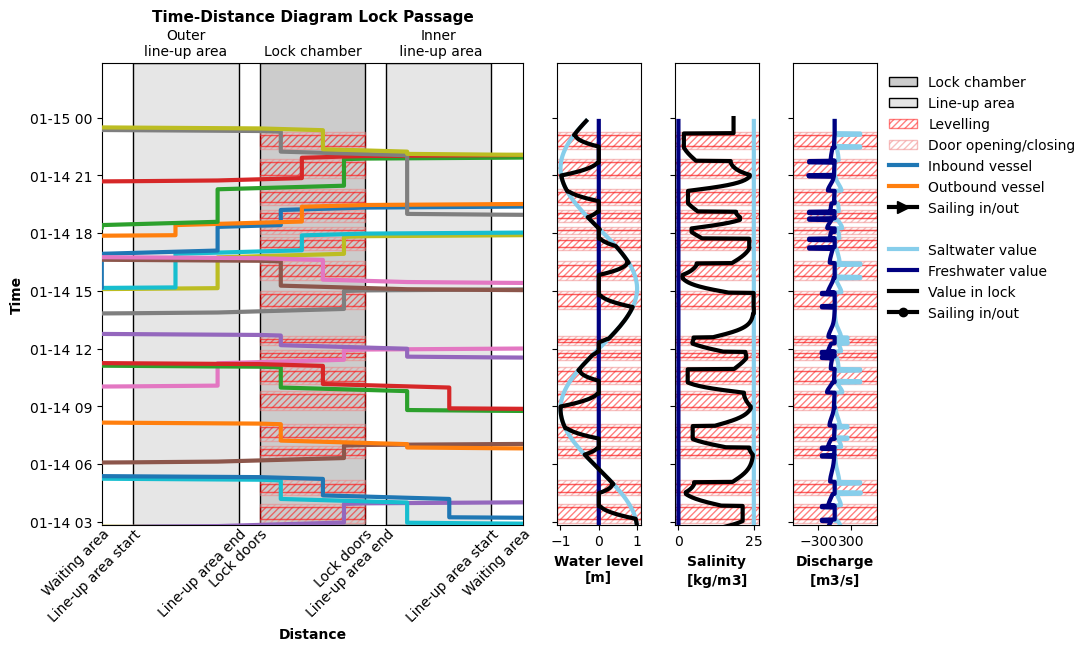

In [23]:
delays = False
entering_leaving = False

distance_to_lock_edge_start = lock_1.env.vessel_traffic_service.provide_sailing_distance_over_route(vessels[0],nx.dijkstra_path(FG,'Node_1','Node_49'))['Distance'].sum()
distance_to_lock_edge_end = lock_1.env.vessel_traffic_service.provide_sailing_distance_over_route(vessels[0],nx.dijkstra_path(FG,'Node_1','Node_50'))['Distance'].sum()
lock_outer_doors = distance_to_lock_edge_start+lock_1.distance_doors1_from_first_waiting_area
lock_inner_doors = distance_to_lock_edge_end-lock_1.distance_doors1_from_first_waiting_area
lineup_1_start = lock_outer_doors - lineup_area_1.distance_to_lock_doors - lineup_area_1.lineup_length
lineup_1_end = lock_outer_doors - lineup_area_1.distance_to_lock_doors
lineup_2_start = lock_inner_doors + lineup_area_2.distance_to_lock_doors + lineup_area_2.lineup_length
lineup_2_end = lock_inner_doors + lineup_area_2.distance_to_lock_doors

fig,axes = plt.subplots(1,4,figsize=[10,6],gridspec_kw = {'width_ratios':[5,1,1,1]})
ax = axes[0]
for time,distance in zip(times,distances):
    ax.plot(distance,time,linewidth=3,zorder=3)
vessel1, = ax.plot([-1,-1],color='C0',linewidth=3)
vessel2, = ax.plot([-1,-1],color='C1',linewidth=3)
for _vessel_ in vessels:
    vessel_df = pd.DataFrame(_vessel_.log)
    if len(vessel_df) < 120:
        continue
    arrival_time = datetime.datetime.fromtimestamp(_vessel_.arrival_time)
    if _vessel_.route[0] == 'Node_98':
        sail_in_time_vessel_2 = pd.DataFrame(_vessel_.log).loc[_vessel_.log['Action'].index('Sailing to first set of lock doors stop')].Time
        sail_out_time_vessel_2 = pd.DataFrame(_vessel_.log).loc[_vessel_.log['Action'].index('Sailing to second set of lock doors stop')].Time
        if entering_leaving:
            ax.plot(lock_inner_doors-40,sail_in_time_vessel_2+pd.Timedelta(40/4,'s'),'C1',marker='<',markersize=8)
            ax.plot(lock_outer_doors-40,sail_out_time_vessel_2+pd.Timedelta(40/4,'s'),'C1',marker='<',markersize=8)
        if delays:
            ax.plot([final_geometry.length,0],[arrival_time,arrival_time+pd.Timedelta(int(final_geometry.length/4),'s')],color='C1',linestyle='--',linewidth=2)
            passage_lineup_start = vessel_df.loc[_vessel_.log['Action'].index('Sailing to line-up area start')].Time
            passage_lineup_stop = vessel_df.loc[_vessel_.log['Action'].index('Sailing to line-up area stop')].Time
            delayed_arrival = 0.8*(passage_lineup_stop-passage_lineup_start)+passage_lineup_start
            normal_arrival = pd.Timedelta((distance_to_lock_edge_start+2000*0.8)/4,'s')+datetime.datetime.fromtimestamp(_vessel_.arrival_time)
            annotate_location = 0.8*(lineup_1_start-lineup_1_end)+lineup_1_end
            ax.annotate('', xy=(annotate_location, delayed_arrival), xycoords='data',
                        xytext=(annotate_location, normal_arrival), textcoords='data',
                        arrowprops={'arrowstyle': '<->'})
            waiting_time = pd.Timedelta(int((delayed_arrival-normal_arrival).total_seconds()/60),'min')
            hours,remainder = divmod(waiting_time.seconds, 3600)
            minutes,_ = divmod(remainder, 60)
            annotate_text_location = 0.5*(delayed_arrival-normal_arrival)+normal_arrival
            ax.annotate(r'$\mathbf{Delay\ time}$'+':\n'+'{:02} hrs {:02} mins'.format(int(hours), int(minutes)), xy=(50+annotate_location,annotate_text_location),
                        xycoords='data',xytext=(5, 0), textcoords='offset points', rotation=90,verticalalignment='center',horizontalalignment='center',color='C1')        

    else:
        sail_in_time_vessel_1 = pd.DataFrame(_vessel_.log).loc[_vessel_.log['Action'].index('Sailing to first set of lock doors stop')].Time
        sail_out_time_vessel_1 = pd.DataFrame(_vessel_.log).loc[_vessel_.log['Action'].index('Sailing to second set of lock doors stop')].Time
        if entering_leaving:
            ax.plot(lock_outer_doors+40,sail_in_time_vessel_1+pd.Timedelta(40/4,'s'),'C0',marker='>',markersize=8)
            ax.plot(lock_inner_doors+40,sail_out_time_vessel_1+pd.Timedelta(40/4,'s'),'C0',marker='>',markersize=8)
        if delays:
            ax.plot([0,final_geometry.length],[arrival_time,arrival_time+pd.Timedelta(int(final_geometry.length/4),'s')],color='C0',linestyle='--',linewidth=2)
            passage_lineup_start = vessel_df.loc[_vessel_.log['Action'].index('Sailing to line-up area start')].Time
            passage_lineup_stop = vessel_df.loc[_vessel_.log['Action'].index('Sailing to line-up area stop')].Time
            delayed_arrival = 0.8*(passage_lineup_stop-passage_lineup_start)+passage_lineup_start
            normal_arrival = pd.Timedelta((distance_to_lock_edge_start+2000*0.8)/4,'s')+datetime.datetime.fromtimestamp(_vessel_.arrival_time)
            annotate_location = 0.8*(lineup_2_start-lineup_2_end)+lineup_2_end
            ax.annotate('', xy=(annotate_location, delayed_arrival), xycoords='data',
                        xytext=(annotate_location, normal_arrival), textcoords='data',
                        arrowprops={'arrowstyle': '<->'})
            waiting_time = pd.Timedelta(int((delayed_arrival-normal_arrival).total_seconds()/60),'min')
            hours,remainder = divmod(waiting_time.seconds, 3600)
            minutes,_ = divmod(remainder, 60)
            annotate_text_location = 0.5*(delayed_arrival-normal_arrival)+normal_arrival
            ax.annotate(r'$\mathbf{Delay\ time}$'+':\n'+'{:02} hrs {:02} mins'.format(int(hours), int(minutes)), xy=(annotate_location-120,annotate_text_location),
                        xycoords='data',xytext=(5, 0), textcoords='offset points', rotation=270,verticalalignment='center',horizontalalignment='center',color='C0')        
        
lock_df = pd.DataFrame(lock_1.log)
for loc,info in lock_df.iterrows():
    if info.Action == 'Lock chamber converting stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        levelling, = ax.fill([lock_outer_doors,lock_outer_doors,lock_inner_doors,lock_inner_doors],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=2,color='none',edgecolor='red',alpha=0.5)
    if info.Action == 'Lock doors closing stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        door_opening_closing, = ax.fill([lock_outer_doors,lock_outer_doors,lock_inner_doors,lock_inner_doors],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
    if info.Action == 'Lock doors opening stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([lock_outer_doors,lock_outer_doors,lock_inner_doors,lock_inner_doors],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
    
ylim_min = lock_df.loc[0].Time-pd.Timedelta(1,'h')
ylim_max = lock_df.iloc[-7].Time+pd.Timedelta(5,'h')
ylim_min = ylim_max - pd.Timedelta(24,'h')
#ylim_max = ylim_min + pd.Timedelta(5,'h')
#ylim_min += pd.Timedelta(12,'h')
#ylim_max = ylim_min + pd.Timedelta(12,'h')

ax.set_ylim(ylim_min,ylim_max)
ylim = ax.get_ylim()
lineup_area_fill, = ax.fill([lineup_1_start,lineup_1_start,lineup_1_end,lineup_1_end],
        [ylim[0],ylim[1],ylim[1],ylim[0]],zorder=0,color=[0.9,0.9,0.9],edgecolor='k')
ax.fill([lineup_2_start,lineup_2_start,lineup_2_end,lineup_2_end],
        [ylim[0],ylim[1],ylim[1],ylim[0]],
        zorder=0,color=[0.9,0.9,0.9],edgecolor='k')
lock_chamber_fill, = ax.fill([lock_outer_doors,lock_outer_doors,lock_inner_doors,lock_inner_doors],
        [ylim[0],ylim[1],ylim[1],ylim[0]],
        zorder=0,color=[0.8,0.8,0.8],edgecolor='k')
ax.set_xlim([distance_to_lock_edge_start,distance_to_lock_edge_end])
ax.set_ylim(ylim)
ax.set_xticks([])

ax.text(50/2000, -0.025, 'Waiting area',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(200/2000, -0.025, 'Line-up area start',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(700/2000, -0.025, 'Line-up area end',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(800/2000, -0.025, 'Lock doors',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(1300/2000, -0.025, 'Lock doors',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(1400/2000, -0.025, 'Line-up area end',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(1900/2000, -0.025, 'Line-up area start',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(2050/2000, -0.025, 'Waiting area',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(400/2000,1.075,'Outer\nline-up area',verticalalignment='top',horizontalalignment='center',transform=ax.transAxes)
ax.text(1000/2000,1.075,'\nLock chamber',verticalalignment='top',horizontalalignment='center',transform=ax.transAxes)
ax.text(1600/2000,1.075,'Inner\n line-up area',verticalalignment='top',horizontalalignment='center',transform=ax.transAxes)
ax.set_xlabel('Distance',labelpad=70,fontweight='bold')
ax.set_ylabel('Time',fontweight='bold')
ax.set_title('Time-Distance Diagram Lock Passage',fontsize=11,fontweight='bold',pad=30)

ax = axes[1]
ax.set_facecolor('white')
ax.plot(hydrodynamic_data.sel(STATIONS=48)['Water level'].values,
        hydrodynamic_data.sel(STATIONS=48)['Water level'].TIME.values,
        color='skyblue',zorder=3,linewidth=3)
ax.plot(hydrodynamic_data.sel(STATIONS=49)['Water level'].values,
        hydrodynamic_data.sel(STATIONS=49)['Water level'].TIME.values,
        color='navy',zorder=3,linewidth=3)
lock_level, = ax.plot(lock_1.water_level.values,lock_1.water_level.TIME.values,zorder=4,linewidth=3,color='k')
ax.set_ylim(ylim)
ax.set_yticklabels([])
xlim_min,xlim_max = ax.get_xlim()
for loc,info in lock_df.iterrows():
    if info.Action == 'Lock chamber converting stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=2,color='none',edgecolor='red',alpha=0.5)
    if info.Action == 'Lock doors closing stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
    if info.Action == 'Lock doors opening stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
ax.set_xlim(xlim_min,xlim_max)
#ax.set_title('Lock\nChamber\nWater level',fontsize=11,fontweight='bold')
ax.set_xticks([-1,0,1])
ax.set_xlabel('Water level\n[m]',fontweight='bold')

ax = axes[2]
ax.set_facecolor('white')
ax.plot(hydrodynamic_data.sel(STATIONS=48)['Salinity'].values,
        hydrodynamic_data.sel(STATIONS=48)['Salinity'].TIME.values,
        color='skyblue',zorder=3,linewidth=3)
ax.plot(hydrodynamic_data.sel(STATIONS=49)['Salinity'].values,
        hydrodynamic_data.sel(STATIONS=49)['Salinity'].TIME.values,
        color='navy',zorder=3,linewidth=3)
ax.plot(lock_1.salinity.values,lock_1.salinity.TIME.values,zorder=4,linewidth=3,color='k')
ax.set_ylim(ylim)
ax.set_yticklabels([])
xlim_min,xlim_max = ax.get_xlim()
for loc,info in lock_df.iterrows():
    if info.Action == 'Lock chamber converting stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=2,color='none',edgecolor='red',alpha=0.5)
    if info.Action == 'Lock doors closing stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
    if info.Action == 'Lock doors opening stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
ax.set_xlim(xlim_min,xlim_max)
#ax.set_title('Lock\nChamber\nSalinity',fontsize=11,fontweight='bold')
ax.set_xticks([0,25])
ax.set_xlabel('Salinity\n'+r'[kg/m$\mathregular{3}$]',fontweight='bold')

ax = axes[3]
ax.set_facecolor('white')
freshwater, = ax.plot(lock_1.discharge_fresh.values,lock_1.discharge_fresh.TIME.values,color='navy',linewidth=3,zorder=4)
if entering_leaving:
    ax.plot(lock_1.discharge_fresh.interp(TIME=sail_in_time_vessel_1).values,sail_in_time_vessel_1,marker='o',color='navy',markersize=6)
    ax.plot(lock_1.discharge_fresh.interp(TIME=sail_out_time_vessel_1).values,sail_out_time_vessel_1,marker='o',color='navy',markersize=6)
saltwater, = ax.plot(lock_1.discharge_saline.values,lock_1.discharge_saline.TIME.values,color='skyblue',linewidth=3,zorder=3)
if entering_leaving:
    ax.plot(lock_1.discharge_saline.interp(TIME=sail_in_time_vessel_2).values,sail_in_time_vessel_2,marker='o',color='skyblue',markersize=6)
    ax.plot(lock_1.discharge_saline.interp(TIME=sail_out_time_vessel_2).values,sail_out_time_vessel_2,marker='o',color='skyblue',markersize=6)
sail_in_out_arrow, = ax.plot([0,0],color='k',marker='>',markersize=8,linewidth=3)
sail_in_out_point, = ax.plot([0,0],color='k',marker='o',markersize=6,linewidth=3)

ax.set_ylim(ylim)
ax.set_yticklabels([])
xlim_min,xlim_max = ax.get_xlim()
for loc,info in lock_df.iterrows():
    if info.Action == 'Lock chamber converting stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=2,color='none',edgecolor='red',alpha=0.5)
    if info.Action == 'Lock doors closing stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
    if info.Action == 'Lock doors opening stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
ax.set_xlim(xlim_min,xlim_max)
#ax.set_title('Lock\nChamber\nDischarge',fontsize=11,fontweight='bold')
ax.legend([lock_chamber_fill,lineup_area_fill,levelling,door_opening_closing,vessel1,vessel2,sail_in_out_arrow,mpl.patches.Patch(color='none'),
           saltwater,freshwater,lock_level,sail_in_out_point],
          ['Lock chamber','Line-up area','Levelling','Door opening/closing','Inbound vessel','Outbound vessel','Sailing in/out','',
           'Saltwater value','Freshwater value','Value in lock','Sailing in/out'],
          bbox_to_anchor=[1,1],frameon=False,prop={'size':10})
ax.set_xticks([-300,300])
ax.set_xlabel('Discharge\n'+r'[m$\mathregular{3}$/s]',fontweight='bold');
#fig.savefig('Basic_lock_passage.svg',dpi=500,format='svg',bbox_inches='tight');

In [24]:
for loc,info in lock_df.iterrows():
    if info.Action == 'Lock chamber converting start':
        if lock_df.loc[loc-1,'Action'] != 'Lock doors closing stop':
            print(loc)
        if lock_df.loc[loc+1,'Action'] != 'Lock chamber converting stop':
            print(loc)

572
800
1418


In [33]:
lock_df = pd.DataFrame(lock_1.log)
lock_df.tail(n=200)[0:50]

,Time,Location,Action,Status
1396,2019-01-13 03:36:52.616647,Node_49,Lock doors opening start,{}
1397,2019-01-13 03:46:52.616647,Node_49,Lock doors opening stop,{}
1398,2019-01-13 04:34:18.691755,Node_49,Lock doors closing start,{}
1399,2019-01-13 04:44:18.691755,Node_49,Lock doors closing stop,{}
1400,2019-01-13 04:44:18.691755,Node_49,Lock chamber converting start,{}
1401,2019-01-13 04:45:18.691755,Node_50,Lock chamber converting stop,{}
1402,2019-01-13 04:45:18.691755,Node_50,Lock doors opening start,{}
1403,2019-01-13 04:55:18.691755,Node_50,Lock doors opening stop,{}
1404,2019-01-13 05:29:56.469533,Node_50,Lock doors closing start,{}
1405,2019-01-13 05:39:56.469533,Node_50,Lock doors closing stop,{}


In [26]:
salt_transport_df = pd.DataFrame(columns=['Side','Levelling start','Levelling stop','Door Open','Door Closed',
                                          'Water level start levelling','Water level stop levelling',
                                          'Ship Volume Left','Ship Volume Entered'])
for loc,info in lock_df.iterrows():
    if info.Action == 'Lock doors closing stop' and loc > 2:
        levelling_start = lock_df.loc[loc-5].Time
        levelling_stop = lock_df.loc[loc-4].Time
        index_levelling_start = np.absolute(lock_1.water_level.TIME.values-np.datetime64(levelling_start)).argmin()
        index_levelling_stop = np.absolute(lock_1.water_level.TIME.values-np.datetime64(levelling_stop)).argmin()
        water_level_start_levelling = lock_1.water_level[index_levelling_start].values
        water_level_stop_levelling = lock_1.water_level[index_levelling_stop].values
        door_open = (lock_df.loc[loc-2].Time-lock_df.loc[loc-3].Time)/2+lock_df.loc[loc-3].Time
        door_closed = (info.Time-lock_df.loc[loc-1].Time)/2+lock_df.loc[loc-1].Time
        volume_loss = 0
        volume_transported = 0
        for _vessel_ in vessels:
            vessel_df = pd.DataFrame(_vessel_.log)
            if vessel_df.empty:
                continue
            vessel_df_door_open_time = vessel_df[(vessel_df.Time > door_open - datetime.timedelta(seconds=lock_1.doors_open)) & 
                                                 (vessel_df.Time < door_closed + datetime.timedelta(seconds=lock_1.doors_close))]
            if not vessel_df_door_open_time.empty and vessel_df_door_open_time.iloc[0].Action == 'Passing lock stop':
                volume_loss += _vessel_.L*_vessel_.B*_vessel_.T
            if not vessel_df_door_open_time.empty and vessel_df_door_open_time.iloc[-1].Action == 'Passing lock start':
                volume_transported += _vessel_.L*_vessel_.B*_vessel_.T
        salt_transport_df.loc[len(salt_transport_df),:] = [info.Location,levelling_start,levelling_stop,door_open,door_closed,
                                                           water_level_start_levelling,water_level_stop_levelling,
                                                           volume_loss,volume_transported]

In [27]:
salt_transport_df['Salt Exchange [kg]'] = 0.0
salt_transport_df['Salt Transported [kg]'] = 0.0
salt_transport_df['Freshwater Exchange [m3]'] = 0.0
salt_transport_df['Freshwater Transported [m3]'] = 0.0
salt_transport_df['Freshwater Levelled [m3]'] = 0.0

for loc,info in salt_transport_df.iterrows():
    if info.Side == 'Node_50':
        salinity_difference = lock_1.salinity.interp(TIME=info['Door Open']).values-np.nanmax([0,lock_1.salinity.interp(TIME=info['Door Closed']).values])
        salt_transport_df.loc[loc,'Salt Exchange [kg]'] = salinity_difference*lock_1.lock_length*lock_1.lock_width*lock_1.lock_depth
        salt_transport_df.loc[loc,'Salt Transported [kg]'] = np.nanmax([0,lock_1.salinity.interp(TIME=info['Door Closed']).values])*info['Ship Volume Entered']
        salt_transport_df.loc[loc,'Freshwater Exchange [m3]'] = lock_1.lock_length*lock_1.lock_width*lock_1.lock_depth*np.tanh((info['Door Closed']-info['Door Open']).total_seconds()/(2*lock_1.lock_length/(0.5*np.sqrt(9.81*0.8*salinity_difference*lock_1.lock_depth/(1000+0.8*25/2)))))
        salt_transport_df.loc[loc,'Freshwater Transported [m3]'] = info['Ship Volume Left']
        water_levelling_difference = info['Water level stop levelling']-info['Water level start levelling']
        if water_levelling_difference > 0:
            salt_transport_df['Freshwater Levelled [m3]'] = water_levelling_difference

In [28]:
(salt_transport_df['Salt Transported [kg]'].sum()+salt_transport_df['Salt Exchange [kg]'].sum())/(25*lock_1.lock_length*lock_1.lock_width*lock_1.lock_depth)

60.93495268204275

In [29]:
delay_df = pd.DataFrame(columns=['Delay'])
for _vessel_ in vessels:
    vessel_df = pd.DataFrame(_vessel_.log)
    start_df = vessel_df[vessel_df.Action == 'Sailing from node Node_49 to node Node_50 start']
    stop_df = vessel_df[vessel_df.Action == 'Sailing from node Node_49 to node Node_50 stop']
    if stop_df.empty or start_df.empty:
        continue
    start_time = start_df.Time.iloc[0]
    stop_time = stop_df.Time.iloc[0]
    delay = stop_time-start_time-pd.Timedelta(FG.edges['Node_49','Node_50',0]['Info']['length']/vessels[0].v,'s')
    delay_df.loc[_vessel_.name,'Delay'] = delay

In [30]:
average_vessel_delay = delay_df.Delay.sum()/len(delay_df)

In [31]:
average_vessel_delay

Timedelta('0 days 02:44:41.173278493')